# 5.经济可行性计算

数据输出：

这里我需要得到一个df，里面含有：

1、光伏策略：

均值df：各撂荒单元RCP情景平均的光伏NPV、发电量×价格的收入、成本（运营+一次性开支），3 * 4个column
模型df：各撂荒单元分模型、分RCP的光伏NPV、

2、


# 5.1 光伏策略经济净收益

## 5.1.1 光伏电力净收益


df_AR6 = pd.read_csv(r'D:\xarray\aligned2\economic_cost\national_growth_rate\AR6_Scenarios_Database_R10_regions_v1.1.csv')
df_world = pd.read_csv(r'D:\xarray\aligned2\economic_cost\national_growth_rate\AR6_Scenarios_Database_World_v1.1.csv')
df_dict = pd.read_csv(r'D:\xarray\aligned2\economic_cost\national_growth_rate\AR6_Scenarios_Database_metadata_indicators_v1.1.csv')


select 'Region' in df_AR6 where is 'R10NORTH_AM' (因为这里代表了美国的水平)

我们需要根据df_dict='D:\xarray\aligned2\economic_cost\national_growth_rate\AR6_Scenarios_Database_metadata_indicators_v1.1.csv'建立一个映射表来分类'Model'、'Scenario'，并将这个关系运用到df_AR6

主要类型是RCP2.6, RCP4.5, RCP6.0, RCP8.5几个主要类型，仅在df_dict中有'Category'列：

if 'Scenario' 的 'Category' == 'C3''C2''C1', 则 'Scenario' 归类为RCP2.6
if 'Scenario' 的 'Category' == 'C4', 则 'Scenario' 归类为RCP4.5
if 'Scenario' 的 'Category' == 'C5', 则 'Scenario' 归类为RCP6.0
if 'Scenario' 的 'Category' == 'C6''C7', 则 'Scenario' 归类为RCP8.5


Second, 在各个RCP情景分组之中，需要使用不同模型column == '2020''2030''2040''2050'的数据来计算单模型净收益，并利用不同模型的各年份平均值计算平均净收益。

for each point in record in df_data, use 'Variable' where has the key word 'Capital Cost|Electricity|Solar|PV' and 'OM Cost|Fixed|Electricity|Solar|PV' and add their 'unit'

单个栅格净收益 = average 'Price|Secondary Energy|Electricity' （单位是US$2010/GJ）in '2020''2030''2040''2050' * 栅格发电量（这里单位是kw） - average 'OM Cost|Fixed|Electricity|Solar|PV' （单位是US$2010/kW/yr）in '2020''2030''2040''2050' * 30 年  - average 'Capital Cost|Electricity|Solar|PV'（US$2010/kW/yr
） in '2020''2030''2040''2050' * 装机容量

装机容量= df_data['area_m2']*0.86*0.17 （这里单位是kw）
栅格发电量=df_data['E_yr_pixel']*0.86 （这里单位是kwh）

贴现率为5%，计算净现值

third, 数据输出数量：'Model'的数量*'Scenario'RCP情景的组数（一般是四组）*时间点（2020，2030，2040，2050）+ 四组RCP情景各自的平均净收益

lastly,选择一个合适的图表，能够绘制四个情景中不同模型的NPV随着时间累积变化曲线，并且四组RCP情景各自的平均净收益

#### 1、数据预处理模块

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate
from scipy.stats import gaussian_kde
from matplotlib.pyplot import rcParams

plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']  
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('default')

# 全局参数设置
DISCOUNT_RATE = 0.05  # 5%
PROJECT_LIFETIME = 30  # 30年
PROJECT_START_YEAR = 2020  # 项目开始年份
TARGET_YEARS = ['2020', '2030', '2040', '2050']
INTERPOLATION_YEARS = list(range(2020, 2051))  # 2020-2050年逐年数据

# 价格调整参数：2010年美元 -> 2020年美元
# 基于美国劳工统计局CPI数据求得，2010-2020年累积通胀率约18.7%
INFLATION_ADJUSTMENT_2010_TO_2020 = 1.187  



def adjust_price_to_2020_usd(price_2010_usd):
    """将2010年美元调整为2020年美元购买力"""
    if pd.isna(price_2010_usd):
        return price_2010_usd
    return price_2010_usd * INFLATION_ADJUSTMENT_2010_TO_2020

def apply_inflation_adjustment_to_time_series(time_series_dict):
    """对时间序列字典应用通胀调整"""
    adjusted_dict = {}
    for year, value in time_series_dict.items():
        adjusted_dict[year] = adjust_price_to_2020_usd(value)
    return adjusted_dict



'''
This function is used for adjusting the year by year data from 2020 to 2050


detail: all the money value is in 2010 usd, so we need to adjust it to 2020 usd


'''

def extract_data_with_missing_value_filling_adjusted(df_costs, df_availability, target_variables, fallback_values):
    """提取数据并填充缺失值，同时进行价格调整"""
    
    # 筛选可用的模型-RCP组合
    usable_combinations = df_availability[df_availability['is_usable']]
    
    # 创建变量名到列名的映射 - 确保一致性
    var_name_to_column = {
        'capital_cost': 'has_capital_cost',
        'om_fixed_cost': 'has_om_fixed_cost',
        'electricity_price': 'has_electricity_price'
    }
    results = []
    filled_count = 0
    
    for _, row in usable_combinations.iterrows():
        rcp = row['RCP_Category']
        model = row['Model']
        
        # 获取该模型-RCP的数据
        model_rcp_data = df_costs[
            (df_costs['RCP_Category'] == rcp) & 
            (df_costs['Model'] == model)
        ]
        
        # 提取各变量的时间序列数据
        var_time_series = {}
        model_filled_vars = []
        
        for var_name, var_full_name in target_variables.items():
            var_data = model_rcp_data[model_rcp_data['Variable'] == var_full_name]
            column_name = var_name_to_column[var_name]
            
            if len(var_data) > 0 and row[column_name]:
                year_values = []
                year_points = []
                
                for year in TARGET_YEARS:
                    if year in var_data.columns:
                        value = var_data[year].iloc[0]
                        if not pd.isna(value):
                            year_values.append(value)
                            year_points.append(int(year))
                
                if len(year_values) >= 2:
                    # 使用线性插值
                    f_interp = interpolate.interp1d(year_points, year_values, 
                                                  kind='linear', 
                                                  fill_value='extrapolate')
                    
                    interpolated_values = f_interp(INTERPOLATION_YEARS)
                    
                    # 应用价格调整（2010年美元 -> 2020年美元）
                    adjusted_values = {year: adjust_price_to_2020_usd(val) 
                                     for year, val in zip(INTERPOLATION_YEARS, interpolated_values)}
                    var_time_series[var_name] = adjusted_values
                    
                    # 获取单位信息并更新
                    original_unit = var_data['Unit'].iloc[0] if 'Unit' in var_data.columns else 'Unknown'
                    adjusted_unit = original_unit.replace('US$2010', 'US$2020') if 'US$2010' in original_unit else original_unit
                    var_time_series[f'{var_name}_unit'] = adjusted_unit
                    var_time_series[f'{var_name}_source'] = 'interpolated_adjusted'
                else:
                    # 数据点不足，使用填充值
                    fallback_value = adjust_price_to_2020_usd(fallback_values[rcp][var_name])
                    var_time_series[var_name] = {year: fallback_value for year in INTERPOLATION_YEARS}
                    
                    default_units = {
                        'capital_cost': 'US$2020/kW',
                        'om_fixed_cost': 'US$2020/kW/yr',
                        'electricity_price': 'US$2020/GJ'
                    }
                    var_time_series[f'{var_name}_unit'] = default_units.get(var_name, 'Unknown')
                    var_time_series[f'{var_name}_source'] = 'filled_adjusted'
                    model_filled_vars.append(var_name)
                    filled_count += 1
            else:
                # 使用填充值
                fallback_value = adjust_price_to_2020_usd(fallback_values[rcp][var_name])
                var_time_series[var_name] = {year: fallback_value for year in INTERPOLATION_YEARS}
                # 默认单位（调整为2020年美元）
                default_units = {
                    'capital_cost': 'US$2020/kW',
                    'om_fixed_cost': 'US$2020/kW/yr',
                    'electricity_price': 'US$2020/GJ'
                }
                var_time_series[f'{var_name}_unit'] = default_units.get(var_name, 'Unknown')
                var_time_series[f'{var_name}_source'] = 'filled_adjusted'
                model_filled_vars.append(var_name)
                filled_count += 1
        
        # 记录填充信息
        if model_filled_vars:
            print(f"     {rcp} - {model}: 填充变量 -> {', '.join(model_filled_vars)}")
        
        # 保存结果
        results.append({
            'RCP_Category': rcp,
            'Model': model,
            **var_time_series
        })
    
    df_processed = pd.DataFrame(results)
    
    print(f"   处理完成的模型-RCP组合: {len(df_processed)}")
    print(f"   总填充次数: {filled_count}")
    print(f"   价格已调整为2020年美元购买力")
    print("   各RCP类别可用模型数:")
    for rcp in ['RCP2.6', 'RCP4.5', 'RCP6.0', 'RCP8.5']:
        count = len(df_processed[df_processed['RCP_Category'] == rcp])
        print(f"     {rcp}: {count} 个模型")
    
    return df_processed

'''

'''

def calculate_fallback_values_by_rcp_adjusted(df_costs, df_availability, target_variables):
    """计算各RCP类别下每个变量的平均值用于填充（含价格调整）"""
    print("1.5 计算填充值（含价格调整）...")
    
    # 使用原有逻辑计算填充值
    usable_models = df_availability[df_availability['is_usable']]
    var_name_to_column = {
        'capital_cost': 'has_capital_cost',
        'om_fixed_cost': 'has_om_fixed_cost',
        'electricity_price': 'has_electricity_price'
    }
    
    fallback_values = {}
    
    for rcp in ['RCP2.6', 'RCP4.5', 'RCP6.0', 'RCP8.5']:
        rcp_models = usable_models[usable_models['RCP_Category'] == rcp]
        fallback_values[rcp] = {}
        
        for var_name, var_full_name in target_variables.items():
            column_name = var_name_to_column[var_name]
            available_models = rcp_models[rcp_models[column_name]]
            
            if len(available_models) > 0:
                all_values = []
                
                for _, model_row in available_models.iterrows():
                    model = model_row['Model']
                    model_data = df_costs[
                        (df_costs['RCP_Category'] == rcp) & 
                        (df_costs['Model'] == model) & 
                        (df_costs['Variable'] == var_full_name)
                    ]
                    
                    if len(model_data) > 0:
                        for year in TARGET_YEARS:
                            if year in model_data.columns:
                                values = model_data[year].dropna()
                                all_values.extend(values.tolist())
                
                if all_values:
                    # 应用价格调整
                    adjusted_mean = adjust_price_to_2020_usd(np.mean(all_values))
                    fallback_values[rcp][var_name] = adjusted_mean
                else:
                    fallback_values[rcp][var_name] = 0
            else:
                fallback_values[rcp][var_name] = 0
    
    # 输出填充值（2020年美元）
    print(f"   各RCP类别填充值（2020年美元）:")
    for rcp in ['RCP2.6', 'RCP4.5', 'RCP6.0', 'RCP8.5']:
        if rcp in fallback_values:
            print(f"   {rcp}:")
            for var_name, value in fallback_values[rcp].items():
                print(f"     {var_name}: {value:.2f}")
    
    return fallback_values


def load_and_prepare_data():
    """加载并预处理所有数据"""
    
    print("1.1 加载原始数据...")
    # 加载AR6数据
    df_AR6 = pd.read_csv(r'D:\xarray\aligned2\economic_cost\national_growth_rate\AR6_Scenarios_Database_R10_regions_v1.1.csv')
    df_world = pd.read_csv(r'D:\xarray\aligned2\economic_cost\national_growth_rate\AR6_Scenarios_Database_World_v1.1.csv')
    df_dict = pd.read_csv(r'D:\xarray\aligned2\economic_cost\national_growth_rate\AR6_Scenarios_Database_metadata_indicators_v1.1.csv')
    df_data = pd.read_csv(r'data\4.data_prediction_net_benefit.csv')
    
    return df_AR6, df_dict, df_data

def create_rcp_mapping(df_dict):
    """创建RCP情景映射，理论上AR6数据是没有缺失值的，但是为了保险起见，还是进行了记录完整性检查"""

    print("1.2 创建RCP情景映射...")
    category_to_rcp = {
        'C1': 'RCP2.6', 'C2': 'RCP2.6', 'C3': 'RCP2.6',
        'C4': 'RCP4.5', 'C5': 'RCP6.0',
        'C6': 'RCP8.5', 'C7': 'RCP8.5'
    }
    
    scenario_mapping = df_dict[['Model', 'Scenario', 'Category']].copy()
    scenario_mapping['RCP_Category'] = scenario_mapping['Category'].map(category_to_rcp)
    
    # 移除无法映射的记录
    scenario_mapping = scenario_mapping.dropna(subset=['RCP_Category'])
    
    print(f"   RCP映射创建完成: {len(scenario_mapping)} 条记录")
    rcp_counts = scenario_mapping['RCP_Category'].value_counts()
    for rcp, count in rcp_counts.items():
        print(f"     {rcp}: {count} 个情景")
    
    return scenario_mapping

def analyze_data_availability_and_fill_missing(df_AR6, scenario_mapping):
    """分析数据可用性并填充缺失值"""
    
    print("1.3 筛选R10NORTH_AM区域数据...")
    df_AR6_US = df_AR6[df_AR6['Region'] == 'R10NORTH_AM'].copy()
    print(f"   美国区域数据: {len(df_AR6_US)} 行")
    
    # 应用RCP映射
    df_AR6_mapped = df_AR6_US.merge(scenario_mapping[['Model', 'Scenario', 'RCP_Category']], 
                                   on=['Model', 'Scenario'], how='inner')
    print(f"   映射后数据: {len(df_AR6_mapped)} 行")
    
    # 定义目标变量
    target_variables = {
        'capital_cost': 'Capital Cost|Electricity|Solar|PV',
        'om_fixed_cost': 'OM Cost|Fixed|Electricity|Solar|PV', 
        'electricity_price': 'Price|Secondary Energy|Electricity'
    }
    
    # 筛选相关变量
    relevant_vars = list(target_variables.values())
    df_costs = df_AR6_mapped[df_AR6_mapped['Variable'].isin(relevant_vars)].copy()
    
    # 转换年份列为数值
    for year in TARGET_YEARS:
        if year in df_costs.columns:
            df_costs[year] = pd.to_numeric(df_costs[year], errors='coerce')
    
    print("1.4 分析数据可用性...")
    # 分析每个模型-RCP组合的数据可用性
    availability_stats = []
    
    for rcp in ['RCP2.6', 'RCP4.5', 'RCP6.0', 'RCP8.5']:
        rcp_data = df_costs[df_costs['RCP_Category'] == rcp]
        
        if len(rcp_data) == 0:
            continue
            
        for model in rcp_data['Model'].unique():
            model_data = rcp_data[rcp_data['Model'] == model]
            
            # 检查每个变量的可用性
            var_availability = {}
            available_variables = []
            
            for var_name, var_full_name in target_variables.items():
                var_data = model_data[model_data['Variable'] == var_full_name]
                
                # 检查是否有数据
                has_data = len(var_data) > 0
                has_year_data = False
                
                if has_data:
                    # 检查是否至少有一个年份有数据
                    year_data_count = 0
                    for year in TARGET_YEARS:
                        if year in var_data.columns:
                            year_values = var_data[year].dropna()
                            if len(year_values) > 0:
                                year_data_count += 1
                    has_year_data = year_data_count >= 2  # 至少需要2个年份用于插值
                
                var_availability[var_name] = has_data and has_year_data
                if var_availability[var_name]:
                    available_variables.append(var_name)
            
            # 只保留至少有一个变量可用的模型
            has_any_variable = len(available_variables) > 0
            
            # 确保列名与target_variables中的key一致
            availability_stats.append({
                'RCP_Category': rcp,
                'Model': model,
                'has_capital_cost': var_availability['capital_cost'],
                'has_om_fixed_cost': var_availability['om_fixed_cost'],  
                'has_electricity_price': var_availability['electricity_price'],
                'available_variables': available_variables,
                'variable_count': len(available_variables),
                'is_usable': has_any_variable
            })
    
    df_availability = pd.DataFrame(availability_stats)
    
    # 筛选可用的模型
    usable_models = df_availability[df_availability['is_usable']]
    unusable_models = df_availability[~df_availability['is_usable']]
    
    print(f"   总模型-RCP组合: {len(df_availability)}")
    print(f"   可用组合: {len(usable_models)}")
    print(f"   不可用组合: {len(unusable_models)}")
    
    # 显示不可用的模型
    if len(unusable_models) > 0:
        print(f"   排除的模型-RCP组合:")
        for _, row in unusable_models.iterrows():
            print(f"     {row['RCP_Category']} - {row['Model']}: 无可用变量")
    
    return df_costs, df_availability, target_variables

#### 2、光伏收益-成本计算模块

In [2]:


def calculate_npv_for_year(electricity_price, om_cost, capital_cost, area_m2, e_yr_pixel, 
                          project_year, discount_rate=DISCOUNT_RATE):
    """
    计算从项目开始到指定年份的累积NPV（2020年美元）
    project_year: 相对于2020年的项目年份（如2030年 = 第10年）
    """
    
    # 计算装机容量和发电量，eta_stc=0.17，这里就相当于单个栅格的装机容量
    installed_capacity = area_m2 * 0.17  # kW
    grid_generation = e_yr_pixel  # kWh
    
    # 处理缺失值
    electricity_price = electricity_price if not pd.isna(electricity_price) else 0
    om_cost = om_cost if not pd.isna(om_cost) else 0
    capital_cost = capital_cost if not pd.isna(capital_cost) else 0
    
    # 单位转换：electricity_price: US$2020/GJ -> US$2020/kWh
    electricity_price_per_kwh = electricity_price / 277.778
    
    # 计算年度现金流
    annual_revenue = electricity_price_per_kwh * grid_generation
    annual_om_cost = om_cost * installed_capacity
    annual_net_cash_flow = annual_revenue - annual_om_cost
    
    # 初始投资（t=0时刻）
    initial_investment = capital_cost * installed_capacity
    
    # 计算NPV（从项目开始年2020年到指定年份）
    years_from_start = project_year - PROJECT_START_YEAR
    
    # NPV = -初始投资 + Σ(年度净现金流 / (1+r)^t)
    cumulative_npv = -initial_investment
    
    # 计算累积成本（现值）
    cumulative_cost = initial_investment  # 初始投资
    
    for t in range(1, min(years_from_start + 1, PROJECT_LIFETIME + 1)):
        # NPV计算
        cumulative_npv += annual_net_cash_flow / (1 + discount_rate) ** t
        
        # 累积成本计算（运维成本的现值）
        cumulative_cost += annual_om_cost / (1 + discount_rate) ** t
    
    return {
        'installed_capacity_kw': installed_capacity,
        'grid_generation_kwh': grid_generation,
        'annual_revenue_usd': annual_revenue,
        'annual_om_cost_usd': annual_om_cost,
        'annual_net_cash_flow_usd': annual_net_cash_flow,
        'initial_investment_usd': initial_investment,
        'cumulative_npv_usd': cumulative_npv,
        'cumulative_cost_usd': cumulative_cost,  
        'project_year': project_year,
        'years_from_start': years_from_start
    }

def compute_npv_time_series(df_data, df_processed):
    """计算所有像素、模型、年份组合的NPV时间序列"""
    
    print("2.1 计算NPV时间序列...")
    
    npv_results = []
    
    # 对每个栅格像素
    for pixel_idx, pixel_row in df_data.iterrows():
        area_m2 = pixel_row['area_m2']
        e_yr_pixel = pixel_row['E_yr_pixel']
        lat = pixel_row['lat']
        lon = pixel_row['lon']
        
        # 对每个处理后的模型-RCP组合
        for _, model_row in df_processed.iterrows():
            rcp = model_row['RCP_Category']
            model = model_row['Model']
            
            # 对每个分析年份计算NPV
            for analysis_year in [2020, 2030, 2040, 2050]:
                
                # 获取该年份的数据
                capital_cost = model_row['capital_cost'][analysis_year]
                om_cost = model_row['om_fixed_cost'][analysis_year]
                electricity_price = model_row['electricity_price'][analysis_year]
                
                # 计算NPV
                npv_calc = calculate_npv_for_year(
                    electricity_price, om_cost, capital_cost,
                    area_m2, e_yr_pixel, analysis_year
                )
                
                # 保存结果，包含数据来源信息
                npv_results.append({
                    'pixel_id': pixel_idx,
                    'lat': lat,
                    'lon': lon,
                    'area_m2': area_m2,
                    'E_yr_pixel': e_yr_pixel,
                    'RCP_Category': rcp,
                    'Model': model,
                    'analysis_year': analysis_year,
                    'capital_cost': capital_cost,
                    'capital_cost_source': model_row.get('capital_cost_source', 'interpolated_adjusted'),
                    'om_fixed_cost': om_cost,
                    'om_fixed_cost_source': model_row.get('om_fixed_cost_source', 'interpolated_adjusted'),
                    'electricity_price': electricity_price,
                    'electricity_price_source': model_row.get('electricity_price_source', 'interpolated_adjusted'),
                    **npv_calc
                })
    
    df_npv_time_series = pd.DataFrame(npv_results)
    
    print(f"   NPV计算完成: {len(df_npv_time_series)} 条记录")
    print(f"   覆盖像素数: {df_npv_time_series['pixel_id'].nunique()}")
    print(f"   覆盖模型数: {df_npv_time_series['Model'].nunique()}")
    print(f"   覆盖RCP情景: {df_npv_time_series['RCP_Category'].nunique()}")
    
    return df_npv_time_series

def calculate_summary_statistics(df_npv_time_series):
    """计算汇总统计"""
    
    print("2.2 计算汇总统计...")
    
    # 按RCP和年份计算NPV统计
    npv_by_rcp_year = df_npv_time_series.groupby(['RCP_Category', 'analysis_year'])['cumulative_npv_usd'].agg([
        'mean', 'std', 'count', 'min', 'max'
    ]).reset_index()
    
    # 按RCP和年份计算累积成本统计
    cost_by_rcp_year = df_npv_time_series.groupby(['RCP_Category', 'analysis_year'])['cumulative_cost_usd'].agg([
        'mean', 'std', 'count', 'min', 'max'
    ]).reset_index()
    cost_by_rcp_year.columns = ['RCP_Category', 'analysis_year', 'cost_mean', 'cost_std', 'cost_count', 'cost_min', 'cost_max']
    
    # 合并NPV和成本统计
    combined_by_rcp_year = npv_by_rcp_year.merge(cost_by_rcp_year, on=['RCP_Category', 'analysis_year'])
    
    # 计算成本效益比 (Cost-Benefit Ratio)
    combined_by_rcp_year['cost_benefit_ratio'] = combined_by_rcp_year['cost_mean'] / (combined_by_rcp_year['mean'] + combined_by_rcp_year['cost_mean'])
    
    # 按RCP计算总体平均
    rcp_overall_averages = df_npv_time_series.groupby('RCP_Category').agg({
        'cumulative_npv_usd': 'mean',
        'cumulative_cost_usd': 'mean'
    })
    rcp_overall_averages['overall_cost_benefit_ratio'] = rcp_overall_averages['cumulative_cost_usd'] / (
        rcp_overall_averages['cumulative_npv_usd'] + rcp_overall_averages['cumulative_cost_usd']
    )
    
    # 模型统计
    model_stats = df_npv_time_series.groupby('RCP_Category')['Model'].nunique()
    
    print("   RCP总体平均统计 (2020年美元):")
    for rcp in rcp_overall_averages.index:
        avg_npv = rcp_overall_averages.loc[rcp, 'cumulative_npv_usd']
        avg_cost = rcp_overall_averages.loc[rcp, 'cumulative_cost_usd']
        cost_ratio = rcp_overall_averages.loc[rcp, 'overall_cost_benefit_ratio']
        model_count = model_stats[rcp]
        print(f"     {rcp}: NPV=${avg_npv:,.0f}, 累积成本=${avg_cost:,.0f}, 成本比={cost_ratio:.3f} ({model_count} 个模型)")
    
    return combined_by_rcp_year, rcp_overall_averages, model_stats


# ========================================================================================
# 主执行流程 - 修改版本
# ========================================================================================

print("\n" + "="*50)
print("模块1: 数据预处理开始")
print("="*50)

# 执行数据预处理
df_AR6, df_dict, df_data = load_and_prepare_data()
scenario_mapping = create_rcp_mapping(df_dict)
df_costs, df_availability, target_variables = analyze_data_availability_and_fill_missing(df_AR6, scenario_mapping)
fallback_values = calculate_fallback_values_by_rcp_adjusted(df_costs, df_availability, target_variables)
df_processed = extract_data_with_missing_value_filling_adjusted(df_costs, df_availability, target_variables, fallback_values)

print("模块1: 数据预处理完成!")
print("="*50)

# 执行NPV计算
print("\n" + "="*50)
print("模块2: NPV计算开始")
print("="*50)

df_npv_time_series = compute_npv_time_series(df_data, df_processed)
npv_by_rcp_year, rcp_overall_averages, model_stats = calculate_summary_statistics(df_npv_time_series)

print("模块2: NPV计算完成!")
print("="*50)




模块1: 数据预处理开始
1.1 加载原始数据...
1.2 创建RCP情景映射...
   RCP映射创建完成: 1173 条记录
     RCP2.6: 541 个情景
     RCP8.5: 261 个情景
     RCP6.0: 212 个情景
     RCP4.5: 159 个情景
1.3 筛选R10NORTH_AM区域数据...
   美国区域数据: 439263 行
   映射后数据: 388909 行
1.4 分析数据可用性...
   总模型-RCP组合: 55
   可用组合: 55
   不可用组合: 0
1.5 计算填充值（含价格调整）...
   各RCP类别填充值（2020年美元）:
   RCP2.6:
     capital_cost: 908.36
     om_fixed_cost: 62.19
     electricity_price: 30.59
   RCP4.5:
     capital_cost: 997.61
     om_fixed_cost: 38.14
     electricity_price: 28.89
   RCP6.0:
     capital_cost: 934.25
     om_fixed_cost: 48.64
     electricity_price: 25.89
   RCP8.5:
     capital_cost: 986.54
     om_fixed_cost: 64.62
     electricity_price: 27.51
     RCP2.6 - GCAM 5.3: 填充变量 -> om_fixed_cost
     RCP2.6 - GEM-E3_V2021: 填充变量 -> om_fixed_cost, electricity_price
     RCP2.6 - TIAM-ECN 1.1: 填充变量 -> om_fixed_cost
     RCP4.5 - GCAM 5.2: 填充变量 -> om_fixed_cost, electricity_price
     RCP4.5 - GCAM 5.3: 填充变量 -> om_fixed_cost
     RCP4.5 - GEM-E3_V2021: 填充变量 -> o

### 3、可视化与保存模块


模块3: 光伏经济可行性可视化开始（修复版）
创建光伏经济可行性综合分析图...
预处理光伏数据，检查和创建必需的列...
当前数据框列名： ['pixel_id', 'lat', 'lon', 'area_m2', 'E_yr_pixel', 'RCP_Category', 'Model', 'analysis_year', 'capital_cost', 'capital_cost_source', 'om_fixed_cost', 'om_fixed_cost_source', 'electricity_price', 'electricity_price_source', 'installed_capacity_kw', 'grid_generation_kwh', 'annual_revenue_usd', 'annual_om_cost_usd', 'annual_net_cash_flow_usd', 'initial_investment_usd', 'cumulative_npv_usd', 'cumulative_cost_usd', 'project_year', 'years_from_start']
⚠ 基于默认容量因子计算年发电量
✓ 计算容量因子
✓ 计算年度总收益
✓ 计算年度运维成本
✓ 计算电价
数据预处理完成，共 15468640 行数据
使用 3867160 个数据点进行分析


C:\Users\zpy10\AppData\Local\Temp\ipykernel_22372\2189158165.py:409: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(cf_data, npv_cf, 1)
C:\Users\zpy10\AppData\Local\Temp\ipykernel_22372\2189158165.py:425: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\zpy10\AppData\Local\Temp\ipykernel_22372\2189158165.py:426: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('data/5.1_photovoltaic_economic_analysis_fixed.png', dpi=300, bbox_inches='tight')
c:\Users\zpy10\Anaconda3\envs\geo\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


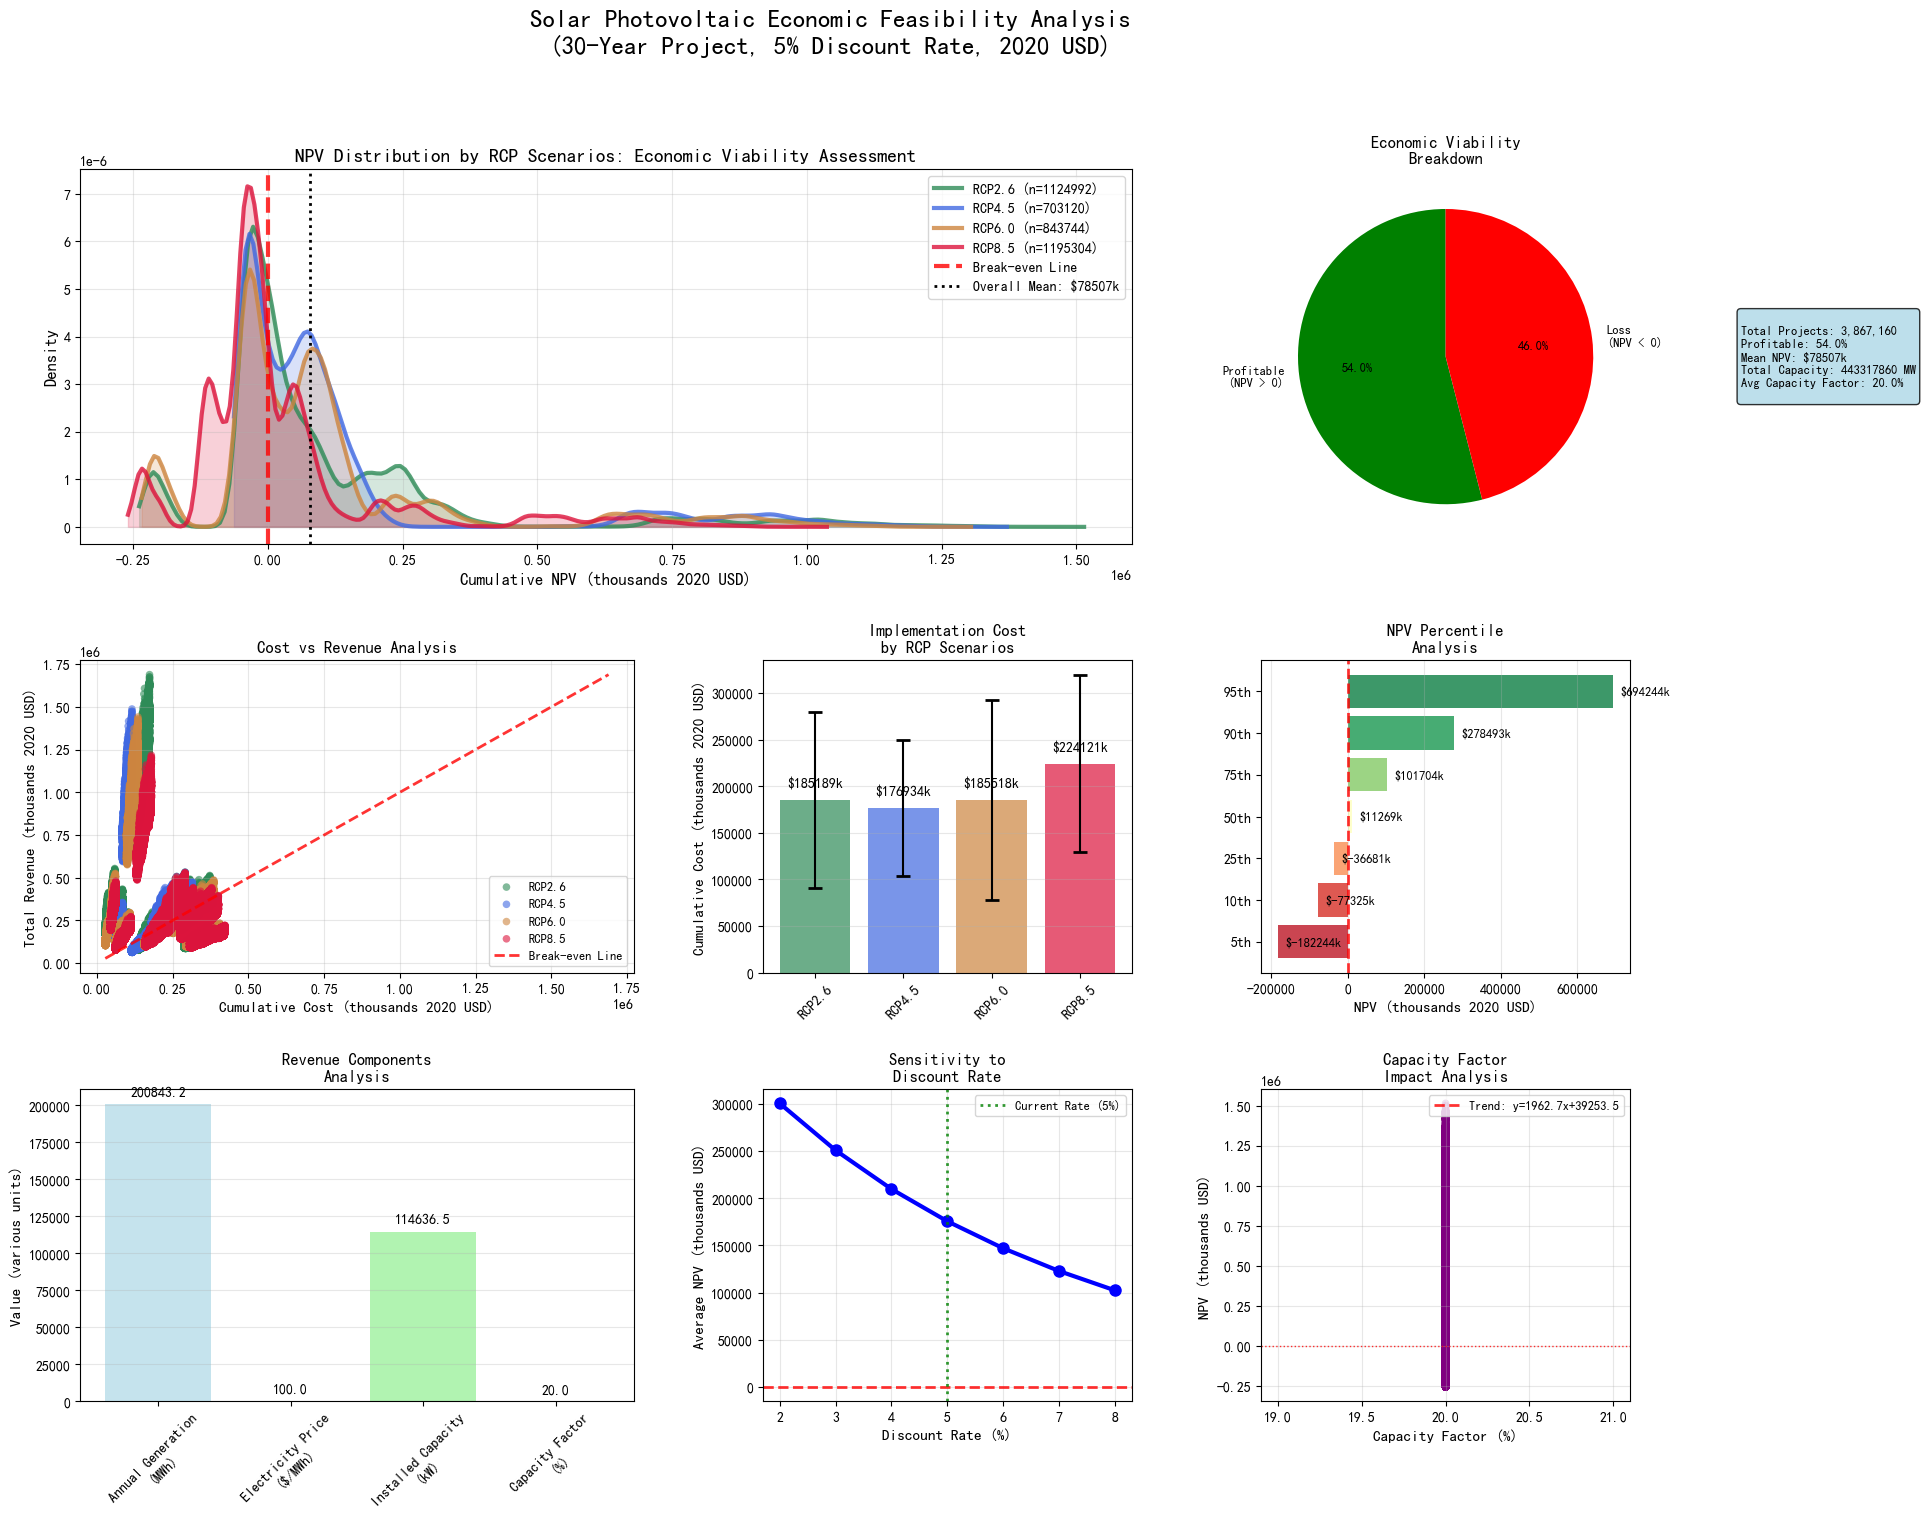

✓ 综合经济分析图创建成功


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import gaussian_kde
from matplotlib.patches import Rectangle, Patch
import pandas as pd

# 设置配色方案（与复林风格一致）
pv_colors = {
    'RCP2.6': '#2E8B57',    # 海绿色
    'RCP4.5': '#4169E1',    # 皇家蓝
    'RCP6.0': '#CD853F',    # 秘鲁色  
    'RCP8.5': '#DC143C',    # 深红色
    'profitable': '#2E8B57',
    'loss': '#DC143C',
    'cost': '#CD853F',
    'revenue': '#4169E1'
}

plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

def prepare_pv_data(df_npv_time_series):
    """预处理光伏数据，确保所有必需的列都存在"""
    
    print("预处理光伏数据，检查和创建必需的列...")
    
    df = df_npv_time_series.copy()
    
    # 检查并创建标准化的列名
    print("当前数据框列名：", df.columns.tolist())
    
    # 标准化NPV列名
    if 'cumulative_npv_usd' not in df.columns and 'NPV' in df.columns:
        df['cumulative_npv_usd'] = df['NPV']
        print("✓ 使用 'NPV' 列作为 'cumulative_npv_usd'")
    
    # 标准化成本列名
    if 'cumulative_cost_usd' not in df.columns:
        # 尝试从其他列计算或设置默认值
        if 'capital_cost' in df.columns and 'installed_capacity' in df.columns:
            df['initial_investment_usd'] = df['capital_cost'] * df['installed_capacity']
            df['cumulative_cost_usd'] = df['initial_investment_usd']
            print("✓ 从资本成本计算累积成本")
        else:
            df['cumulative_cost_usd'] = 0
            df['initial_investment_usd'] = 0
            print("⚠ 设置默认累积成本为0")
    
    # 标准化装机容量列名
    if 'installed_capacity_kw' not in df.columns:
        if 'installed_capacity' in df.columns:
            df['installed_capacity_kw'] = df['installed_capacity']
            print("✓ 使用 'installed_capacity' 作为 'installed_capacity_kw'")
        else:
            df['installed_capacity_kw'] = 1.0  # 默认1kW
            print("⚠ 设置默认装机容量为1kW")
    
    # 标准化年发电量列名
    if 'annual_generation_kwh' not in df.columns:
        if 'grid_generation' in df.columns:
            df['annual_generation_kwh'] = df['grid_generation']
            print("✓ 使用 'grid_generation' 作为 'annual_generation_kwh'")
        elif 'e_yr_pixel' in df.columns:
            df['annual_generation_kwh'] = df['e_yr_pixel']
            print("✓ 使用 'e_yr_pixel' 作为 'annual_generation_kwh'")
        else:
            df['annual_generation_kwh'] = df['installed_capacity_kw'] * 8760 * 0.20  # 默认20%容量因子
            print("⚠ 基于默认容量因子计算年发电量")
    
    # 计算容量因子
    if 'capacity_factor' not in df.columns:
        # 容量因子 = 实际发电量 / (装机容量 × 8760小时)
        df['capacity_factor'] = np.where(
            df['installed_capacity_kw'] > 0,
            df['annual_generation_kwh'] / (df['installed_capacity_kw'] * 8760),
            0.20  # 默认20%容量因子
        )
        # 限制容量因子在合理范围内
        df['capacity_factor'] = np.clip(df['capacity_factor'], 0, 1)
        print("✓ 计算容量因子")
    
    # 标准化收益相关列
    if 'annual_total_revenue_usd' not in df.columns:
        if 'annual_revenue' in df.columns:
            df['annual_total_revenue_usd'] = df['annual_revenue']
        else:
            # 尝试从电价和发电量计算
            if 'electricity_price_per_kwh' in df.columns:
                df['annual_total_revenue_usd'] = df['annual_generation_kwh'] * df['electricity_price_per_kwh']
            else:
                df['annual_total_revenue_usd'] = df['annual_generation_kwh'] * 0.1  # 默认电价0.1$/kWh
        print("✓ 计算年度总收益")
    
    # 标准化成本相关列
    if 'annual_cost_usd' not in df.columns:
        if 'annual_om_cost' in df.columns:
            df['annual_cost_usd'] = df['annual_om_cost']
        elif 'om_cost' in df.columns and 'installed_capacity_kw' in df.columns:
            df['annual_cost_usd'] = df['om_cost'] * df['installed_capacity_kw']
        else:
            df['annual_cost_usd'] = df['installed_capacity_kw'] * 20  # 默认运维成本20$/kW/年
        print("✓ 计算年度运维成本")
    
    if 'annual_net_revenue_usd' not in df.columns:
        df['annual_net_revenue_usd'] = df['annual_total_revenue_usd'] - df['annual_cost_usd']
    
    # 标准化电价列
    if 'electricity_price_per_kwh' not in df.columns:
        if len(df) > 0:
            df['electricity_price_per_kwh'] = df['annual_total_revenue_usd'] / np.maximum(df['annual_generation_kwh'], 1)
        else:
            df['electricity_price_per_kwh'] = 0.1  # 默认电价
        print("✓ 计算电价")
    
    print(f"数据预处理完成，共 {len(df)} 行数据")
    return df

def create_photovoltaic_economic_analysis_fixed(df_npv_time_series):
    """创建光伏经济可行性综合分析图（修复版）"""
    
    print("创建光伏经济可行性综合分析图...")
    
    # 预处理数据
    df_processed = prepare_pv_data(df_npv_time_series)
    
    # 使用2050年数据进行分析
    df_final = df_processed[df_processed['analysis_year'] == 2050].copy()
    
    if len(df_final) == 0:
        print("⚠ 没有2050年数据，使用最后一年的数据")
        max_year = df_processed['analysis_year'].max()
        df_final = df_processed[df_processed['analysis_year'] == max_year].copy()
    
    print(f"使用 {len(df_final)} 个数据点进行分析")
    
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3, height_ratios=[1.2, 1, 1], width_ratios=[1.5, 1, 1])
    
    # 主标题
    fig.suptitle('Solar Photovoltaic Economic Feasibility Analysis\n(30-Year Project, 5% Discount Rate, 2020 USD)', 
                 fontsize=18, fontweight='bold', y=0.98)
    
    # ========================================================================================
    # 图1: NPV分布密度图 (左上，跨2列)
    # ========================================================================================
    ax1 = fig.add_subplot(gs[0, :2])
    
    # 计算NPV分布（转换为千美元）
    npv_data = df_final['cumulative_npv_usd'].dropna() / 1000
    
    if len(npv_data) > 10:
        # 为每个RCP创建密度估计
        for rcp in ['RCP2.6', 'RCP4.5', 'RCP6.0', 'RCP8.5']:
            rcp_npv = df_final[df_final['RCP_Category'] == rcp]['cumulative_npv_usd'].dropna() / 1000
            if len(rcp_npv) > 5:
                try:
                    kde = gaussian_kde(rcp_npv)
                    x_range = np.linspace(rcp_npv.min() - 20, rcp_npv.max() + 20, 200)
                    density = kde(x_range)
                    
                    ax1.plot(x_range, density, color=pv_colors[rcp], linewidth=3, 
                            label=f'{rcp} (n={len(rcp_npv)})', alpha=0.8)
                    ax1.fill_between(x_range, 0, density, color=pv_colors[rcp], alpha=0.2)
                except:
                    print(f"⚠ 无法为 {rcp} 创建密度估计")
        
        # 盈亏平衡线
        ax1.axvline(0, color='red', linestyle='--', linewidth=3, alpha=0.8, label='Break-even Line')
        
        # 整体统计
        mean_npv = npv_data.mean()
        ax1.axvline(mean_npv, color='black', linestyle=':', linewidth=2, 
                   label=f'Overall Mean: ${mean_npv:.0f}k')
    
    ax1.set_xlabel('Cumulative NPV (thousands 2020 USD)', fontsize=12)
    ax1.set_ylabel('Density', fontsize=12)
    ax1.set_title('NPV Distribution by RCP Scenarios: Economic Viability Assessment', 
                  fontweight='bold', fontsize=14)
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=10, loc='upper right')
    
    # ========================================================================================
    # 图2: 经济可行性统计 (右上)
    # ========================================================================================
    ax2 = fig.add_subplot(gs[0, 2])
    
    # 计算可行性统计
    profitable_pct = (npv_data > 0).mean() * 100 if len(npv_data) > 0 else 0
    loss_pct = (npv_data < 0).mean() * 100 if len(npv_data) > 0 else 0
    breakeven_pct = (npv_data == 0).mean() * 100 if len(npv_data) > 0 else 0
    
    categories = ['Profitable\n(NPV > 0)', 'Loss\n(NPV < 0)']
    percentages = [profitable_pct, loss_pct]
    colors = ['green', 'red']
    
    # 只显示有意义的分类
    if breakeven_pct > 1:
        categories.append('Break-even\n(NPV = 0)')
        percentages.append(breakeven_pct)
        colors.append('gray')
    
    # 创建饼图
    if sum(percentages) > 0:
        wedges, texts, autotexts = ax2.pie(percentages, labels=categories, colors=colors, 
                                          autopct='%1.1f%%', startangle=90, 
                                          textprops={'fontsize': 9})
    
    ax2.set_title('Economic Viability\nBreakdown', fontweight='bold', fontsize=12)
    
    # 添加统计信息文本框
    total_capacity = df_final['installed_capacity_kw'].sum() / 1000  # MW
    avg_capacity_factor = df_final['capacity_factor'].mean() * 100
    
    stats_text = f"""
Total Projects: {len(npv_data):,}
Profitable: {profitable_pct:.1f}%
Mean NPV: ${npv_data.mean():.0f}k
Total Capacity: {total_capacity:.0f} MW
Avg Capacity Factor: {avg_capacity_factor:.1f}%
"""
    ax2.text(1.3, 0.5, stats_text, transform=ax2.transAxes, fontsize=9,
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
             verticalalignment='center')
    
    # ========================================================================================
    # 图3: 成本vs收益散点图 (左中)
    # ========================================================================================
    ax3 = fig.add_subplot(gs[1, 0])
    
    cost_data = df_final['cumulative_cost_usd'] / 1000
    benefit_data = (df_final['cumulative_cost_usd'] + df_final['cumulative_npv_usd']) / 1000
    
    # 创建散点图，颜色按RCP分类
    for rcp in ['RCP2.6', 'RCP4.5', 'RCP6.0', 'RCP8.5']:
        rcp_data = df_final[df_final['RCP_Category'] == rcp]
        if len(rcp_data) > 0:
            rcp_cost = rcp_data['cumulative_cost_usd'] / 1000
            rcp_benefit = (rcp_data['cumulative_cost_usd'] + rcp_data['cumulative_npv_usd']) / 1000
            ax3.scatter(rcp_cost, rcp_benefit, color=pv_colors[rcp], 
                       alpha=0.6, s=30, label=rcp, edgecolors='none')
    
    # 添加1:1线（盈亏平衡线）
    if len(cost_data) > 0 and len(benefit_data) > 0:
        max_val = max(cost_data.max(), benefit_data.max())
        min_val = min(cost_data.min(), benefit_data.min())
        ax3.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, alpha=0.8, 
                 label='Break-even Line')
    
    ax3.set_xlabel('Cumulative Cost (thousands 2020 USD)', fontsize=11)
    ax3.set_ylabel('Total Revenue (thousands 2020 USD)', fontsize=11)
    ax3.set_title('Cost vs Revenue Analysis', fontweight='bold', fontsize=12)
    ax3.grid(True, alpha=0.3)
    ax3.legend(fontsize=9)
    
    # ========================================================================================
    # 图4: RCP情景成本对比 (中中)
    # ========================================================================================
    ax4 = fig.add_subplot(gs[1, 1])
    
    rcp_list = ['RCP2.6', 'RCP4.5', 'RCP6.0', 'RCP8.5']
    cost_means = []
    cost_stds = []
    
    for rcp in rcp_list:
        rcp_cost = df_final[df_final['RCP_Category'] == rcp]['cumulative_cost_usd'] / 1000
        if len(rcp_cost) > 0:
            cost_means.append(rcp_cost.mean())
            cost_stds.append(rcp_cost.std())
        else:
            cost_means.append(0)
            cost_stds.append(0)
    
    # 只显示有数据的RCP
    valid_indices = [i for i, mean in enumerate(cost_means) if mean > 0]
    if valid_indices:
        valid_rcp = [rcp_list[i] for i in valid_indices]
        valid_means = [cost_means[i] for i in valid_indices]
        valid_stds = [cost_stds[i] for i in valid_indices]
        
        bars = ax4.bar(valid_rcp, valid_means, 
                       color=[pv_colors[rcp] for rcp in valid_rcp],
                       alpha=0.7, capsize=5)
        
        if any(std > 0 for std in valid_stds):
            ax4.errorbar(valid_rcp, valid_means, yerr=valid_stds, 
                        fmt='none', color='black', capsize=5, capthick=2)
        
        # 添加数值标签
        for bar, mean_val in zip(bars, valid_means):
            ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(valid_stds) * 0.1,
                    f'${mean_val:.0f}k', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    ax4.set_ylabel('Cumulative Cost (thousands 2020 USD)', fontsize=11)
    ax4.set_title('Implementation Cost\nby RCP Scenarios', fontweight='bold', fontsize=12)
    ax4.grid(True, alpha=0.3, axis='y')
    ax4.tick_params(axis='x', rotation=45)
    
    # ========================================================================================
    # 图5: NPV分位数分析 (右中)
    # ========================================================================================
    ax5 = fig.add_subplot(gs[1, 2])
    
    if len(npv_data) > 0:
        # 计算NPV分位数
        percentiles = [5, 10, 25, 50, 75, 90, 95]
        npv_percentiles = [np.percentile(npv_data, p) for p in percentiles]
        
        colors_gradient = plt.cm.RdYlGn([p/100 for p in percentiles])
        bars = ax5.barh(range(len(percentiles)), npv_percentiles, 
                        color=colors_gradient, alpha=0.8)
        
        # 添加百分位标签
        ax5.set_yticks(range(len(percentiles)))
        ax5.set_yticklabels([f'{p}th' for p in percentiles])
        ax5.set_xlabel('NPV (thousands 2020 USD)', fontsize=11)
        ax5.set_title('NPV Percentile\nAnalysis', fontweight='bold', fontsize=12)
        ax5.grid(True, alpha=0.3, axis='x')
        
        # 添加盈亏平衡线
        ax5.axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.8)
        
        # 添加数值标签
        for i, (bar, val) in enumerate(zip(bars, npv_percentiles)):
            ax5.text(val + (ax5.get_xlim()[1] - ax5.get_xlim()[0]) * 0.02, i,
                    f'${val:.0f}k', va='center', fontsize=9)
    
    # ========================================================================================
    # 图6: 收益组成分析 (左下)
    # ========================================================================================
    ax6 = fig.add_subplot(gs[2, 0])
    
    # 计算收益组成
    avg_generation = df_final['annual_generation_kwh'].mean()
    avg_price = df_final['electricity_price_per_kwh'].mean() * 1000  # $/MWh
    avg_capacity = df_final['installed_capacity_kw'].mean()
    avg_cf = df_final['capacity_factor'].mean() * 100
    
    components = ['Annual Generation\n(MWh)', 'Electricity Price\n($/MWh)', 
                 'Installed Capacity\n(kW)', 'Capacity Factor\n(%)']
    values = [avg_generation/1000, avg_price, avg_capacity, avg_cf]  # 转换单位便于显示
    colors = ['lightblue', 'orange', 'lightgreen', 'pink']
    
    bars = ax6.bar(components, values, color=colors, alpha=0.7)
    
    for bar, val, label in zip(bars, values, components):
        if 'MWh' in label:
            ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values) * 0.02,
                    f'{val:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
        elif 'Price' in label:
            ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values) * 0.02,
                    f'${val:.0f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
        else:
            ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values) * 0.02,
                    f'{val:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    ax6.set_ylabel('Value (various units)', fontsize=11)
    ax6.set_title('Revenue Components\nAnalysis', fontweight='bold', fontsize=12)
    ax6.grid(True, alpha=0.3, axis='y')
    ax6.tick_params(axis='x', rotation=45)
    
    # ========================================================================================
    # 图7: 贴现率敏感性分析 (中下)
    # ========================================================================================
    ax7 = fig.add_subplot(gs[2, 1])
    
    # 敏感性分析：贴现率变化对NPV的影响
    discount_rates = np.array([0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08])
    
    # 重新计算不同贴现率下的平均NPV
    base_annual_revenue = df_final['annual_total_revenue_usd'].mean()
    base_annual_cost = df_final['annual_cost_usd'].mean()
    base_initial_cost = df_final.get('initial_investment_usd', df_final['cumulative_cost_usd']).mean()
    
    npv_sensitivity = []
    for dr in discount_rates:
        annual_net_flow = base_annual_revenue - base_annual_cost
        npv_sens = -base_initial_cost
        for t in range(1, 31):  # 30年
            npv_sens += annual_net_flow / ((1 + dr) ** t)
        npv_sensitivity.append(npv_sens / 1000)  # 转换为千美元
    
    ax7.plot(discount_rates * 100, npv_sensitivity, 'o-', color='blue', linewidth=3, markersize=8)
    ax7.axhline(0, color='red', linestyle='--', linewidth=2, alpha=0.8)
    ax7.axvline(5, color='green', linestyle=':', linewidth=2, alpha=0.8, label='Current Rate (5%)')
    
    ax7.set_xlabel('Discount Rate (%)', fontsize=11)
    ax7.set_ylabel('Average NPV (thousands USD)', fontsize=11)
    ax7.set_title('Sensitivity to\nDiscount Rate', fontweight='bold', fontsize=12)
    ax7.grid(True, alpha=0.3)
    ax7.legend(fontsize=9)
    
    # ========================================================================================
    # 图8: 容量因子影响分析 (右下)
    # ========================================================================================
    ax8 = fig.add_subplot(gs[2, 2])
    
    # 容量因子 vs NPV 关系
    cf_data = df_final['capacity_factor'] * 100
    npv_cf = df_final['cumulative_npv_usd'] / 1000
    
    # 创建散点图
    if len(cf_data) > 0:
        ax8.scatter(cf_data, npv_cf, alpha=0.6, s=30, color='purple', edgecolors='none')
        
        # 拟合趋势线
        if len(cf_data) > 1 and cf_data.std() > 0:
            try:
                z = np.polyfit(cf_data, npv_cf, 1)
                p = np.poly1d(z)
                cf_range = np.linspace(cf_data.min(), cf_data.max(), 100)
                ax8.plot(cf_range, p(cf_range), "r--", alpha=0.8, linewidth=2, 
                        label=f'Trend: y={z[0]:.1f}x{z[1]:+.1f}')
            except:
                print("⚠ 无法拟合趋势线")
    
    ax8.axhline(0, color='red', linestyle=':', linewidth=1, alpha=0.8)
    ax8.set_xlabel('Capacity Factor (%)', fontsize=11)
    ax8.set_ylabel('NPV (thousands USD)', fontsize=11)
    ax8.set_title('Capacity Factor\nImpact Analysis', fontweight='bold', fontsize=12)
    ax8.grid(True, alpha=0.3)
    if len(cf_data) > 1:
        ax8.legend(fontsize=9)
    
    plt.tight_layout()
    plt.savefig('data/5.1_photovoltaic_economic_analysis_fixed.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

# ========================================================================================
# 执行修复版可视化
# ========================================================================================

print("\n" + "="*60)
print("模块3: 光伏经济可行性可视化开始（修复版）")
print("="*60)

# 调用修复版可视化函数
try:
    fig1 = create_photovoltaic_economic_analysis_fixed(df_npv_time_series)
    print("✓ 综合经济分析图创建成功")
except Exception as e:
    print(f"❌ 创建综合经济分析图时出错: {e}")
    import traceback
    traceback.print_exc()

print("="*60)

#### 保存

In [4]:
def save_results_aligned_with_agriculture(df_npv_time_series, npv_by_rcp_year, rcp_overall_averages, model_stats, 
                                        df_processed, df_availability, fallback_values):
    """Save aligned results for photovoltaic economic analysis"""

    df_pv_aligned = df_npv_time_series.copy()
    
    required_columns = [
        'pixel_id', 'lat', 'lon', 'RCP_Category', 'analysis_year',
        'cumulative_npv_usd', 'cumulative_cost_usd', 
        'annual_total_revenue_usd', 'annual_net_revenue_usd', 'annual_cost_usd',
        'initial_investment_usd', 'project_year', 'years_from_start'
    ]
    
    # Add missing columns if needed
    if 'pixel_id' not in df_pv_aligned.columns:
        df_pv_aligned['pixel_id'] = range(len(df_pv_aligned))

    if 'annual_total_revenue_usd' not in df_pv_aligned.columns:
        df_pv_aligned['annual_total_revenue_usd'] = df_pv_aligned['annual_revenue_usd']

    if 'annual_net_revenue_usd' not in df_pv_aligned.columns:
        df_pv_aligned['annual_net_revenue_usd'] = df_pv_aligned['annual_revenue_usd'] - df_pv_aligned['annual_om_cost_usd']

    if 'annual_cost_usd' not in df_pv_aligned.columns:
        df_pv_aligned['annual_cost_usd'] = df_pv_aligned['annual_om_cost_usd']

    if 'initial_investment_usd' not in df_pv_aligned.columns:
        df_pv_aligned['initial_investment_usd'] = df_pv_aligned['capital_cost'] * df_pv_aligned['installed_capacity']

    if 'project_year' not in df_pv_aligned.columns:
        df_pv_aligned['project_year'] = df_pv_aligned['analysis_year']

    if 'years_from_start' not in df_pv_aligned.columns:
        df_pv_aligned['years_from_start'] = df_pv_aligned['analysis_year'] - PROJECT_START_YEAR
    
    # Add technical parameters (PV specific)
    df_pv_aligned['installed_capacity_kw'] = df_pv_aligned.get('installed_capacity', 0)
    df_pv_aligned['annual_generation_kwh'] = df_pv_aligned.get('grid_generation', 0)
    df_pv_aligned['capacity_factor'] = np.where(
        df_pv_aligned['installed_capacity_kw'] > 0,
        df_pv_aligned['annual_generation_kwh'] / (df_pv_aligned['installed_capacity_kw'] * 8760),
        0
    )
    
    # Select final output columns
    output_columns = required_columns + [
        'Model', 'installed_capacity_kw', 'annual_generation_kwh', 'capacity_factor',
        'electricity_price_per_kwh', 'om_cost_per_kw', 'capital_cost_per_kw'
    ]
    
    # Ensure all columns exist
    for col in output_columns:
        if col not in df_pv_aligned.columns:
            df_pv_aligned[col] = np.nan
    
    df_pv_final = df_pv_aligned[output_columns].copy()
    
    df_pv_final.to_csv('data/5.1_photovoltaic_npv_time_series_corrected_2020usd.csv', index=False)
    
    # Summary statistics by RCP and year
    pv_summary_detailed = df_pv_final.groupby(['RCP_Category', 'analysis_year']).agg({
        'cumulative_npv_usd': ['mean', 'std', 'count', 'min', 'max'],
        'cumulative_cost_usd': ['mean', 'std', 'count', 'min', 'max'],
        'annual_total_revenue_usd': ['mean', 'std'],
        'annual_net_revenue_usd': ['mean', 'std'],
        'annual_cost_usd': ['mean', 'std'],
        'capacity_factor': ['mean', 'std'],
        'installed_capacity_kw': ['mean', 'sum']
    }).reset_index()
    
    pv_summary_detailed.columns = ['_'.join(col).strip() if col[1] else col[0] 
                                  for col in pv_summary_detailed.columns.values]
    
    pv_summary_detailed['cost_benefit_ratio'] = (
        pv_summary_detailed['cumulative_cost_usd_mean'] / 
        (pv_summary_detailed['cumulative_npv_usd_mean'] + pv_summary_detailed['cumulative_cost_usd_mean'])
    )
    
    # Calculate viability stats
    viability_stats = df_pv_final.groupby(['RCP_Category', 'analysis_year']).apply(
        lambda x: (x['cumulative_npv_usd'] > 0).mean() * 100
    ).reset_index(name='economic_viability_pct')
    
    pv_summary_detailed = pv_summary_detailed.merge(viability_stats, on=['RCP_Category', 'analysis_year'])
    
    pv_summary_detailed.to_csv('data/5.1_photovoltaic_summary_corrected_by_rcp_year_2020usd.csv', index=False)
    
    # Overall RCP averages
    rcp_overall_pv = df_pv_final.groupby('RCP_Category').agg({
        'cumulative_npv_usd': 'mean',
        'cumulative_cost_usd': 'mean',
        'annual_total_revenue_usd': 'mean',
        'installed_capacity_kw': ['mean', 'sum'],
        'capacity_factor': 'mean'
    })
    
    rcp_pv_summary = pd.DataFrame({
        'RCP_Category': rcp_overall_pv.index,
        'Average_NPV_USD_2020': rcp_overall_pv[('cumulative_npv_usd', 'mean')].values,
        'Average_Cost_USD_2020': rcp_overall_pv[('cumulative_cost_usd', 'mean')].values,
        'Average_Total_Revenue_USD_2020': rcp_overall_pv[('annual_total_revenue_usd', 'mean')].values,
        'Average_Capacity_Factor': rcp_overall_pv[('capacity_factor', 'mean')].values,
        'Average_Installed_Capacity_kW': rcp_overall_pv[('installed_capacity_kw', 'mean')].values,
        'Total_Installed_Capacity_MW': rcp_overall_pv[('installed_capacity_kw', 'sum')].values / 1000,
        'Overall_Cost_Benefit_Ratio': rcp_overall_pv[('cumulative_cost_usd', 'mean')].values / (
            rcp_overall_pv[('cumulative_npv_usd', 'mean')].values + rcp_overall_pv[('cumulative_cost_usd', 'mean')].values
        ),
        'Model_Count': [len(model_stats[rcp]) if isinstance(model_stats[rcp], np.ndarray) else model_stats[rcp] for rcp in rcp_overall_pv.index]
    })
    
    # Add economic viability percentage
    for idx, row in rcp_pv_summary.iterrows():
        rcp = row['RCP_Category']
        viable_pct = (df_pv_final[
            (df_pv_final['RCP_Category'] == rcp) & 
            (df_pv_final['analysis_year'] == 2050)
        ]['cumulative_npv_usd'] > 0).mean() * 100
        rcp_pv_summary.loc[idx, 'Economic_Viability_Pct'] = viable_pct
    
    rcp_pv_summary.to_csv('data/5.1_photovoltaic_rcp_averages_corrected_2020usd.csv', index=False)
    
    # Create final NPV results at pixel level (2050)
    final_npv_2050 = df_pv_final[df_pv_final['analysis_year'] == 2050]
    
    # Create pixel-to-NPV mapping for each RCP
    if 'df_processed' in locals() and len(df_processed) > 0:
        df_pv_with_feasibility = df_processed.copy()
        
        for rcp in ['RCP2.6', 'RCP4.5', 'RCP6.0', 'RCP8.5']:
            rcp_data = final_npv_2050[final_npv_2050['RCP_Category'] == rcp]
            if len(rcp_data) > 0:
                # Create mappings
                pixel_to_npv = dict(zip(rcp_data['pixel_id'], rcp_data['cumulative_npv_usd']))
                pixel_to_cost = dict(zip(rcp_data['pixel_id'], rcp_data['cumulative_cost_usd']))
                pixel_to_revenue = dict(zip(rcp_data['pixel_id'], rcp_data['annual_total_revenue_usd']))
                pixel_to_capacity = dict(zip(rcp_data['pixel_id'], rcp_data['installed_capacity_kw']))
                
                # Map results back to original DataFrame
                df_pv_with_feasibility[f'cumulative_npv_{rcp.replace(".", "_")}'] = df_pv_with_feasibility.index.map(pixel_to_npv)
                df_pv_with_feasibility[f'cumulative_cost_{rcp.replace(".", "_")}'] = df_pv_with_feasibility.index.map(pixel_to_cost)
                df_pv_with_feasibility[f'annual_revenue_{rcp.replace(".", "_")}'] = df_pv_with_feasibility.index.map(pixel_to_revenue)
                df_pv_with_feasibility[f'installed_capacity_{rcp.replace(".", "_")}'] = df_pv_with_feasibility.index.map(pixel_to_capacity)
        
        df_pv_with_feasibility.to_csv('data/5.1_photovoltaic_with_economic_feasibility_corrected.csv', index=False)
    
    # Save auxiliary data files
    df_availability.to_csv('data/5.1_photovoltaic_data_availability_analysis.csv', index=False)
    
    fallback_df = pd.DataFrame.from_dict(fallback_values, orient='index')
    fallback_df.to_csv('data/5.1_photovoltaic_fallback_values_by_rcp_2020usd.csv')
    
    # Model statistics
    model_summary = pd.DataFrame({
        'RCP_Category': list(model_stats.keys()),
        'Model_Count': [len(model_stats[rcp]) if isinstance(model_stats[rcp], np.ndarray) else model_stats[rcp] for rcp in model_stats.keys()],
        'Data_Completeness_Pct': [len(df_availability[df_availability['is_usable']]) / len(df_availability) * 100] * len(model_stats)
    })
    model_summary.to_csv('data/5.1_photovoltaic_model_statistics.csv', index=False)

# Update main call
save_results_aligned_with_agriculture(df_npv_time_series, npv_by_rcp_year, rcp_overall_averages, model_stats, 
                                     df_processed, df_availability, fallback_values)

C:\Users\zpy10\AppData\Local\Temp\ipykernel_25712\3203399823.py:80: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  viability_stats = df_pv_final.groupby(['RCP_Category', 'analysis_year']).apply(


# 5.2 农业策略净经济收益

后续可以考虑补充AR6的数据（利用趋势的变化、或者某种农产品Price等比例放缩），以便于统一计算口径。这样可以把成本扩展到2020-2050时序分析（目前只有2050）。

## 5.2.1 粮食产品数据对齐

In [ ]:
import pandas as pd

# Read the Excel file and open 'crop by theme' sheet
crop_theme_df = pd.read_csv(r'D:\xarray\aligned2\economic_cost\GAEZ4_DB_Variables_Symbology_Crops.csv')

# Filter rows where Theme acronym contains 'res02'
res02_crops = crop_theme_df[crop_theme_df['Theme acronym'] == 'res02']


df_price=pd.read_csv(r'D:\xarray\aligned2\economic_cost\IMPACT_food_price\FOFA2050CountryData_Market.csv')



Domain                         Indicator     Item  \
0       Market        Commodity balances, volume  Bananas   
1       Market        Commodity balances, volume  Bananas   
2       Market        Commodity balances, volume  Bananas   
3       Market        Commodity balances, volume  Bananas   
4       Market        Commodity balances, volume  Bananas   
...        ...                               ...      ...   
873286  Market  Value of agricultural production    Total   
873287  Market  Value of agricultural production    Total   
873288  Market  Value of agricultural production    Total   
873289  Market  Value of agricultural production    Total   
873290  Market  Value of agricultural production    Total   

                                       Element CountryCode      CountryName  \
0                                     Food use         CHN  China, mainland   
1                                     Food use         CHN  China, mainland   
2                                     Food use         CHN  China, mainland   
3                                     Food use         CHN  China, mainland   
4                                     Food use         CHN  China, mainland   
...                                        ...         ...              ...   
873286  Gross aalue of agricultural production         ZWE         Zimbabwe   
873287  Gross aalue of agricultural production         ZWE         Zimbabwe   
873288  Gross aalue of agricultural production         ZWE         Zimbabwe   
873289  Gross aalue of agricultural production         ZWE         Zimbabwe   
873290  Gross aalue of agricultural production         ZWE         Zimbabwe   

                    Region               Scenario        Units  Year  \
0                    China  Toward Sustainability  1000 tonnes  2012   
1                    China  Toward Sustainability  1000 tonnes  2030   
2                    China  Toward Sustainability  1000 tonnes  2035   
3                    China  Toward Sustainability  1000 tonnes  2040   
4                    China  Toward Sustainability  1000 tonnes  2050   
...                    ...                    ...          ...   ...   
873286  Sub-Saharan Africa   Stratified Societies  million USD  2012   
873287  Sub-Saharan Africa   Stratified Societies  million USD  2030   
873288  Sub-Saharan Africa   Stratified Societies  million USD  2035   
873289  Sub-Saharan Africa   Stratified Societies  million USD  2040   
873290  Sub-Saharan Africa   Stratified Societies  million USD  2050   

            Value  
0        9433.493  
1       12611.473  
2       12726.350  
3       12632.519  
4       11857.358  
...           ...  
873286   2745.386  
873287   4987.204  
873288   5656.446  
873289   6407.944  
873290   8076.737  

[873291 rows x 11 columns]

In [25]:
# 创建GAEZ到FAO的1对1映射字典
gaez_to_fao_map = {
    # 直接对应
    'Banana': 'Bananas',
    'Barley': 'Barley',
    'Spring barley': 'Barley',
    'Winter barley': 'Barley',
    'Cassava': 'Cassava',
    'Citrus': 'Citrus fruits',
    'Cocoa': 'Cocoa beans',
    'Cocoa cumoun': 'Cocoa beans',
    'Cocoa hybrid': 'Cocoa beans',
    'Coconut': 'Coconuts',
    'Coffee': 'Coffee, green',
    'Coffee arabica': 'Coffee, green',
    'Coffee robusta': 'Coffee, green',
    'Cotton': 'Cotton seed',
    'Groundnut': 'Groundnuts',
    'Maize': 'Grain maize',
    'Highland maize': 'Grain maize',
    'Lowland maize': 'Grain maize',
    'Temperate maize': 'Grain maize',
    'Silage maize': 'Grain maize',
    'Millet': 'Millet',
    'Foxtail millet': 'Millet',
    'Pearl millet': 'Millet',
    'Olive': 'Olives',
    'Oil palm': 'Palm kernels',
    'Dryland rice': 'Paddy rice',
    'Wetland rice': 'Paddy rice',
    'White potato': 'Potatoes',
    'Rapeseed': 'Rapeseed and mustard seed',
    'Para rubber': 'Natural rubber',
    'Rubber': 'Natural rubber',
    'Sorghum': 'Sorghum',
    'Highland sorghum': 'Sorghum',
    'Lowland sorghum': 'Sorghum',
    'Temperate sorghum': 'Sorghum',
    'Biomass sorghum': 'Sorghum',
    'Biomass highland sorghum': 'Sorghum',
    'Biomass lowland sorghum': 'Sorghum',
    'Biomass temperate sorghum': 'Sorghum',
    'Soybean': 'Soybeans',
    'Sugar beet': 'Sugar beet',
    'Sugar cane': 'Sugar cane',
    'Sunflower': 'Sunflower seed',
    'Sweet potato': 'Sweet potato and yams',
    'Tea': 'Tea',
    'Tobacco': 'Tobacco',
    'Wheat': 'Wheat',
    'Spring wheat': 'Wheat',
    'Winter wheat': 'Wheat',
    
    # 豆类映射到干豆类
    'Phaseolus bean': 'Dried pulses',
    'Chickpea': 'Dried pulses',
    'Cowpea': 'Dried pulses',
    'Dry pea': 'Dried pulses',
    'Gram': 'Dried pulses',
    'Pigeonpea': 'Dried pulses',
    
    # 薯类和根茎类
    'Yam': 'Sweet potato and yams',
    'White yam': 'Sweet potato and yams',
    'Yellow yam': 'Sweet potato and yams',
    'Greater yam': 'Sweet potato and yams',
    'Cocoyam': 'Other roots and tubers',
    'Potato and sweet potato': 'Sweet potato and yams',
    'Yams and other roots': 'Other roots and tubers',
    
    # 蔬菜类
    'Cabbage': 'Other vegetables',
    'Carrot': 'Other vegetables',
    'Onion': 'Other vegetables',
    'Tomato': 'Other vegetables',
    'Vegetables': 'Other vegetables',
    
    # 其他谷物
    'Buckwheat': 'Other cereals',
    'Oat': 'Other cereals',
    'Rye': 'Other cereals',
    'Spring rye': 'Other cereals',
    'Winter rye': 'Other cereals',
    'Other cereals': 'Other cereals',
    'Cereals': 'Other cereals',
    
    # 油料作物
    'Oil seeds': 'Other oilseeds',
    'Oil crops': 'Other oilseeds',
    'Jatropha': 'Other oilseeds',
    
    # 纤维作物
    'Flax': 'Other fibre crops',
    
    # 水果
    'Fruits and nuts': 'Other fruits',
    
    # 其他作物
    'Alfalfa': 'Other crops',
    'Miscanthus': 'Other crops',
    'Napier grass': 'Other crops',
    'Reed canary grass': 'Other crops',
    'Switchgrass': 'Other crops',
    'Grass': 'Other crops',
    'Pasture legumes': 'Other crops',
    'Fodder crops': 'Other crops',
    'Stimulants': 'Other crops',
    'Rest of crops': 'Other crops',
    'Main crops': 'Other crops',
    
    # 集合类别
    'Root crops': 'Other roots and tubers',
    'Pulses': 'Dried pulses',
    'All crops': 'Total'
}

# 为crop_theme_df添加FAO作物名称列
crop_theme_df['FAO_Item'] = crop_theme_df['Crop name'].map(gaez_to_fao_map)

# 检查未映射的作物
unmapped = crop_theme_df[crop_theme_df['FAO_Item'].isna()]['Crop name'].unique()
if len(unmapped) > 0:
    print(f"未映射的GAEZ作物: {unmapped}")

# 执行left join
merged_df = crop_theme_df.merge(
    df_price, 
    left_on='FAO_Item', 
    right_on='Item', 
    how='left'
)

# 显示合并结果统计
print(f"原始crop_theme_df行数: {len(crop_theme_df)}")
print(f"合并后数据行数: {len(merged_df)}")
print(f"成功匹配的作物数: {merged_df['Item'].notna().sum()}")
# 检查匹配情况
print(f"\n映射字典包含 {len(gaez_to_fao_map)} 个映射关系")
print(f"成功映射的GAEZ作物: {crop_theme_df['FAO_Item'].notna().sum()} 个")

merged_df.to_csv(r'D:\xarray\aligned2\economic_cost\IMPACT_food_price\5.global_price.csv', index=False)

原始crop_theme_df行数: 184
合并后数据行数: 2758621
成功匹配的作物数: 2758621

映射字典包含 93 个映射关系
成功映射的GAEZ作物: 184 个


In [11]:
df_gaez = pd.read_csv(r'D:\xarray\aligned2\economic_cost\IMPACT_food_price\5.global_price.csv')
df_gaez


Theme id Theme acronym                     Theme name Crop acronym  \
0               3         res02  Agro-climatic Potential Yield         alfa   
1               3         res02  Agro-climatic Potential Yield         alfa   
2               3         res02  Agro-climatic Potential Yield         alfa   
3               3         res02  Agro-climatic Potential Yield         alfa   
4               3         res02  Agro-climatic Potential Yield         alfa   
...           ...           ...                            ...          ...   
2758616         6         res07      Yield and Production Gaps          soy   
2758617         6         res07      Yield and Production Gaps          soy   
2758618         6         res07      Yield and Production Gaps          soy   
2758619         6         res07      Yield and Production Gaps          soy   
2758620         6         res07      Yield and Production Gaps          soy   

        Crop name     FAO_Item  Domain                   Indicator  \
0         Alfalfa  Other crops  Market  Commodity balances, volume   
1         Alfalfa  Other crops  Market  Commodity balances, volume   
2         Alfalfa  Other crops  Market  Commodity balances, volume   
3         Alfalfa  Other crops  Market  Commodity balances, volume   
4         Alfalfa  Other crops  Market  Commodity balances, volume   
...           ...          ...     ...                         ...   
2758616   Soybean     Soybeans  Market   Commodity balances, value   
2758617   Soybean     Soybeans  Market   Commodity balances, value   
2758618   Soybean     Soybeans  Market   Commodity balances, value   
2758619   Soybean     Soybeans  Market   Commodity balances, value   
2758620   Soybean     Soybeans  Market   Commodity balances, value   

                Item              Element CountryCode      CountryName  \
0        Other crops             Food use         CHN  China, mainland   
1        Other crops             Food use         CHN  China, mainland   
2        Other crops             Food use         CHN  China, mainland   
3        Other crops             Food use         CHN  China, mainland   
4        Other crops             Food use         CHN  China, mainland   
...              ...                  ...         ...              ...   
2758616     Soybeans  Domestic production         ZWE         Zimbabwe   
2758617     Soybeans  Domestic production         ZWE         Zimbabwe   
2758618     Soybeans  Domestic production         ZWE         Zimbabwe   
2758619     Soybeans  Domestic production         ZWE         Zimbabwe   
2758620     Soybeans  Domestic production         ZWE         Zimbabwe   

                     Region               Scenario        Units  Year  \
0                     China  Toward Sustainability  1000 tonnes  2012   
1                     China  Toward Sustainability  1000 tonnes  2030   
2                     China  Toward Sustainability  1000 tonnes  2035   
3                     China  Toward Sustainability  1000 tonnes  2040   
4                     China  Toward Sustainability  1000 tonnes  2050   
...                     ...                    ...          ...   ...   
2758616  Sub-Saharan Africa   Stratified Societies  million USD  2012   
2758617  Sub-Saharan Africa   Stratified Societies  million USD  2030   
2758618  Sub-Saharan Africa   Stratified Societies  million USD  2035   
2758619  Sub-Saharan Africa   Stratified Societies  million USD  2040   
2758620  Sub-Saharan Africa   Stratified Societies  million USD  2050   

            Value  
0        3804.119  
1        3149.281  
2        2952.963  
3        2767.306  
4        2500.161  
...           ...  
2758616    39.792  
2758617    51.097  
2758618    52.710  
2758619    53.660  
2758620    54.416  

[2758621 rows x 17 columns]

## 5.2.2 农业加权收益计算

### 1、数据处理

In [ ]:
import pandas as pd
import numpy as np

# ========================================================================================
# 农产品经济可行性分析 - 按照实际计算逻辑修正
# ========================================================================================

# 经济参数设置
PROJECT_START_YEAR = 2020
PROJECT_LIFETIME = 30
DISCOUNT_RATE = 0.05
TARGET_YEARS = [2020, 2030, 2040, 2050]
NET_PROFIT_RATE = 0.2  
COST_RATE = 0.8        

# 通胀调整系数 (2012年美元 -> 2020年美元)
INFLATION_ADJUSTMENT_2012_TO_2020 = 1.179

# 初始投资成本 (土地改良、设备等，2020年美元/公顷)
INITIAL_INVESTMENT_PER_HA = 4000


# 读取数据
df_price = pd.read_csv('D:/xarray/aligned2/economic_cost/IMPACT_food_price/5.global_price.csv')
df_production = pd.read_csv('data/5.1_prediction_production_with_gaez.csv')

# 建立RCP与情景映射
rcp_scenario_mapping = {
    '8.5': 'Stratified Societies',
    '4.5': 'Business As Usual', 
    '6.0': 'Business As Usual',
    '2.6': 'Toward Sustainability'
}

# 获取所有包含RCP的产量列
production_columns = {}
for rcp in ['2.6', '4.5', '6.0', '8.5']:
    production_columns[rcp] = [col for col in df_production.columns if f'_{rcp}_' in col]

def get_crop_price_time_series(crop_name, scenario, country='USA'):
    """获取特定作物在不同年份的价格时间序列"""
    prices = {}
    available_years = df_price['Year'].unique()
    
    for year in available_years:
        try:
            mask = (
                (df_price['Crop name'] == crop_name) & 
                (df_price['Scenario'] == scenario) &
                (df_price['Year'] == year) &
                (df_price['Element'] == 'Domestic production') &
                (df_price['CountryCode'] == country)
            )
            
            usd_data = df_price[mask & (df_price['Units'] == 'million USD')]
            tonnes_data = df_price[mask & (df_price['Units'] == '1000 tonnes')]
            
            if len(usd_data) > 0 and len(tonnes_data) > 0:
                usd_value = usd_data['Value'].iloc[0]
                tonnes_value = tonnes_data['Value'].iloc[0]
                
                if tonnes_value > 0:
                    price_per_tonne = (usd_value / tonnes_value) * 1000
                    
                    # 如果是2012年价格，调整为2020年美元
                    if year == 2012:
                        price_per_tonne *= INFLATION_ADJUSTMENT_2012_TO_2020
                    
                    prices[year] = price_per_tonne
        except:
            continue
    
    return prices

def interpolate_prices_to_target_years(price_dict, target_years):
    """将价格插值到目标年份"""
    if not price_dict:
        return {year: np.nan for year in target_years}
    
    # 将2012年映射为2020年
    if 2012 in price_dict and 2020 not in price_dict:
        price_dict[2020] = price_dict.pop(2012)
    
    years = sorted(price_dict.keys())
    prices = [price_dict[year] for year in years]
    
    interpolated_prices = {}
    for target_year in target_years:
        if target_year in price_dict:
            interpolated_prices[target_year] = price_dict[target_year]
        else:
            interpolated_prices[target_year] = np.interp(target_year, years, prices)
    
    return interpolated_prices

def get_crop_name_from_column(col_name):
    """从列名中提取作物名称"""
    return col_name.split('_')[0]

def extract_unit_and_convert(production_data, crop_columns):
    """单位转换：统一为 kg DW/ha"""
    converted_data = {}
    
    for col in crop_columns:
        if col in production_data.index:
            if '10kg DW_ha' in col:
                # 转换为 kg DW_ha：乘以10
                converted_data[col] = production_data[col] * 10
            elif 'kg DW_ha' in col:
                # 已经是 kg DW_ha，不需要转换
                converted_data[col] = production_data[col]
            else:
                # 未知单位，跳过
                continue
    
    return converted_data

### 2、农业收益计算模块

In [6]:

def calculate_weighted_annual_revenue(production_data, price_data, crop_columns, project_year):
    """
    计算加权年度收益（按照用户的实际计算逻辑）
    使用理论收益作为权重进行加权平均
    """
    
    # 单位转换
    converted_data = extract_unit_and_convert(production_data, crop_columns)
    
    weighted_revenue = 0.0
    total_weights = 0.0
    
    for col, converted_production in converted_data.items():
        if pd.isna(converted_production):
            continue
            
        crop_name = get_crop_name_from_column(col)
        
        # 获取该作物在该年份的价格
        if crop_name in price_data and project_year in price_data[crop_name]:
            price_per_tonne = price_data[crop_name][project_year]
            if not pd.isna(price_per_tonne) and price_per_tonne > 0:
                
                # 理论收益 = 转换后产量(kg/ha) × 价格(USD/tonne) / 1000
                theoretical_revenue = converted_production * price_per_tonne / 1000
                
                # 使用理论收益本身作为权重
                weight = theoretical_revenue
                
                # 加权收益累加
                weighted_revenue += theoretical_revenue * weight
                total_weights += weight
    
    # 计算加权平均收益
    if total_weights > 0:
        return weighted_revenue / total_weights
    else:
        return 0.0

def calculate_agricultural_npv_for_year(production_data, price_data, crop_columns, 
                                      project_year, rcp, discount_rate=DISCOUNT_RATE):
    """
    计算农产品NPV（按照用户的实际逻辑）
    
    逻辑：
    - 年度总收益 = 加权平均收益
    - 年度净收益 = 年度总收益 × 20%
    - 年度"成本" = 年度总收益 × 80%
    - NPV = -初始投资 + Σ(年度净收益 / 折现率^t)
    - 累积成本 = 初始投资 + Σ(年度"成本" / 折现率^t)
    """
    
    # 计算加权年度总收益
    annual_total_revenue = calculate_weighted_annual_revenue(
        production_data, price_data, crop_columns, project_year
    )
    
    # 按照用户逻辑：20%净利润，80%"成本"
    annual_net_revenue = annual_total_revenue * NET_PROFIT_RATE
    annual_cost = annual_total_revenue * COST_RATE
    
    # 初始投资
    initial_investment = INITIAL_INVESTMENT_PER_HA
    
    # 计算NPV（从项目开始年2020年到指定年份）
    years_from_start = project_year - PROJECT_START_YEAR
    
    # NPV = -初始投资 + Σ(年度净收益 / (1+r)^t)
    cumulative_npv = -initial_investment
    
    # 累积成本 = 初始投资 + Σ(年度"成本" / (1+r)^t)
    cumulative_cost = initial_investment
    
    for t in range(1, min(years_from_start + 1, PROJECT_LIFETIME + 1)):
        cumulative_npv += annual_net_revenue / (1 + discount_rate) ** t
        cumulative_cost += annual_cost / (1 + discount_rate) ** t
    
    return {
        'annual_total_revenue_usd': annual_total_revenue,
        'annual_net_revenue_usd': annual_net_revenue,
        'annual_cost_usd': annual_cost,
        'initial_investment_usd': initial_investment,
        'cumulative_npv_usd': cumulative_npv,
        'cumulative_cost_usd': cumulative_cost,
        'project_year': project_year,
        'years_from_start': years_from_start,
        'rcp_category': f'RCP{rcp}',
        'net_profit_rate': NET_PROFIT_RATE
    }

# ========================================================================================
# 主计算流程
# ========================================================================================

print("1. 构建价格时间序列数据...")

# 为每个RCP创建价格时间序列
price_time_series = {}
for rcp, scenario in rcp_scenario_mapping.items():
    print(f"  处理RCP {rcp} ({scenario})...")
    price_time_series[rcp] = {}
    
    # 获取该RCP下的所有作物
    all_crops = set()
    for col in production_columns[rcp]:
        crop_name = get_crop_name_from_column(col)
        all_crops.add(crop_name)
    
    # 为每个作物获取价格时间序列
    for crop_name in all_crops:
        raw_prices = get_crop_price_time_series(crop_name, scenario)
        interpolated_prices = interpolate_prices_to_target_years(raw_prices, TARGET_YEARS)
        price_time_series[rcp][crop_name] = interpolated_prices

print("2. 计算农业NPV时间序列（基于加权收益）...")

agricultural_npv_results = []

# 对每个像素点计算
for idx, row in df_production.iterrows():
    if idx % 10000 == 0:
        print(f"  处理进度: {idx}/{len(df_production)}")
    
    lat = row.get('lat', np.nan)
    lon = row.get('lon', np.nan)
    
    # 对每个RCP情景
    for rcp in ['2.6', '4.5', '6.0', '8.5']:
        crop_cols = production_columns[rcp]
        
        # 对每个分析年份计算NPV
        for analysis_year in TARGET_YEARS:
            
            # 计算农业NPV
            npv_calc = calculate_agricultural_npv_for_year(
                row, price_time_series[rcp], crop_cols, 
                analysis_year, rcp
            )
            
            # 保存结果
            agricultural_npv_results.append({
                'pixel_id': idx,
                'lat': lat,
                'lon': lon,
                'RCP_Category': f'RCP{rcp}',
                'analysis_year': analysis_year,
                **npv_calc
            })

# 转换为DataFrame
df_agricultural_npv = pd.DataFrame(agricultural_npv_results)

print("3. 计算汇总统计...")

# 按RCP和年份计算汇总统计
agricultural_summary = df_agricultural_npv.groupby(['RCP_Category', 'analysis_year']).agg({
    'cumulative_npv_usd': ['mean', 'std', 'count', 'min', 'max'],
    'cumulative_cost_usd': ['mean', 'std', 'count', 'min', 'max'],
    'annual_total_revenue_usd': ['mean', 'std'],
    'annual_net_revenue_usd': ['mean', 'std'],
    'annual_cost_usd': ['mean', 'std']
}).reset_index()

# 展平列名
agricultural_summary.columns = ['_'.join(col).strip() if col[1] else col[0] 
                               for col in agricultural_summary.columns.values]

# 计算成本效益比
agricultural_summary['cost_benefit_ratio'] = (
    agricultural_summary['cumulative_cost_usd_mean'] / 
    (agricultural_summary['cumulative_npv_usd_mean'] + agricultural_summary['cumulative_cost_usd_mean'])
)

# RCP总体平均值
rcp_overall_ag = df_agricultural_npv.groupby('RCP_Category').agg({
    'cumulative_npv_usd': 'mean',
    'cumulative_cost_usd': 'mean',
    'annual_total_revenue_usd': 'mean'
})

print("4. 保存结果...")

# 保存主要结果
df_agricultural_npv.to_csv('data/5.1_agricultural_npv_time_series_corrected_2020usd.csv', index=False)

# 保存汇总统计
agricultural_summary.to_csv('data/5.1_agricultural_summary_corrected_by_rcp_year_2020usd.csv', index=False)

# 保存RCP总体平均值
rcp_ag_summary = pd.DataFrame({
    'RCP_Category': rcp_overall_ag.index,
    'Average_NPV_USD_2020': rcp_overall_ag['cumulative_npv_usd'].values,
    'Average_Cost_USD_2020': rcp_overall_ag['cumulative_cost_usd'].values,
    'Average_Total_Revenue_USD_2020': rcp_overall_ag['annual_total_revenue_usd'].values,
    'Overall_Cost_Benefit_Ratio': rcp_overall_ag['cumulative_cost_usd'].values / (
        rcp_overall_ag['cumulative_npv_usd'].values + rcp_overall_ag['cumulative_cost_usd'].values
    )
})
rcp_ag_summary.to_csv('data/5.1_agricultural_rcp_averages_corrected_2020usd.csv', index=False)

print("5. 为兼容性添加原始总收益列...")

# 使用2050年NPV数据更新原始列
final_npv_2050 = df_agricultural_npv[df_agricultural_npv['analysis_year'] == 2050]

for rcp in ['2.6', '4.5', '6.0', '8.5']:
    rcp_data = final_npv_2050[final_npv_2050['RCP_Category'] == f'RCP{rcp}']
    
    # 创建像素ID到NPV的映射
    pixel_to_npv = dict(zip(rcp_data['pixel_id'], rcp_data['cumulative_npv_usd']))
    
    # 将NPV映射回原始DataFrame
    df_production[f'total_profit_RCP{rcp}'] = df_production.index.map(pixel_to_npv)

# 保存更新的生产数据
df_production.to_csv('data/5.1_agricultural_production_with_economic_feasibility_corrected.csv', index=False)

# ========================================================================================
# 结果统计展示
# ========================================================================================

print("\n农产品经济可行性分析完成！")
print("=" * 80)

print("计算逻辑说明：")
print(f"- 年度总收益 = 各作物加权平均收益（基于理论收益加权）")
print(f"- 年度净收益 = 年度总收益 × {NET_PROFIT_RATE*100}%")
print(f"- 年度'成本' = 年度总收益 × {COST_RATE*100}%")
print(f"- NPV = -初始投资 + Σ(年度净收益 / 折现率^t)")
print(f"- 累积成本 = 初始投资 + Σ(年度'成本' / 折现率^t)")

print("\nRCP总体平均统计 (2020年美元):")
for idx, row in rcp_ag_summary.iterrows():
    rcp = row['RCP_Category']
    avg_npv = row['Average_NPV_USD_2020']
    avg_cost = row['Average_Cost_USD_2020']
    avg_revenue = row['Average_Total_Revenue_USD_2020']
    cost_ratio = row['Overall_Cost_Benefit_Ratio']
    
    # 计算经济可行性比例
    viable_pct = (df_agricultural_npv[
        (df_agricultural_npv['RCP_Category'] == rcp) & 
        (df_agricultural_npv['analysis_year'] == 2050)
    ]['cumulative_npv_usd'] > 0).mean() * 100
    
    print(f"  {rcp}:")
    print(f"    NPV: ${avg_npv:,.0f}/ha")
    print(f"    累积成本: ${avg_cost:,.0f}/ha") 
    print(f"    年度总收益: ${avg_revenue:,.0f}/ha")
    print(f"    成本比: {cost_ratio:.3f}")
    print(f"    经济可行性: {viable_pct:.1f}%")

print(f"\n输出文件:")
print("- 5.1_agricultural_npv_time_series_corrected_2020usd.csv: 完整NPV时间序列")
print("- 5.1_agricultural_summary_corrected_by_rcp_year_2020usd.csv: 按RCP汇总")
print("- 5.1_agricultural_rcp_averages_corrected_2020usd.csv: RCP总体平均值")
print("- 5.1_prediction_production_with_economic_feasibility_corrected.csv: 更新的生产数据")



1. 构建价格时间序列数据...
  处理RCP 8.5 (Stratified Societies)...
  处理RCP 4.5 (Business As Usual)...
  处理RCP 6.0 (Business As Usual)...
  处理RCP 2.6 (Toward Sustainability)...
2. 计算农业NPV时间序列（基于加权收益）...
  处理进度: 0/70312
  处理进度: 10000/70312
  处理进度: 20000/70312
  处理进度: 30000/70312
  处理进度: 40000/70312
  处理进度: 50000/70312
  处理进度: 60000/70312
  处理进度: 70000/70312
3. 计算汇总统计...
4. 保存结果...
5. 为兼容性添加原始总收益列...

农产品经济可行性分析完成！
计算逻辑说明：
- 年度总收益 = 各作物加权平均收益（基于理论收益加权）
- 年度净收益 = 年度总收益 × 20.0%
- 年度'成本' = 年度总收益 × 80.0%
- NPV = -初始投资 + Σ(年度净收益 / 折现率^t)
- 累积成本 = 初始投资 + Σ(年度'成本' / 折现率^t)

RCP总体平均统计 (2020年美元):
  RCP2.6:
    NPV: $64,997/ha
    累积成本: $259,986/ha
    年度总收益: $38,196/ha
    成本比: 0.800
    经济可行性: 100.0%
  RCP4.5:
    NPV: $64,003/ha
    累积成本: $256,011/ha
    年度总收益: $37,612/ha
    成本比: 0.800
    经济可行性: 100.0%
  RCP6.0:
    NPV: $64,203/ha
    累积成本: $256,810/ha
    年度总收益: $37,729/ha
    成本比: 0.800
    经济可行性: 100.0%
  RCP8.5:
    NPV: $66,424/ha
    累积成本: $265,697/ha
    年度总收益: $39,035/ha
    成本比: 0.800
    经济可行性:

### 3、可视化模块


农业经济可行性可视化模块（简洁版 + Priority地图）
创建农业经济可行性可视化...


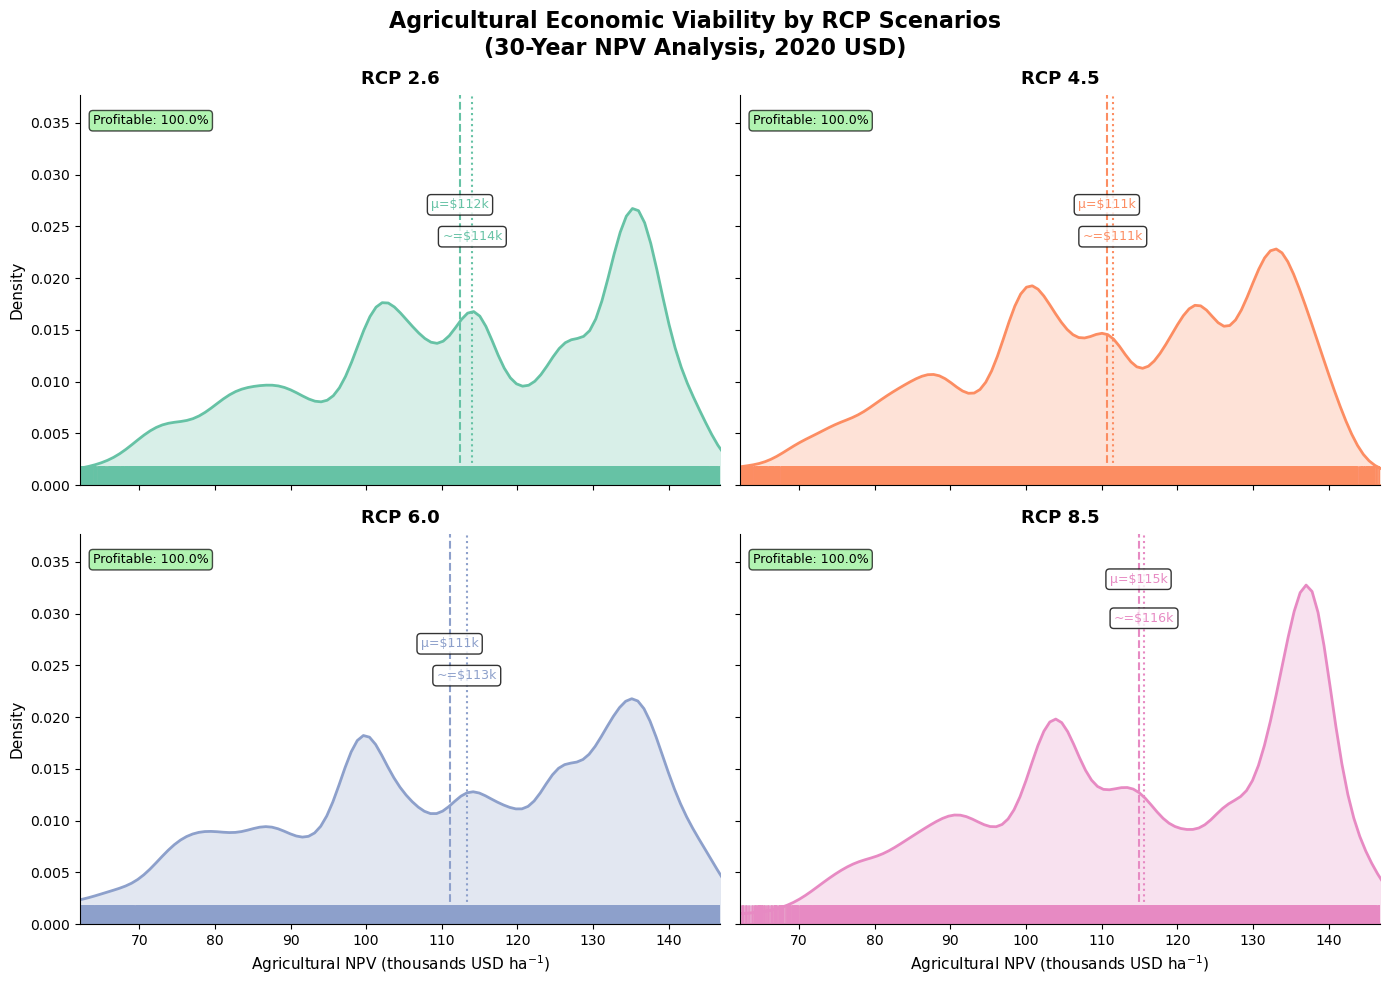

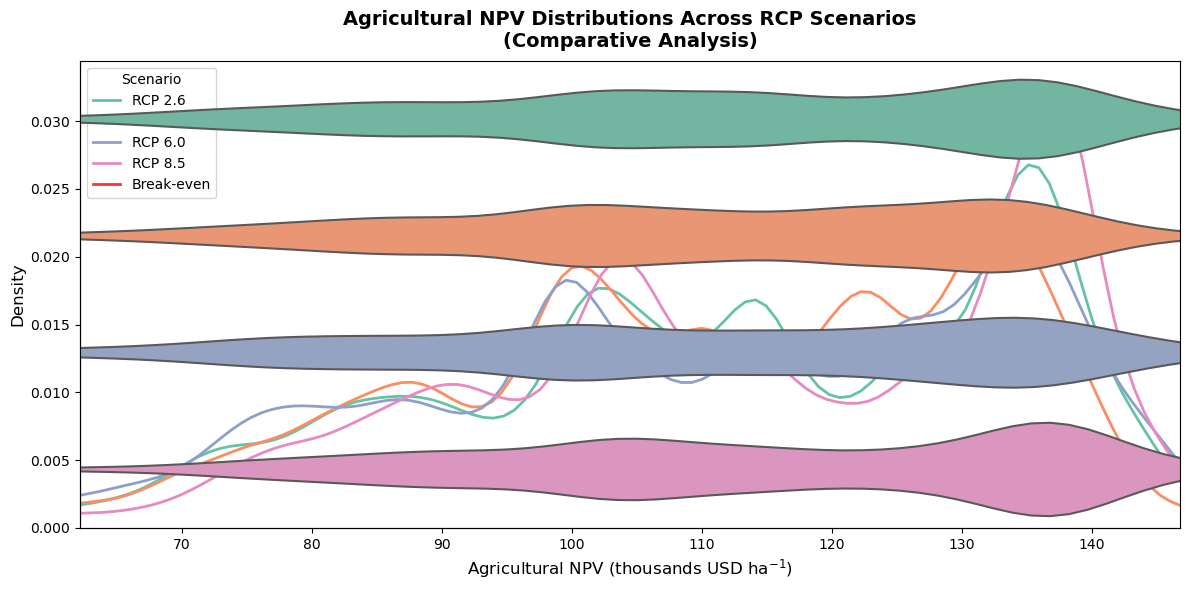

创建农业Priority空间地图...


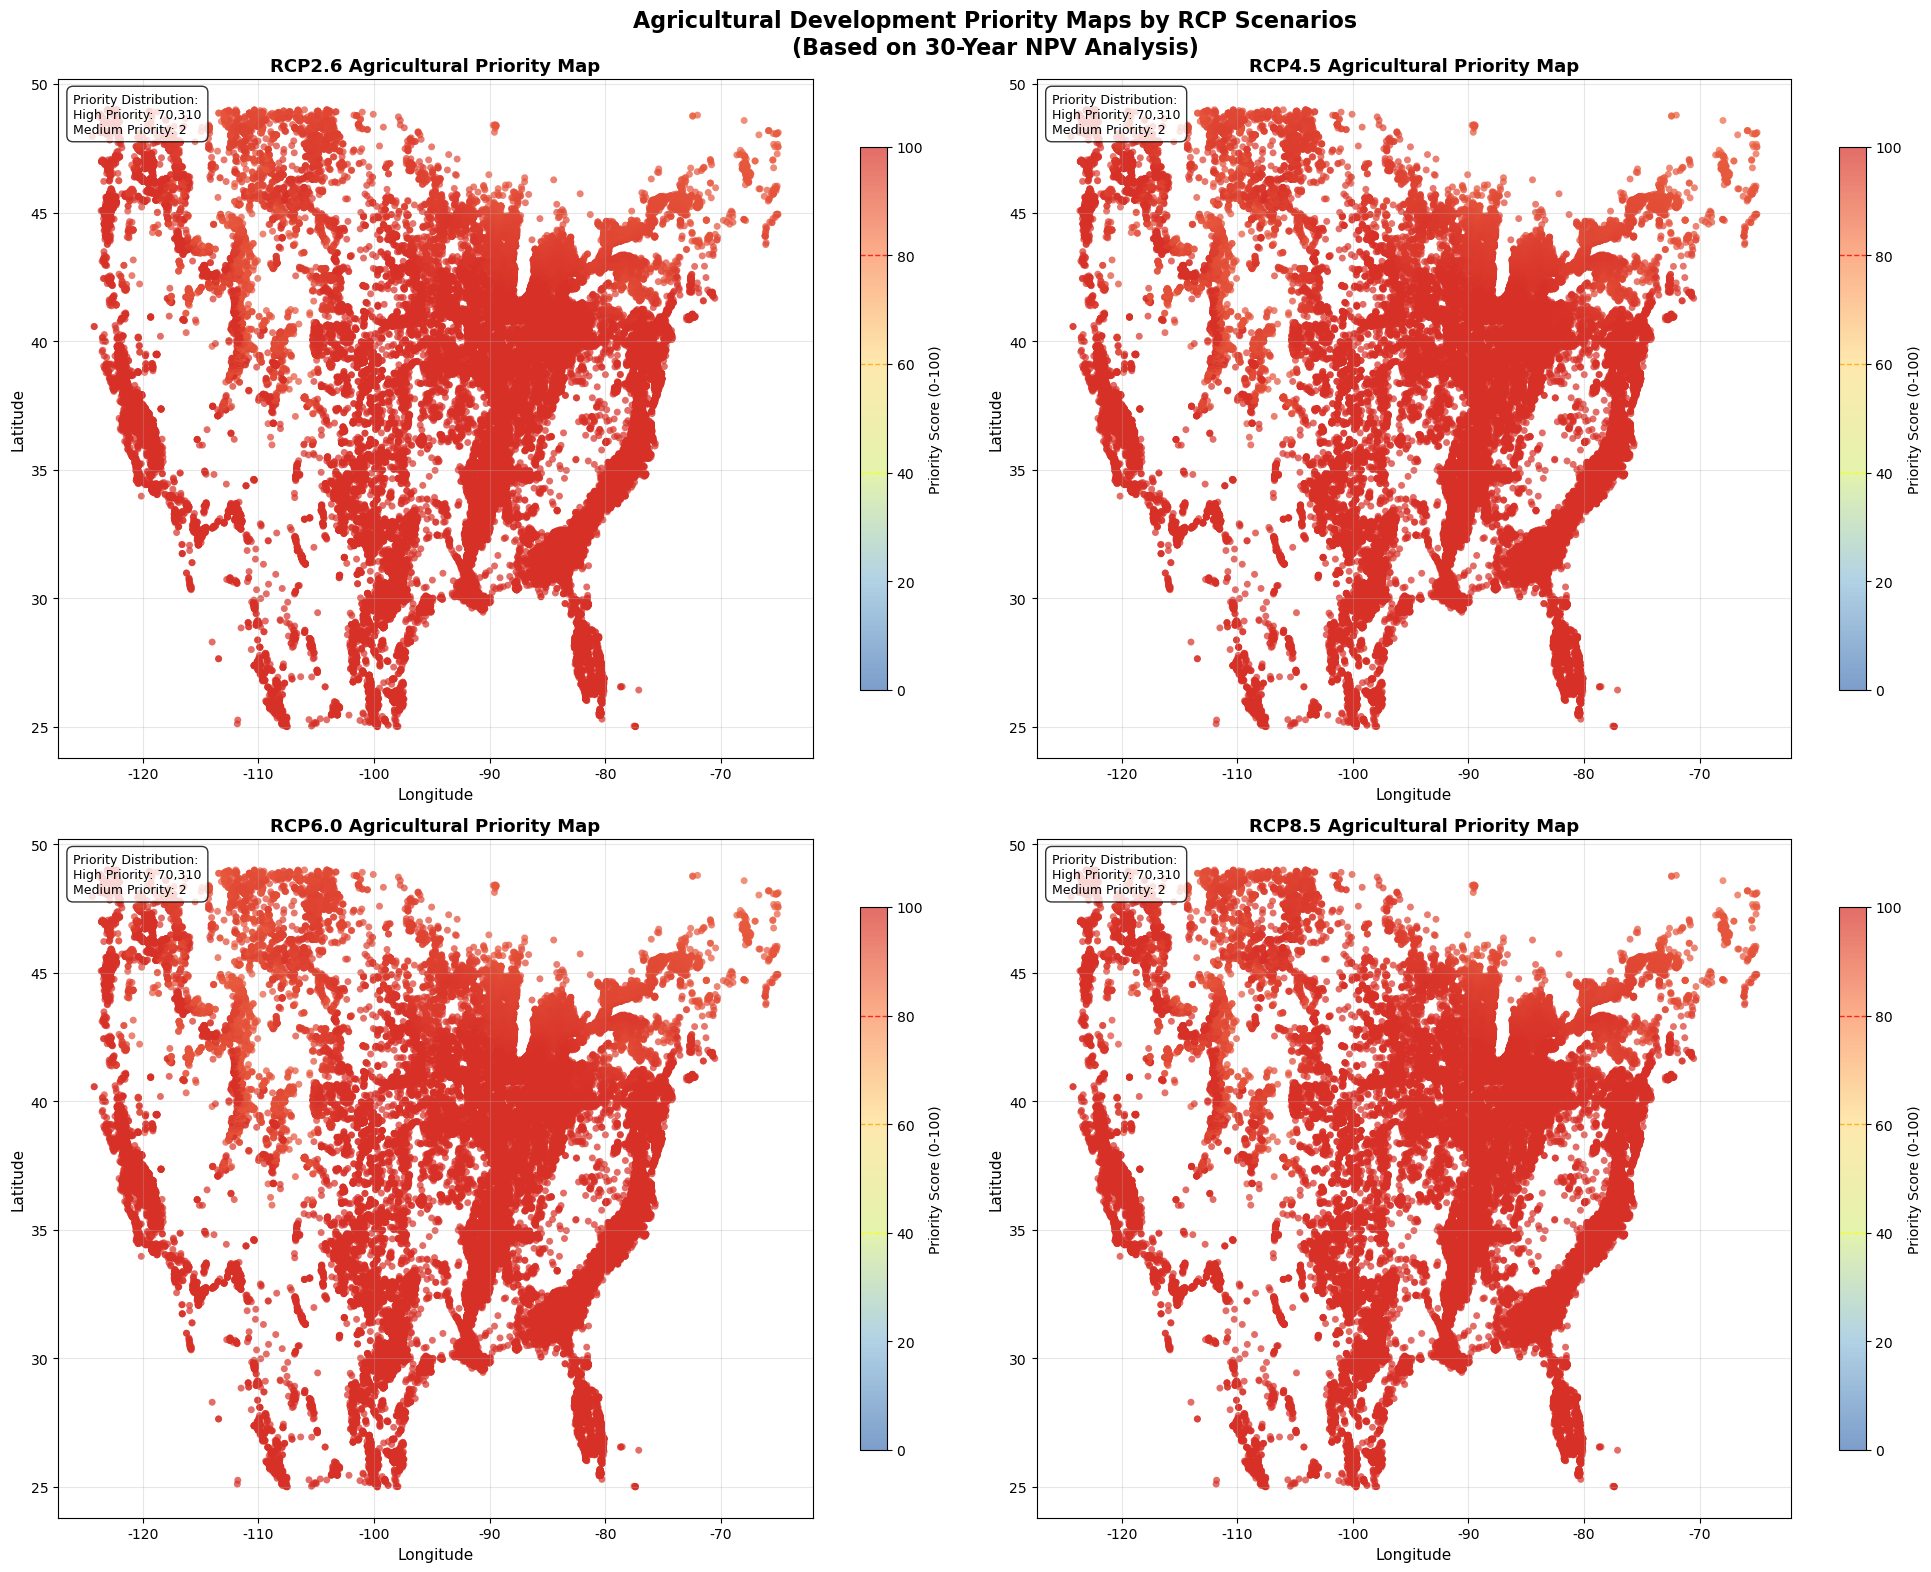

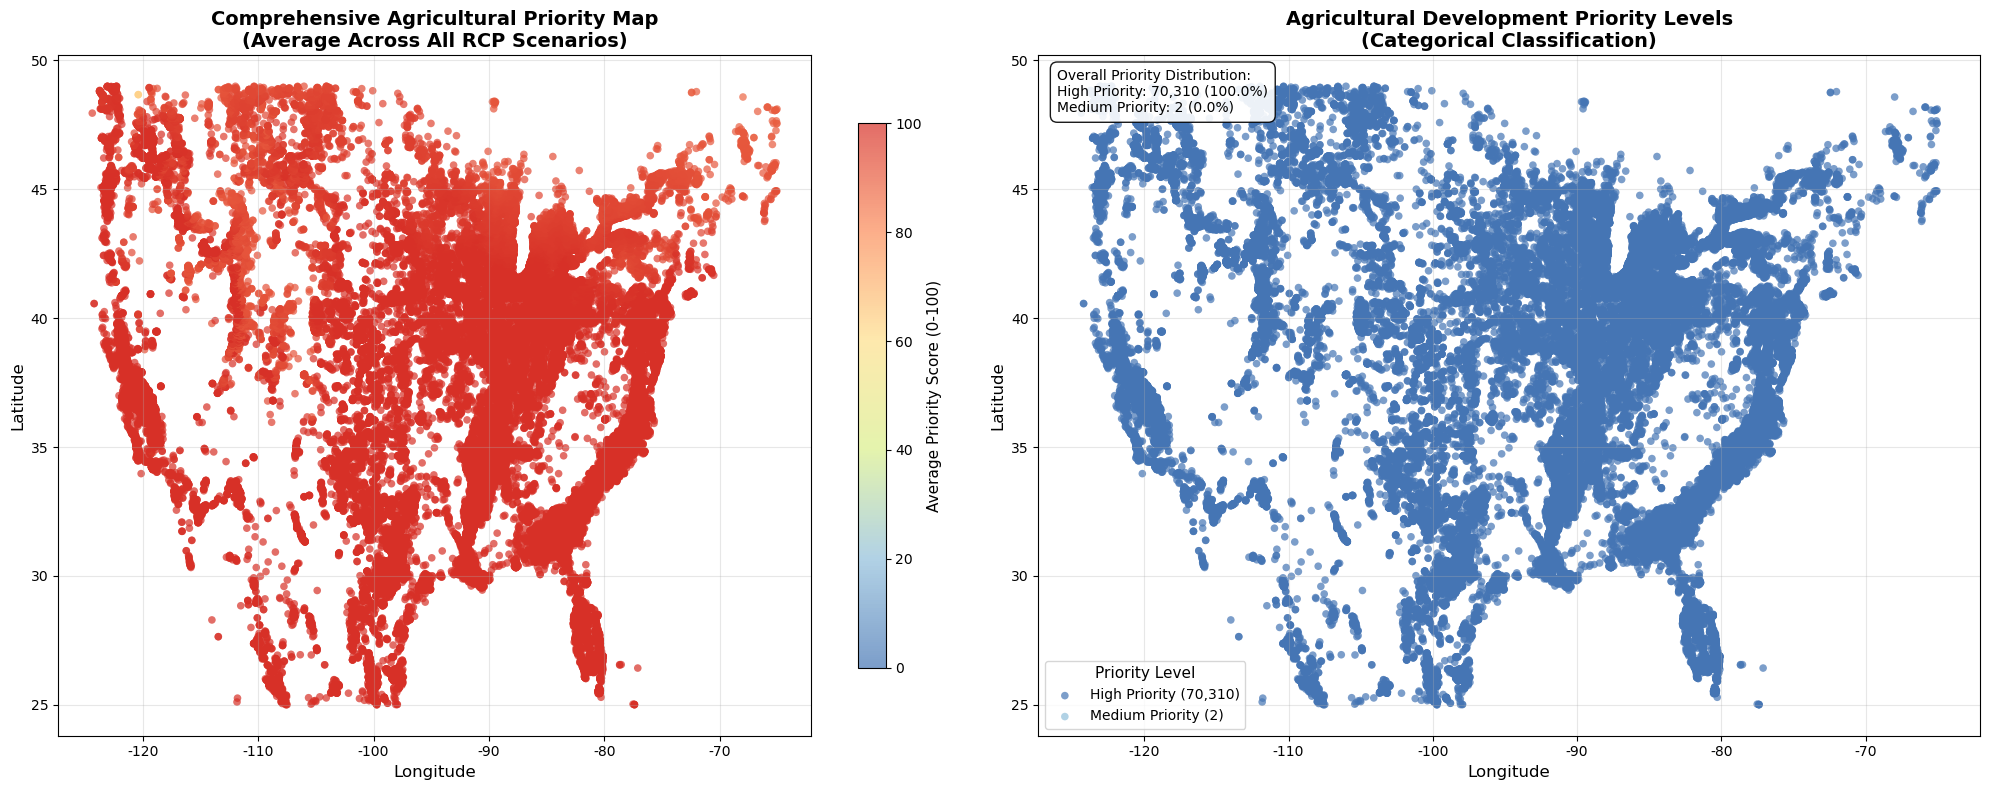

创建Priority统计摘要...


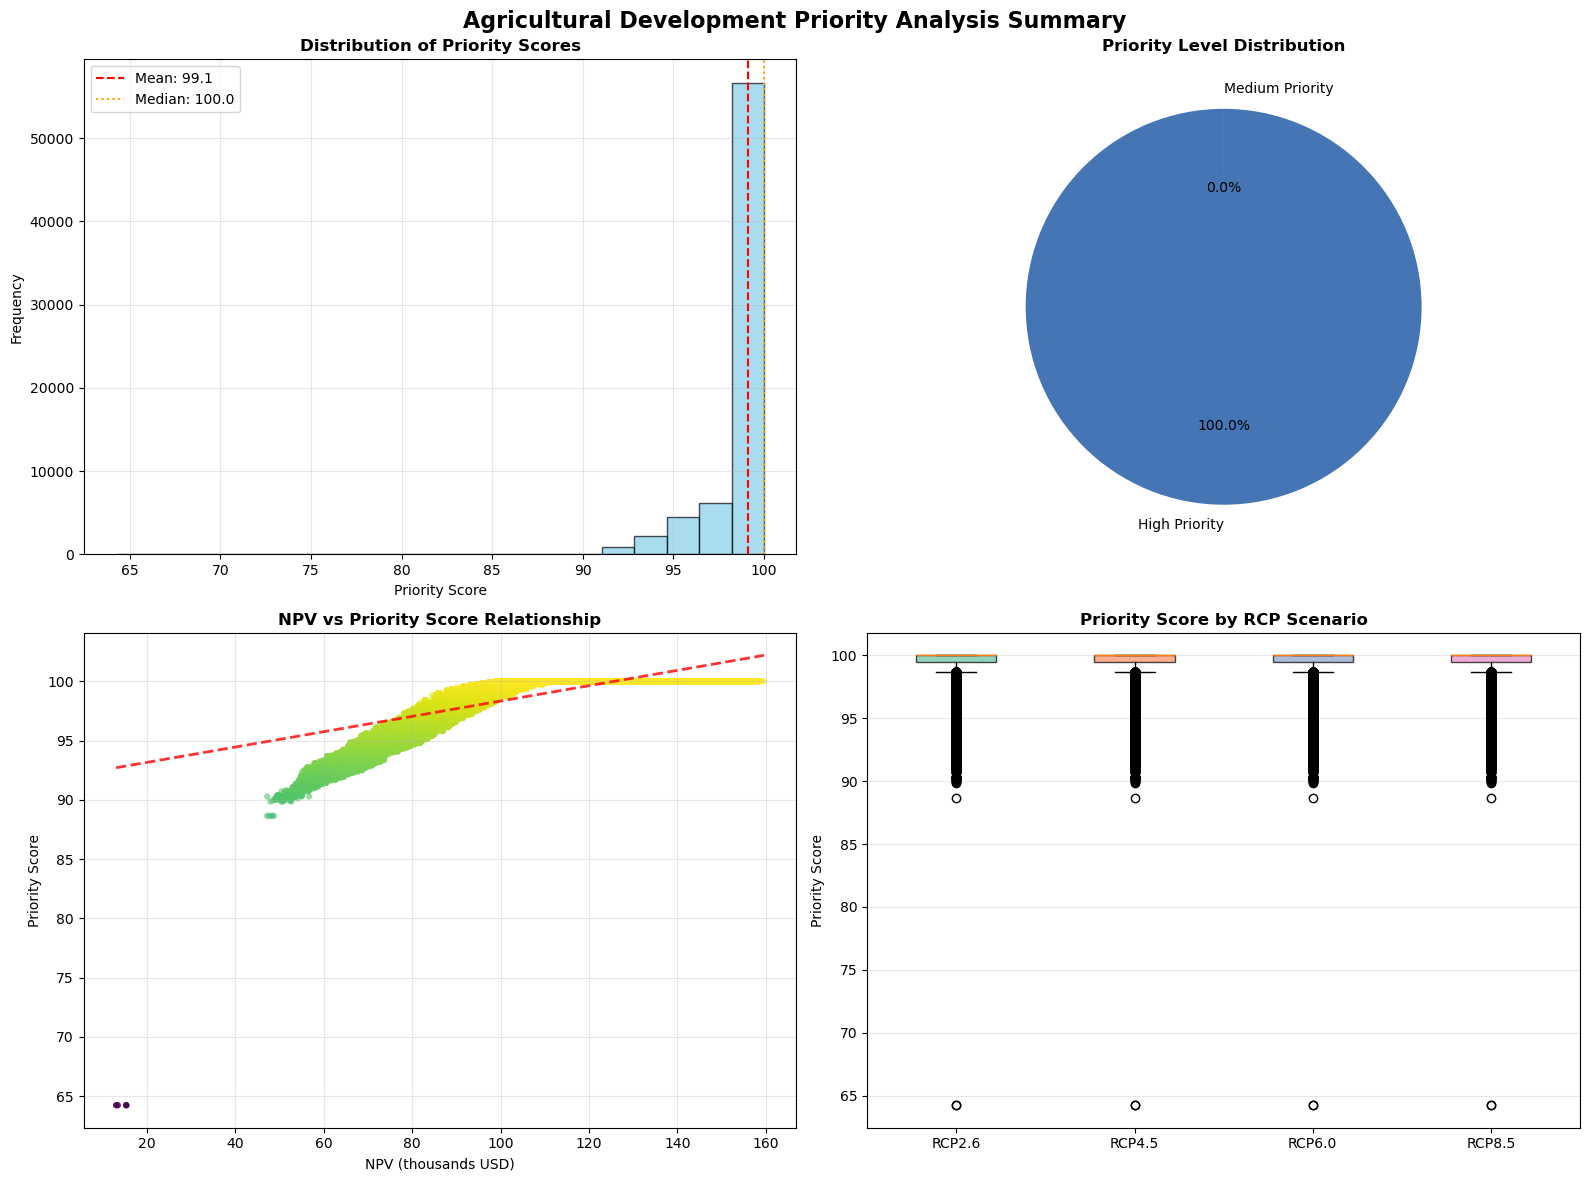


农业经济可行性可视化完成!
生成的图表:
1. 5.1_agricultural_npv_distributions.png - NPV分布（2x2子图）
2. 5.1_agricultural_npv_comparison.png - NPV对比总览
3. 5.1_agricultural_priority_maps.png - RCP Priority地图
4. 5.1_agricultural_comprehensive_priority.png - 综合Priority地图
5. 5.1_agricultural_priority_summary.png - Priority统计摘要
6. 5.1_agricultural_priority_scores.csv - Priority得分数据


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
import matplotlib.ticker as mtick
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
import geopandas as gpd
from shapely.geometry import Point

plt.rcParams["font.family"] = "DejaVu Sans"   # 避免中文标题乱码

# ========================================================================================
# 农业经济可行性可视化模块（简洁版）
# ========================================================================================

def create_agricultural_economic_visualization(df_agricultural_npv):
    """创建农业经济可行性可视化（简洁风格）"""
    
    print("创建农业经济可行性可视化...")
    
    # 使用2050年数据
    df_final = df_agricultural_npv[df_agricultural_npv['analysis_year'] == 2050].copy()
    
    # 准备RCP数据
    rcp_data = {}
    for rcp in ['RCP2.6', 'RCP4.5', 'RCP6.0', 'RCP8.5']:
        rcp_subset = df_final[df_final['RCP_Category'] == rcp]['cumulative_npv_usd'].dropna()
        rcp_data[rcp] = rcp_subset / 1000  # 转换为千美元
    
    rcp_cols = list(rcp_data.keys())
    rcp_labels = ['RCP 2.6', 'RCP 4.5', 'RCP 6.0', 'RCP 8.5']
    rcp_colors = sns.color_palette('Set2', 4)      # 柔和、易区分
    
    # 统一 x 轴范围，便于比较
    all_values = np.concatenate([data.values for data in rcp_data.values() if len(data) > 0])
    xmin, xmax = np.percentile(all_values, [1, 99])  # 使用1%和99%分位数避免极端值
    
    # ------------- 单个分布（2×2 子图）-------------
    fig1, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
    axes = axes.ravel()
    
    for ax, rcp, lab, color in zip(axes, rcp_cols, rcp_labels, rcp_colors):
        data = rcp_data[rcp].values
        
        if len(data) > 5:  # 确保有足够的数据点
            # KDE 带阴影
            sns.kdeplot(data, ax=ax, color=color, linewidth=2, fill=True, alpha=0.25)
            
            # 把原先散点改为 jitter+透明的小竖线 (rugplot)
            sns.rugplot(data, ax=ax, height=.05, color=color, alpha=0.2)
            
            # 标注均值、中位数
            mu, med = data.mean(), np.median(data)
            ax.axvline(mu,  ls='--', color=color, lw=1.5)
            ax.text(mu, ax.get_ylim()[1]*0.9, f'μ=${mu:,.0f}k', color=color,
                    ha='center', va='top', fontsize=9, 
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
            ax.axvline(med, ls=':', color=color, lw=1.5)
            ax.text(med, ax.get_ylim()[1]*0.8, f'~=${med:,.0f}k', color=color,
                    ha='center', va='top', fontsize=9,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
            
            # 添加盈亏平衡线
            ax.axvline(0, color='red', linestyle='-', linewidth=1, alpha=0.6)
            
            # 计算盈利比例
            profitable_pct = (data > 0).mean() * 100
            ax.text(0.02, 0.95, f'Profitable: {profitable_pct:.1f}%', 
                   transform=ax.transAxes, fontsize=9, va='top',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.7))
        
        ax.set_title(lab, fontsize=13, pad=8, fontweight='bold')
        ax.set_xlabel('Agricultural NPV (thousands USD ha$^{-1}$)', fontsize=11)
        ax.set_ylabel('Density', fontsize=11)
        ax.spines[['top', 'right']].set_visible(False)
        ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
        ax.set_xlim(xmin, xmax)
    
    plt.suptitle('Agricultural Economic Viability by RCP Scenarios\n(30-Year NPV Analysis, 2020 USD)', 
                 fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.savefig('data/5.1_agricultural_npv_distributions.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # ------------- 总览图（重叠 KDE）-------------
    fig2, ax2 = plt.subplots(figsize=(12, 6))
    
    # 准备数据用于violin plot
    violin_data = []
    violin_labels = []
    
    for rcp, lab, color in zip(rcp_cols, rcp_labels, rcp_colors):
        data = rcp_data[rcp]
        if len(data) > 5:
            # KDE曲线
            sns.kdeplot(data, ax=ax2, label=lab, color=color, linewidth=2)
            
            # 准备violin数据
            violin_data.extend(data.values)
            violin_labels.extend([lab] * len(data))
    
    # 创建violin数据框
    if violin_data:
        violin_df = pd.DataFrame({'NPV': violin_data, 'RCP': violin_labels})
        
        # 在同一图上添加violin（需要创建第二个y轴）
        ax2_twin = ax2.twinx()
        sns.violinplot(data=violin_df, x='NPV', y='RCP', orient='h',
                      palette=rcp_colors, bw=.2, cut=0, inner=None, 
                      ax=ax2_twin, alpha=0.15)
        ax2_twin.set_ylabel('')
        ax2_twin.set_yticks([])
    
    # 添加盈亏平衡线
    ax2.axvline(0, color='red', linestyle='-', linewidth=2, alpha=0.8, label='Break-even')
    
    ax2.set_title('Agricultural NPV Distributions Across RCP Scenarios\n(Comparative Analysis)', 
                  fontsize=14, pad=10, fontweight='bold')
    ax2.set_xlabel('Agricultural NPV (thousands USD ha$^{-1}$)', fontsize=12)
    ax2.set_ylabel('Density', fontsize=12)
    ax2.spines[['top', 'right']].set_visible(False)
    ax2.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
    ax2.legend(title='Scenario', fontsize=10)
    ax2.set_xlim(xmin, xmax)
    
    plt.tight_layout()
    plt.savefig('data/5.1_agricultural_npv_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig1, fig2

def create_agricultural_priority_maps(df_agricultural_npv):
    """创建基于地理位置的农业Priority空间地图"""
    
    print("创建农业Priority空间地图...")
    
    # 使用2050年数据
    df_final = df_agricultural_npv[df_agricultural_npv['analysis_year'] == 2050].copy()
    
    # 计算Priority指标
    def calculate_priority_score(row):
        """计算优先级得分（0-100）"""
        npv = row['cumulative_npv_usd'] / 1000  # 转换为千美元
        
        # Priority评分标准：
        # NPV > 50k: 优先级90-100
        # NPV 20-50k: 优先级70-90  
        # NPV 0-20k: 优先级50-70
        # NPV < 0: 优先级0-50
        
        if npv > 50:
            return min(100, 90 + (npv - 50) / 50 * 10)
        elif npv > 20:
            return 70 + (npv - 20) / 30 * 20
        elif npv > 0:
            return 50 + npv / 20 * 20
        else:
            return max(0, 50 + npv / 50 * 50)  # npv为负时，最低为0
    
    df_final['priority_score'] = df_final.apply(calculate_priority_score, axis=1)
    
    # 定义Priority等级
    def get_priority_level(score):
        if score >= 80:
            return 'High Priority'
        elif score >= 60:
            return 'Medium Priority'
        elif score >= 40:
            return 'Low Priority'
        else:
            return 'Not Recommended'
    
    df_final['priority_level'] = df_final['priority_score'].apply(get_priority_level)
    
    # 创建4个RCP的空间地图
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    axes = axes.ravel()
    
    # 自定义colormap
    priority_colors = ['#d73027', '#fc8d59', '#fee08b', '#d9ef8b', '#91bfdb', '#4575b4']
    priority_cmap = LinearSegmentedColormap.from_list('priority', priority_colors[::-1])
    
    for ax, rcp in zip(axes, ['RCP2.6', 'RCP4.5', 'RCP6.0', 'RCP8.5']):
        rcp_data = df_final[df_final['RCP_Category'] == rcp].copy()
        
        if len(rcp_data) > 0:
            # 创建散点图
            scatter = ax.scatter(rcp_data['lon'], rcp_data['lat'], 
                               c=rcp_data['priority_score'], 
                               cmap=priority_cmap, s=25, alpha=0.7, 
                               vmin=0, vmax=100, edgecolors='none')
            
            # 添加colorbar
            cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
            cbar.set_label('Priority Score (0-100)', fontsize=10)
            
            # 添加优先级等级边界线
            cbar.ax.axhline(y=80, color='red', linestyle='--', linewidth=1, alpha=0.8)
            cbar.ax.axhline(y=60, color='orange', linestyle='--', linewidth=1, alpha=0.8)
            cbar.ax.axhline(y=40, color='yellow', linestyle='--', linewidth=1, alpha=0.8)
            
            # 统计各优先级区域
            priority_stats = rcp_data['priority_level'].value_counts()
            stats_text = '\n'.join([f'{level}: {count:,}' for level, count in priority_stats.items()])
            
            ax.text(0.02, 0.98, f'Priority Distribution:\n{stats_text}', 
                   transform=ax.transAxes, fontsize=9, va='top',
                   bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))
        
        ax.set_title(f'{rcp} Agricultural Priority Map', fontsize=13, fontweight='bold')
        ax.set_xlabel('Longitude', fontsize=11)
        ax.set_ylabel('Latitude', fontsize=11)
        ax.grid(True, alpha=0.3)
        
        # 设置坐标轴范围
        if len(rcp_data) > 0:
            lon_margin = (rcp_data['lon'].max() - rcp_data['lon'].min()) * 0.05
            lat_margin = (rcp_data['lat'].max() - rcp_data['lat'].min()) * 0.05
            ax.set_xlim(rcp_data['lon'].min() - lon_margin, rcp_data['lon'].max() + lon_margin)
            ax.set_ylim(rcp_data['lat'].min() - lat_margin, rcp_data['lat'].max() + lat_margin)
    
    plt.suptitle('Agricultural Development Priority Maps by RCP Scenarios\n(Based on 30-Year NPV Analysis)', 
                 fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.savefig('data/5.1_agricultural_priority_maps.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 创建综合Priority地图（所有RCP平均）
    fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # 计算每个像素点的平均Priority
    pixel_priority = df_final.groupby(['pixel_id', 'lat', 'lon'])['priority_score'].mean().reset_index()
    pixel_priority['priority_level'] = pixel_priority['priority_score'].apply(get_priority_level)
    
    # 左图：连续Priority Score
    scatter1 = ax1.scatter(pixel_priority['lon'], pixel_priority['lat'], 
                          c=pixel_priority['priority_score'], 
                          cmap=priority_cmap, s=30, alpha=0.7, 
                          vmin=0, vmax=100, edgecolors='none')
    
    cbar1 = plt.colorbar(scatter1, ax=ax1, shrink=0.8)
    cbar1.set_label('Average Priority Score (0-100)', fontsize=11)
    
    ax1.set_title('Comprehensive Agricultural Priority Map\n(Average Across All RCP Scenarios)', 
                  fontsize=14, fontweight='bold')
    ax1.set_xlabel('Longitude', fontsize=12)
    ax1.set_ylabel('Latitude', fontsize=12)
    ax1.grid(True, alpha=0.3)
    
    # 右图：离散Priority Level
    level_colors = {'High Priority': '#4575b4', 'Medium Priority': '#91bfdb', 
                   'Low Priority': '#fee08b', 'Not Recommended': '#d73027'}
    
    for level, color in level_colors.items():
        level_data = pixel_priority[pixel_priority['priority_level'] == level]
        if len(level_data) > 0:
            ax2.scatter(level_data['lon'], level_data['lat'], 
                       c=color, label=f'{level} ({len(level_data):,})', 
                       s=30, alpha=0.7, edgecolors='none')
    
    ax2.set_title('Agricultural Development Priority Levels\n(Categorical Classification)', 
                  fontsize=14, fontweight='bold')
    ax2.set_xlabel('Longitude', fontsize=12)
    ax2.set_ylabel('Latitude', fontsize=12)
    ax2.legend(title='Priority Level', fontsize=10, title_fontsize=11)
    ax2.grid(True, alpha=0.3)
    
    # 添加总体统计
    overall_stats = pixel_priority['priority_level'].value_counts()
    total_pixels = len(pixel_priority)
    stats_text = 'Overall Priority Distribution:\n' + '\n'.join([
        f'{level}: {count:,} ({count/total_pixels*100:.1f}%)' 
        for level, count in overall_stats.items()
    ])
    
    ax2.text(0.02, 0.98, stats_text, transform=ax2.transAxes, fontsize=10, va='top',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9))
    
    plt.tight_layout()
    plt.savefig('data/5.1_agricultural_comprehensive_priority.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 保存Priority数据
    pixel_priority.to_csv('data/5.1_agricultural_priority_scores.csv', index=False)
    
    return fig, fig2, pixel_priority

def create_priority_statistics_summary(df_agricultural_npv, pixel_priority):
    """创建Priority统计摘要"""
    
    print("创建Priority统计摘要...")
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # 图1: Priority Score分布直方图
    ax1.hist(pixel_priority['priority_score'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.axvline(pixel_priority['priority_score'].mean(), color='red', linestyle='--', 
               label=f'Mean: {pixel_priority["priority_score"].mean():.1f}')
    ax1.axvline(pixel_priority['priority_score'].median(), color='orange', linestyle=':', 
               label=f'Median: {pixel_priority["priority_score"].median():.1f}')
    ax1.set_xlabel('Priority Score')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Distribution of Priority Scores', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 图2: Priority Level饼图
    level_counts = pixel_priority['priority_level'].value_counts()
    colors = ['#4575b4', '#91bfdb', '#fee08b', '#d73027']
    wedges, texts, autotexts = ax2.pie(level_counts.values, labels=level_counts.index, 
                                      colors=colors, autopct='%1.1f%%', startangle=90)
    ax2.set_title('Priority Level Distribution', fontweight='bold')
    
    # 图3: NPV vs Priority Score散点图
    df_2050 = df_agricultural_npv[df_agricultural_npv['analysis_year'] == 2050]
    merged_data = df_2050.merge(pixel_priority[['pixel_id', 'priority_score']], on='pixel_id', how='inner')
    
    scatter = ax3.scatter(merged_data['cumulative_npv_usd']/1000, merged_data['priority_score'], 
                         alpha=0.6, s=20, c=merged_data['priority_score'], 
                         cmap='viridis', edgecolors='none')
    ax3.set_xlabel('NPV (thousands USD)')
    ax3.set_ylabel('Priority Score')
    ax3.set_title('NPV vs Priority Score Relationship', fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    # 添加拟合线
    if len(merged_data) > 1:
        z = np.polyfit(merged_data['cumulative_npv_usd']/1000, merged_data['priority_score'], 1)
        p = np.poly1d(z)
        x_range = np.linspace(merged_data['cumulative_npv_usd'].min()/1000, 
                             merged_data['cumulative_npv_usd'].max()/1000, 100)
        ax3.plot(x_range, p(x_range), "r--", alpha=0.8, linewidth=2)
    
    # 图4: 各RCP的Priority比较
    rcp_priority_data = []
    rcp_labels = []
    
    for rcp in ['RCP2.6', 'RCP4.5', 'RCP6.0', 'RCP8.5']:
        rcp_data = df_2050[df_2050['RCP_Category'] == rcp]
        rcp_merged = rcp_data.merge(pixel_priority[['pixel_id', 'priority_score']], on='pixel_id', how='inner')
        if len(rcp_merged) > 0:
            rcp_priority_data.append(rcp_merged['priority_score'].values)
            rcp_labels.append(rcp)
    
    if rcp_priority_data:
        bp = ax4.boxplot(rcp_priority_data, labels=rcp_labels, patch_artist=True)
        colors = sns.color_palette('Set2', len(rcp_labels))
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
    
    ax4.set_ylabel('Priority Score')
    ax4.set_title('Priority Score by RCP Scenario', fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle('Agricultural Development Priority Analysis Summary', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('data/5.1_agricultural_priority_summary.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

# ========================================================================================
# 执行农业可视化
# ========================================================================================

print("\n" + "="*70)
print("农业经济可行性可视化模块（简洁版 + Priority地图）")
print("="*70)

# 创建NPV分布图
fig1, fig2 = create_agricultural_economic_visualization(df_agricultural_npv)

# 创建Priority地图
fig3, fig4, pixel_priority = create_agricultural_priority_maps(df_agricultural_npv)

# 创建Priority统计摘要
fig5 = create_priority_statistics_summary(df_agricultural_npv, pixel_priority)


# 5.3 复林策略经济净收益

（原文的数据仅仅是中低收入国家，需要创建一个学生模型对于收入进行修正（根据文献，根据国家GDP总量/人均GDP/人口三个要素进行矫正几个），目前版本主要使用的是邻近差值）

根据林木产品类型，计算AGB地表碳×留碳因子×利润因子
1. **贴现因子（每年）**  
$d_t = (1 - \delta)^t$
2. **贴现因子之和（分母）**  
$D = \sum_{t=1}^{y} d_t$
3. **衰减因子（用途 u 半衰期 \(t_{1/2}^u\)）**  
$
\text{decay}_u(t) = 2^{-\,t / t_{1/2}^u}
$

4. **用途 u 的贴现后残存碳（分子）**  
$
N_u = \sum_{t=1}^{y} \bigl[\text{decay}_u(t)\times d_t\bigr]
$

5. **碳留存率 \(\omega\)（公式 (6)）**  
$
\omega 
= \frac{1}{\mathrm{BEF}}
\sum_{u\in U}
\frac{N_u}{D}
$

6. **每 tC 生物量碳的市场利润 \(\rho\)（公式 (7)）**  
$
\rho
= \frac{1}{\mathrm{BEF}\times\mathrm{CF}}
\sum_{u\in U} \alpha_u\,p_u
$

7. **单位面积当年木材收益**  
$
\text{revenue}_{\mathrm{ha}}
= C_{\rm harvest}\;\times\;\omega\;\times\;\rho
$

8. **贴现到基准年的 NPV**  
$
\mathrm{NPV}_{\mathrm{ha}}
= \frac{\text{revenue}_{\mathrm{ha}}}{(1 + \delta)^{y}}
$


In [15]:
df_strategies = pd.read_csv(r'data\4.1 Restoration_strategy_data.csv')
df_strategies

Unnamed: 0.1  Unnamed: 0        time        lat         lon  \
0                 0        2094  2020-01-01  25.004168 -107.545830   
1             12032     6250533  2020-01-01  25.004168  -99.720830   
2             12033     6250534  2020-01-01  25.004168  -99.712500   
3             50356    12500713  2020-01-01  25.004168  -77.387500   
4                 1        4586  2020-01-01  25.012500 -107.612500   
...             ...         ...         ...        ...         ...   
70307         69686    18949063  2020-01-01  48.995834 -111.970830   
70308         69687    18949258  2020-01-01  48.995834 -110.345830   
70309         69688    18949777  2020-01-01  48.995834 -106.020836   
70310         70137    19897509  2020-01-01  48.995834 -104.087500   
70311         70138    19897510  2020-01-01  48.995834 -104.079170   

       abandonment_year  abandonment_duration  current_abandonment  landcover  \
0                2018.0                   6.0                    1        2.0   
1                2005.0                  19.0                    1        2.0   
2                2003.0                  21.0                    1        2.0   
3                2010.0                  14.0                    1        2.0   
4                2017.0                   7.0                    1        2.0   
...                 ...                   ...                  ...        ...   
70307            1999.0                  25.0                    1        2.0   
70308            2017.0                   6.0                    1        2.0   
70309            2008.0                  16.0                    1        2.0   
70310            2014.0                  10.0                    1        3.0   
70311            2014.0                  10.0                    1        2.0   

             DEM  ...  acc_soc_agro  acc_perennial    acc_agro  cap_agro  \
0       128.7500  ...     141.05145            0.0  141.051453     151.0   
1       464.8750  ...     205.88930            0.0  205.889297     218.0   
2       458.0625  ...     205.88930            0.0  205.889297     218.0   
3         6.6250  ...     577.34784            0.0  577.347839     617.0   
4        96.3125  ...     140.07867            0.0  140.078674     149.0   
...          ...  ...           ...            ...         ...       ...   
70307  1085.7500  ...     170.48401            0.0  170.484009     179.0   
70308   882.2500  ...     175.66588            0.0  175.665878     197.0   
70309   901.2500  ...     209.71559            0.0  209.715591     206.0   
70310   669.7500  ...     204.50893            0.0  204.508926     222.0   
70311   667.1250  ...     204.54327            0.0  204.543274     222.0   

       final_agro  acc_soc_veg  acc_bio_veg    acc_veg  cap_veg  final_veg  
0      141.051453    141.05145     7.619476  148.67093    190.0  148.67093  
1      205.889297    205.88930    35.221370  241.11067    250.0  241.11067  
2      205.889297    205.88930    33.620400  239.50970    247.0  239.50970  
3      577.347839    577.34784    28.566105  605.91394    684.0  605.91394  
4      140.078674    140.07867     9.143371  149.22205    197.0  149.22205  
...           ...          ...          ...        ...      ...        ...  
70307  170.484009    170.48401     3.720865  174.20488    182.0  174.20488  
70308  175.665878    175.66588     1.856442  177.52232    198.0  177.52232  
70309  206.000000    209.71559     1.866471  211.58206    207.0  207.00000  
70310  204.508926    204.50893     3.106193  207.61511    225.0  207.61511  
70311  204.543274    204.54327     3.716709  208.25998    225.0  208.25998  

[70312 rows x 84 columns]

### 1、成本数据提取与插值处理

In [ ]:
import pandas as pd
import numpy as np
import xarray as xr
from scipy.spatial import cKDTree
from tqdm.auto import tqdm

# ========================================================================================
# 1. 参数设置 - 与农业策略对齐
# ========================================================================================

# 项目参数设置（与农业策略一致）
PROJECT_START_YEAR = 2020
PROJECT_LIFETIME = 30
TARGET_YEARS = [2020, 2030, 2040, 2050]  
DISCOUNT_RATE = 0.05  # 5% 贴现率

# 复林特定参数
YEARS = 30              # 项目期间（2020-2050）
half_lives = {
    'bioenergy':   0,   # 半衰期 0 年 → 当年全部释放/使用
    'paper_pulp':  2,   # 纸浆/纸品：2 年半衰期
    'solid_wood': 30,   # 锯材：30 年半衰期
}
δ = DISCOUNT_RATE       # 年贴现率
y = 30                  # 期数（2020–2050）
BEF = 1.3               # biomass→products 扩展因子
CF = 0.26               # 碳因子 tC/m³
alpha = np.array([0.2, 0.3, 0.5])  # 不同用途比例
prices = np.array([3.46, 18.0, 38.0])  # 不同用途价格 US$/m³

# RCP情景设置（保留接口，复林策略暂时不区分RCP）
RCP_SCENARIOS = ['RCP2.6', 'RCP4.5', 'RCP6.0', 'RCP8.5']
DEFAULT_RCP = None  # 默认RCP情景，复林策略当前不区分

print("="*80)
print("复林策略NPV时间序列计算（与农业策略对齐）")
print("="*80)
print(f"项目参数设置:")
print(f"  项目期间: {YEARS} 年 ({PROJECT_START_YEAR}-{PROJECT_START_YEAR + PROJECT_LIFETIME})")
print(f"  分析时间点: {TARGET_YEARS}")
print(f"  贴现率: {DISCOUNT_RATE*100}%")
print(f"  生物量扩展因子: {BEF}")
print(f"  注意: 复林策略暂不区分RCP情景，保留接口供后续扩展")

# ========================================================================================
# 2. 数据加载
# ========================================================================================

print("\n1. 加载复林基础数据...")
df_strategies = pd.read_csv(r'data\4.1 Restoration_strategy_data.csv')
df = df_strategies.copy()

print(f"加载复林数据：{len(df)} 个像素点")

# ========================================================================================
# 3. 计算复林收益系数
# ========================================================================================

print("\n2. 计算复林收益系数...")

# 预先计算贴现因子和衰减因子
years = np.arange(1, y+1)
disc_factors = (1 - δ) ** years  # 贴现因子
disc_sum = disc_factors.sum()

# 计算每种用途的"留存率"分子合计
omega_components = {}
for use, t_half in half_lives.items():
    if t_half == 0:
        # 半衰期 0：所有碳当年释放
        decay = np.ones_like(years, dtype=float)
    else:
        # 衰减因子 2^(–t/t_half)
        decay = 2 ** (-years / t_half)
    # 贴现后残存
    omega_components[use] = (decay * disc_factors).sum()

# 组合三种用途，计算ω
omega = sum(omega_components.values()) / (BEF * disc_sum)

# 计算单位收益率ρ
rho = (alpha * prices).sum() / (BEF * CF)  # US$ / tC

print(f"收益系数计算完成:")
print(f"  ω (留存率): {omega:.4f}")
print(f"  ρ (单位收益): {rho:.2f} US$/tC")

# ========================================================================================
# 4. 提取复林成本数据
# ========================================================================================

print("\n3. 提取复林成本数据...")

# 设置坐标索引
if 'lat' in df.columns and 'lon' in df.columns:
    df_indexed = df.set_index(['lat', 'lon'])
else:
    print("错误: 数据中缺少lat/lon列")
    raise ValueError("缺少必要的坐标列")

# 加载成本数据
implementation_cost = xr.open_dataset(r'D:\xarray\aligned2\economic_cost\afforestation_cost\03_implementation_cost.nc')

def extract_with_fast_nearest_fill_multi(ds, target_coords, variable_names):
    """快速提取多个变量数据，使用最近邻有效值填充缺失值"""
    
    print(f"提取变量: {variable_names}")
    results = {}
    
    for var_name in variable_names:
        print(f"  处理变量: {var_name}")
        
        # 提取变量数据
        data_var = ds[var_name]
        if len(data_var.dims) == 3:
            data_values = data_var.isel(time=0).values
        else:
            data_values = data_var.values
        
        # 找到有效数据点
        valid_mask = ~np.isnan(data_values)
        
        if not valid_mask.any():
            print(f"   警告: {var_name} 中没有有效数据")
            results[var_name] = np.full(len(target_coords), np.nan)
            continue
        
        # 构建有效坐标数组
        lat_grid, lon_grid = np.meshgrid(data_var.lat.values, data_var.lon.values, indexing='ij')
        valid_coords = np.column_stack([
            lat_grid[valid_mask], 
            lon_grid[valid_mask]
        ])
        valid_values = data_values[valid_mask]
        
        print(f"   找到 {len(valid_values)} 个有效数据点")
        
        # 构建KD树并查询
        tree = cKDTree(valid_coords)
        target_coords_array = np.array(target_coords)
        distances, indices = tree.query(target_coords_array, k=1, workers=-1)
        
        # 获取结果
        result_values = valid_values[indices]
        results[var_name] = result_values
        
        print(f"   {var_name}成功提取，平均距离: {distances.mean():.6f}°")
    
    return results

# 提取坐标
target_coords = list(zip(
    df_indexed.index.get_level_values('lat'), 
    df_indexed.index.get_level_values('lon')
))

# 提取成本数据
variable_names = ['native', 'exotic', 'natRegen']
cost_results = extract_with_fast_nearest_fill_multi(
    implementation_cost, 
    target_coords, 
    variable_names
)

# 计算恢复成本类型的均值
cost_results['average'] = (cost_results['native'] + cost_results['exotic'] ) / 2

# 添加成本数据到DataFrame
cost_types = ['native', 'exotic', 'average']
for cost_type in cost_types:
    df_indexed[f'afforestation_cost_per_ha_{cost_type}'] = cost_results[cost_type]

print("成本数据提取完成!")

复林策略NPV时间序列计算（与农业策略对齐）
项目参数设置:
  项目期间: 30 年 (2020-2050)
  分析时间点: [2020, 2030, 2040, 2050]
  贴现率: 5.0%
  生物量扩展因子: 1.3
  注意: 复林策略暂不区分RCP情景，保留接口供后续扩展

1. 加载复林基础数据...
加载复林数据：70312 个像素点

2. 计算复林收益系数...
收益系数计算完成:
  ω (留存率): 1.4705
  ρ (单位收益): 74.24 US$/tC

3. 提取复林成本数据...
提取变量: ['native', 'exotic', 'natRegen']
  处理变量: native
   找到 103698121 个有效数据点
   native成功提取，平均距离: 11.670872°
  处理变量: exotic
   找到 103698121 个有效数据点
   exotic成功提取，平均距离: 11.670872°
  处理变量: natRegen
   找到 103698121 个有效数据点
   natRegen成功提取，平均距离: 11.670872°
成本数据提取完成!


### 2、复林计算模块

In [9]:
# ========================================================================================
# 5. 计算复林基础数据
# ========================================================================================

print("\n4. 计算复林基础数据...")

# 计算基础数据
df_indexed['final_AGB'] = np.minimum(
    df_indexed['Base_Pot_AGB_MgCha_500m'], 
    df_indexed['sequestration'] * YEARS
)

# 计算木材产品和收益
df_indexed['omega'] = omega
df_indexed['carbon_in_products'] = df_indexed['final_AGB'] * omega
df_indexed['total_wood_revenue'] = df_indexed['carbon_in_products'] * rho

# 使用average成本作为初始投资
df_indexed['initial_investment_per_ha'] = df_indexed['afforestation_cost_per_ha_average']

# 贴现到第30年的收益
df_indexed['wood_profit_discounted'] = df_indexed['total_wood_revenue'] / ((1 + DISCOUNT_RATE) ** 30)

# ========================================================================================
# 6. 计算复林NPV时间序列（与农业策略对齐）
# ========================================================================================

def calculate_afforestation_npv_for_year(row, project_year, rcp_scenario=None, discount_rate=DISCOUNT_RATE):
    """
    计算复林NPV（修正版本 - 确保累积成本不变）
    
    逻辑：
    - 第0年：支付所有初始投资
    - 第1-29年：无额外成本和收益
    - 第30年：收获木材获得收益
    - 累积成本在整个期间保持不变（只有初始投资）
    """
    
    # 基础数据
    total_wood_revenue = row['total_wood_revenue']
    initial_investment = row['initial_investment_per_ha']
    
    # 从项目开始年到指定年份的年数
    years_from_start = project_year - PROJECT_START_YEAR
    
    if years_from_start < 0:
        return {
            'annual_total_revenue_usd': 0.0,
            'annual_net_revenue_usd': 0.0,
            'annual_cost_usd': 0.0,
            'initial_investment_usd': initial_investment,
            'cumulative_npv_usd': -initial_investment,
            'cumulative_cost_usd': initial_investment,  # 只有初始投资
            'project_year': project_year,
            'years_from_start': years_from_start,
            'rcp_category': rcp_scenario
        }
    
    # 累积成本：在整个项目期间保持不变（只有初始投资）
    cumulative_cost = initial_investment
    
    # 累积NPV计算
    cumulative_npv = -initial_investment  # 第0年的初始投资
    
    # 如果项目年份 >= 2050年（第30年），则加入木材收益
    if years_from_start >= 30:
        # 第30年的贴现收益
        discounted_revenue = total_wood_revenue / ((1 + discount_rate) ** 30)
        cumulative_npv += discounted_revenue
        
        # 年化数据（用于报告，不影响累积计算）
        annual_total_revenue = total_wood_revenue / PROJECT_LIFETIME
        annual_net_revenue = annual_total_revenue
        annual_cost = 0.0  # 复林策略无年度运营成本
    else:
        # 还未到收益年份
        annual_total_revenue = 0.0
        annual_net_revenue = 0.0
        annual_cost = 0.0
    
    return {
        'annual_total_revenue_usd': annual_total_revenue,
        'annual_net_revenue_usd': annual_net_revenue,
        'annual_cost_usd': annual_cost,
        'initial_investment_usd': initial_investment,
        'cumulative_npv_usd': cumulative_npv,
        'cumulative_cost_usd': cumulative_cost,  # 保持不变！
        'project_year': project_year,
        'years_from_start': years_from_start,
        'rcp_category': rcp_scenario
    }

print("5. 计算复林NPV时间序列...")

afforestation_npv_results = []

# 对每个像素点计算
for idx, (coords, row) in enumerate(tqdm(df_indexed.iterrows(), total=len(df_indexed), desc="计算复林NPV")):
    lat, lon = coords
    
    # 但实际上复林策略不区分RCP，所以所有RCP的值都相同
    for rcp in RCP_SCENARIOS:
        # 对每个分析年份计算NPV
        for analysis_year in TARGET_YEARS:
            
            # 计算复林NPV（所有RCP情景使用相同的计算逻辑）
            npv_calc = calculate_afforestation_npv_for_year(
                row, analysis_year, rcp
            )
            
            # 保存结果
            afforestation_npv_results.append({
                'pixel_id': idx,
                'lat': lat,
                'lon': lon,
                **npv_calc
            })

# 转换为DataFrame
df_afforestation_npv = pd.DataFrame(afforestation_npv_results)

print("6. 计算汇总统计...")

# 按RCP和年份计算汇总统计（与农业策略相同格式）
afforestation_summary = df_afforestation_npv.groupby(['rcp_category', 'project_year']).agg({
    'cumulative_npv_usd': ['mean', 'std', 'count', 'min', 'max'],
    'cumulative_cost_usd': ['mean', 'std', 'count', 'min', 'max'],
    'annual_total_revenue_usd': ['mean', 'std'],
    'annual_net_revenue_usd': ['mean', 'std'],
    'annual_cost_usd': ['mean', 'std']
}).reset_index()

# 展平列名
afforestation_summary.columns = ['_'.join(col).strip() if col[1] else col[0] 
                                for col in afforestation_summary.columns.values]

# 计算成本效益比
afforestation_summary['cost_benefit_ratio'] = (
    afforestation_summary['cumulative_cost_usd_mean'] / 
    (afforestation_summary['cumulative_npv_usd_mean'] + afforestation_summary['cumulative_cost_usd_mean'])
)

# RCP总体平均值
rcp_overall_af = df_afforestation_npv.groupby('rcp_category').agg({
    'cumulative_npv_usd': 'mean',
    'cumulative_cost_usd': 'mean',
    'annual_total_revenue_usd': 'mean'
})

print("7. 保存结果...")

# 保存主要结果（与农业策略相同格式）
df_afforestation_npv.to_csv('data/5.1_afforestation_npv_time_series_corrected_2020usd.csv', index=False)

# 保存汇总统计（与农业策略相同格式）
afforestation_summary.to_csv('data/5.1_afforestation_summary_corrected_by_rcp_year_2020usd.csv', index=False)

# 保存RCP总体平均值（与农业策略相同格式）
rcp_af_summary = pd.DataFrame({
    'RCP_Category': rcp_overall_af.index,
    'Average_NPV_USD_2020': rcp_overall_af['cumulative_npv_usd'].values,
    'Average_Cost_USD_2020': rcp_overall_af['cumulative_cost_usd'].values,
    'Average_Total_Revenue_USD_2020': rcp_overall_af['annual_total_revenue_usd'].values,
    'Overall_Cost_Benefit_Ratio': rcp_overall_af['cumulative_cost_usd'].values / (
        rcp_overall_af['cumulative_npv_usd'].values + rcp_overall_af['cumulative_cost_usd'].values
    )
})
rcp_af_summary.to_csv('data/5.1_afforestation_rcp_averages_corrected_2020usd.csv', index=False)

# 保存与原始数据对应的NPV结果
df_2050_npv = df_afforestation_npv[
    (df_afforestation_npv['project_year'] == 2050) & 
    (df_afforestation_npv['rcp_category'] == 'RCP2.6')
].copy()

# 重置索引以匹配原始数据
df_reset = df_indexed.reset_index()
df_reset['afforestation_npv_2050'] = df_2050_npv['cumulative_npv_usd'].values
df_reset.to_csv('data/5.1_afforestation_with_economic_feasibility_corrected.csv', index=False)

# ========================================================================================
# 8. 更新全局变量文件路径
# ========================================================================================

print("8. 更新全局变量文件路径...")

# 在 function/global_varibles.py 中添加复林策略路径
afforestation_paths_code = """
# 复林策略经济可行性分析结果路径
'df_afforestation_npv': r'data/5.1_afforestation_npv_time_series_corrected_2020usd.csv',
'df_afforestation_rcp_year': r'data/5.1_afforestation_summary_corrected_by_rcp_year_2020usd.csv',
'df_afforestation_rcp_overall': r'data/5.1_afforestation_rcp_averages_corrected_2020usd.csv',
'df_afforestation_2050': r'data/5.1_afforestation_with_economic_feasibility_corrected.csv',
"""

print("建议将以下路径添加到 function/global_varibles.py 的 PATHS 字典中:")
print(afforestation_paths_code)

# ========================================================================================
# 9. 结果统计展示
# ========================================================================================

print("\n复林策略经济可行性分析完成！")
print("="*80)

print("计算逻辑说明（与农业策略对齐）：")
print(f"- 项目期间: {PROJECT_LIFETIME}年 ({PROJECT_START_YEAR}-{PROJECT_START_YEAR + PROJECT_LIFETIME})")
print(f"- 分析时间点: {TARGET_YEARS}")
print(f"- 初始投资: 第0年支付复林成本")
print(f"- 收益实现: 第30年收到木材收益")
print(f"- NPV计算: 贴现到各个分析时间点")
print(f"- 累积成本: 初始投资（无年度运营成本）")
print(f"- RCP情景: 当前不区分，所有RCP使用相同数据（保留接口）")

print("\nRCP总体平均统计 (2020年美元):")
print("注意：当前复林策略不区分RCP，所有RCP情景数据相同")
for idx, row in rcp_af_summary.iterrows():
    rcp = row['RCP_Category']
    avg_npv = row['Average_NPV_USD_2020']
    avg_cost = row['Average_Cost_USD_2020']
    avg_revenue = row['Average_Total_Revenue_USD_2020']
    cost_ratio = row['Overall_Cost_Benefit_Ratio']
    
    # 计算经济可行性比例
    viable_pct = (df_afforestation_npv[
        (df_afforestation_npv['rcp_category'] == rcp) & 
        (df_afforestation_npv['project_year'] == 2050)
    ]['cumulative_npv_usd'] > 0).mean() * 100
    
    print(f"  {rcp}:")
    print(f"    NPV: ${avg_npv:,.0f}/ha")
    print(f"    累积成本: ${avg_cost:,.0f}/ha") 
    print(f"    年度总收益: ${avg_revenue:,.0f}/ha")
    print(f"    成本比: {cost_ratio:.3f}")
    print(f"    经济可行性: {viable_pct:.1f}%")
    break  # 只显示一次，因为所有RCP数据相同

print(f"\n输出文件（与农业策略格式对齐）:")
print("- 5.1_afforestation_npv_time_series_corrected_2020usd.csv: 完整NPV时间序列")
print("- 5.1_afforestation_summary_corrected_by_rcp_year_2020usd.csv: 按RCP汇总")
print("- 5.1_afforestation_rcp_averages_corrected_2020usd.csv: RCP总体平均值")
print("- 5.1_afforestation_with_economic_feasibility_corrected.csv: 与原始数据对应的NPV")

print("\n复林策略与农业策略现已完全对齐！")
print("RCP接口已保留，当成本数据集加入RCP变化时，可轻松扩展。")


4. 计算复林基础数据...
5. 计算复林NPV时间序列...


计算复林NPV:   0%|          | 0/70312 [00:00<?, ?it/s]

6. 计算汇总统计...
7. 保存结果...
8. 更新全局变量文件路径...
建议将以下路径添加到 function/global_varibles.py 的 PATHS 字典中:

# 复林策略经济可行性分析结果路径
'df_afforestation_npv': r'data/5.1_afforestation_npv_time_series_corrected_2020usd.csv',
'df_afforestation_rcp_year': r'data/5.1_afforestation_summary_corrected_by_rcp_year_2020usd.csv',
'df_afforestation_rcp_overall': r'data/5.1_afforestation_rcp_averages_corrected_2020usd.csv',
'df_afforestation_2050': r'data/5.1_afforestation_with_economic_feasibility_corrected.csv',


复林策略经济可行性分析完成！
计算逻辑说明（与农业策略对齐）：
- 项目期间: 30年 (2020-2050)
- 分析时间点: [2020, 2030, 2040, 2050]
- 初始投资: 第0年支付复林成本
- 收益实现: 第30年收到木材收益
- NPV计算: 贴现到各个分析时间点
- 累积成本: 初始投资（无年度运营成本）
- RCP情景: 当前不区分，所有RCP使用相同数据（保留接口）

RCP总体平均统计 (2020年美元):
注意：当前复林策略不区分RCP，所有RCP情景数据相同
  RCP2.6:
    NPV: $-1,870/ha
    累积成本: $2,035/ha
    年度总收益: $24/ha
    成本比: 12.372
    经济可行性: 1.9%

输出文件（与农业策略格式对齐）:
- 5.1_afforestation_npv_time_series_corrected_2020usd.csv: 完整NPV时间序列
- 5.1_afforestation_summary_corrected_by_rcp_year_2020usd.csv: 按RCP汇总
- 5.

### 3、可视化模块

复林策略经济可行性可视化分析
加载复林策略时间序列数据...
提取2050年数据用于可视化：70312 个像素点
成功加载原始策略数据，包含列: ['Unnamed: 0.1', 'Unnamed: 0', 'time', 'lat', 'lon', 'abandonment_year', 'abandonment_duration', 'current_abandonment', 'landcover', 'DEM', 'GDPpc', 'GDPtot', 'GURdist', 'Population', 'Powerdist', 'PrimaryRoad', 'SecondaryRoad', 'Slope', 'TertiaryRoad', 'gdmp', 'rsds', 'tas', 'wind', 'env_scores', 'I', 'T_amb_C', 'T_cell', 'PR', 'PVPOT', 'area_m2', 'E_yr_per_m2', 'E_yr_pixel', 'carbon_emission (t)/yr', 'weighted_density_1', 'weighted_density_2', 'weighted_density_3', 'weighted_density_4', 'weighted_density_5', 'weighted_density_6', 'weighted_density_7', 'weighted_density_8', 'weighted_density_9', 'grass_rmf_mosaic', 'Base_Pot_AGB_BGB_MgCha_500m', 'Base_Unr_SOC_MgCha_500m', 'Base_Unr_AGB_BGB_MgCha_500m', 'Base_Cur_AGB_BGB_SOC_MgCha_500m', 'shrub_rmf_mosaic', 'Base_Pot_AGB_BGB_SOC_MgCha_500m', 'Sugarcane_1981-2010_Historical_With CO2 Fertilization', 'Rubber_1981-2010_Historical_With CO2 Fertilization', 'Base_Pot_AGB

C:\Users\zpy10\AppData\Local\Temp\ipykernel_27668\3427582001.py:432: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


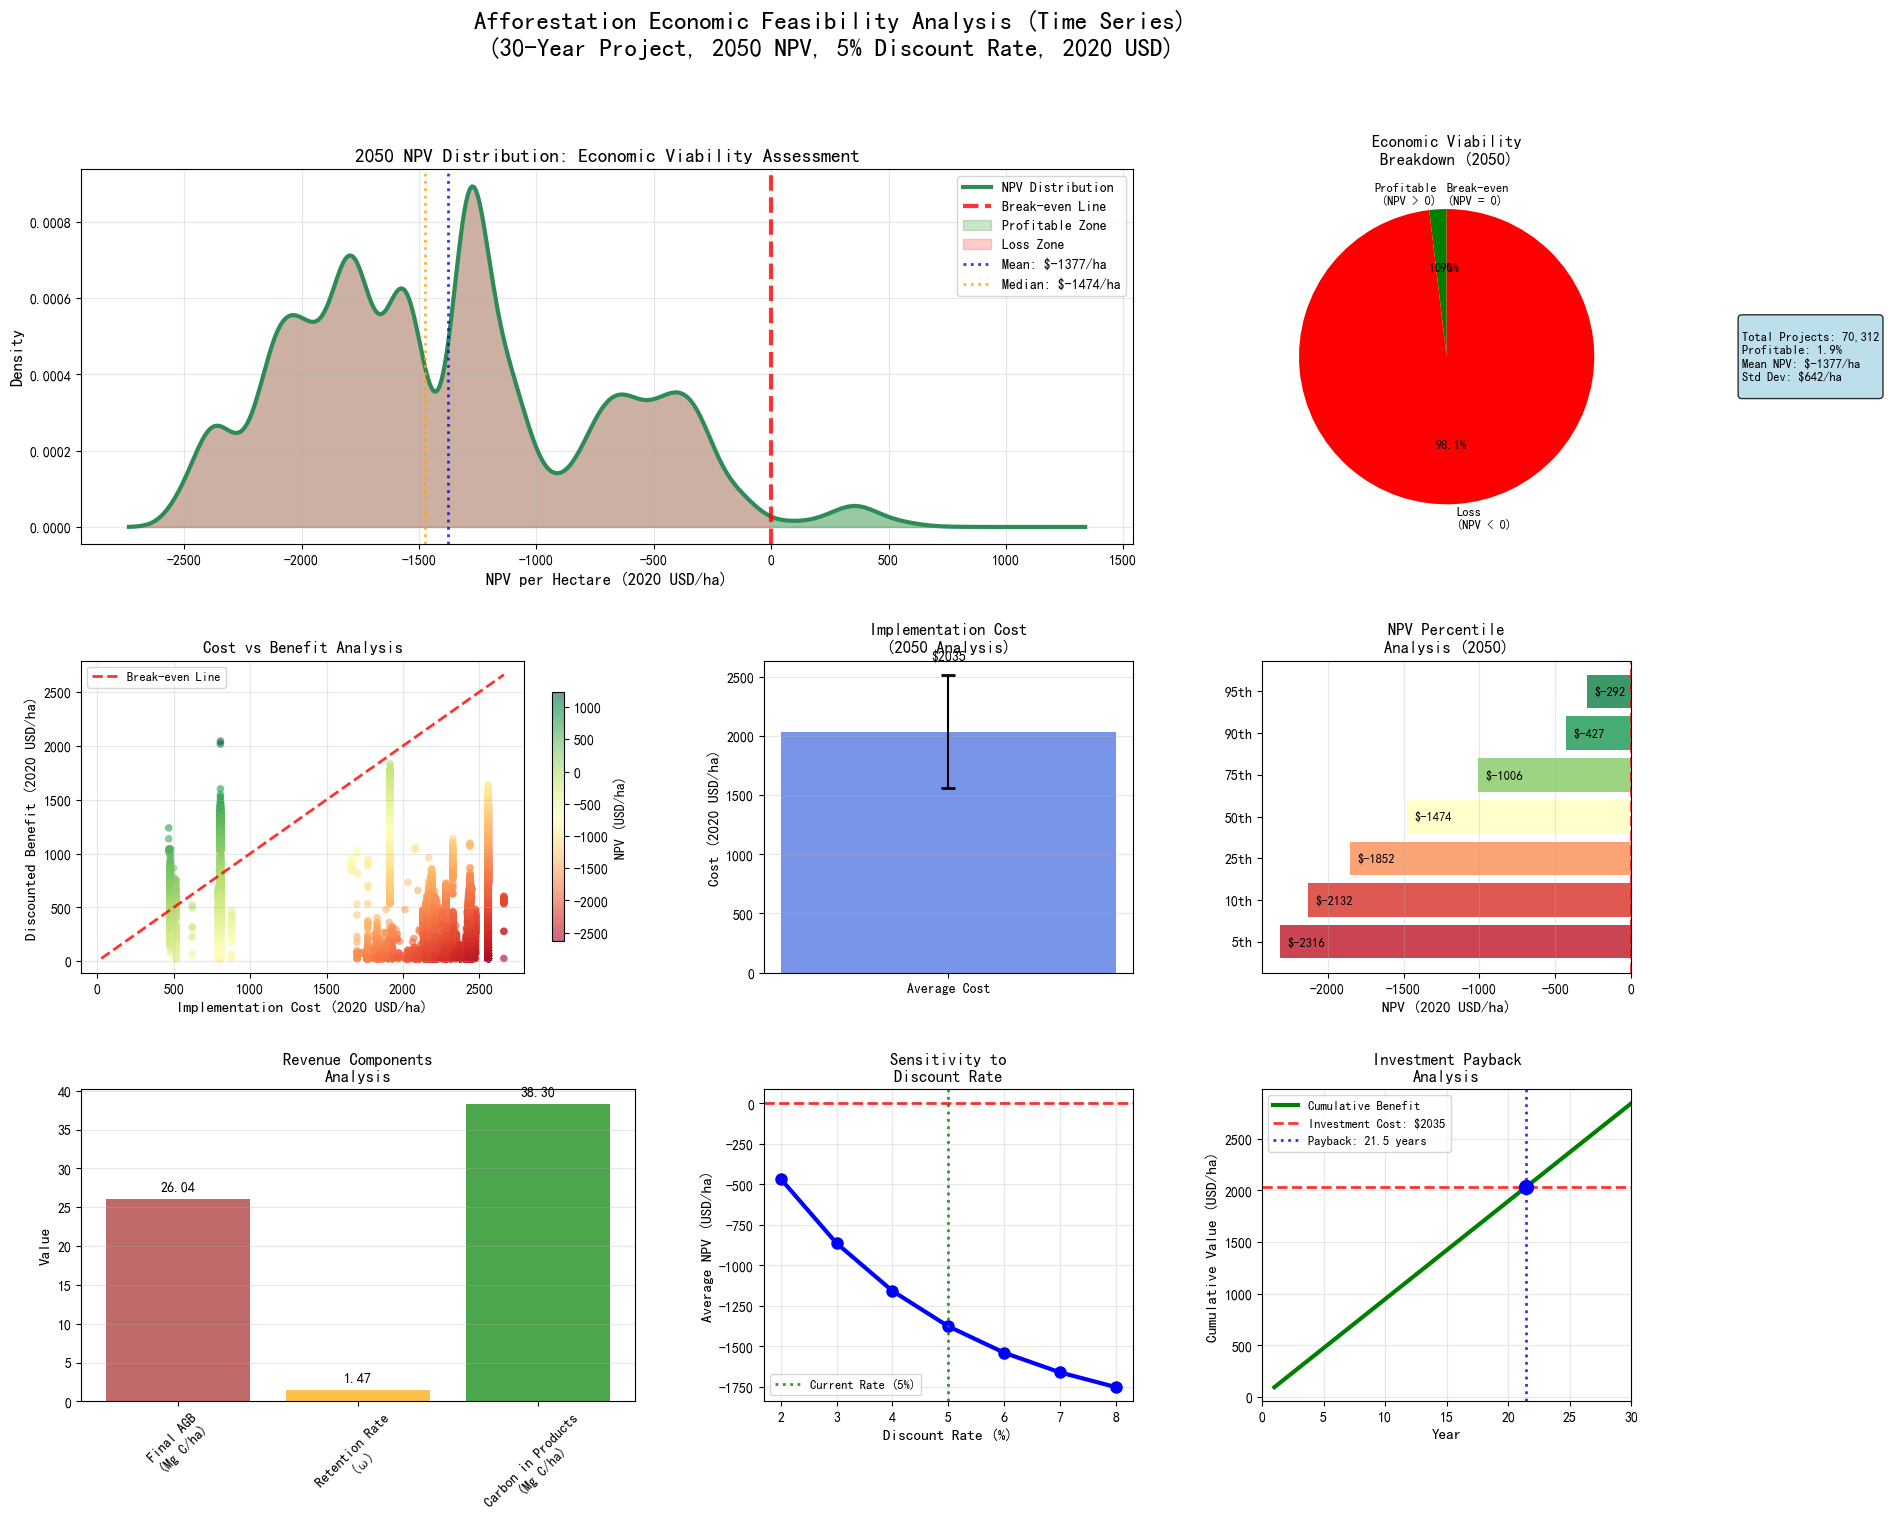


=== 创建空间分布图 ===
创建NPV空间分布图（时间序列数据）...


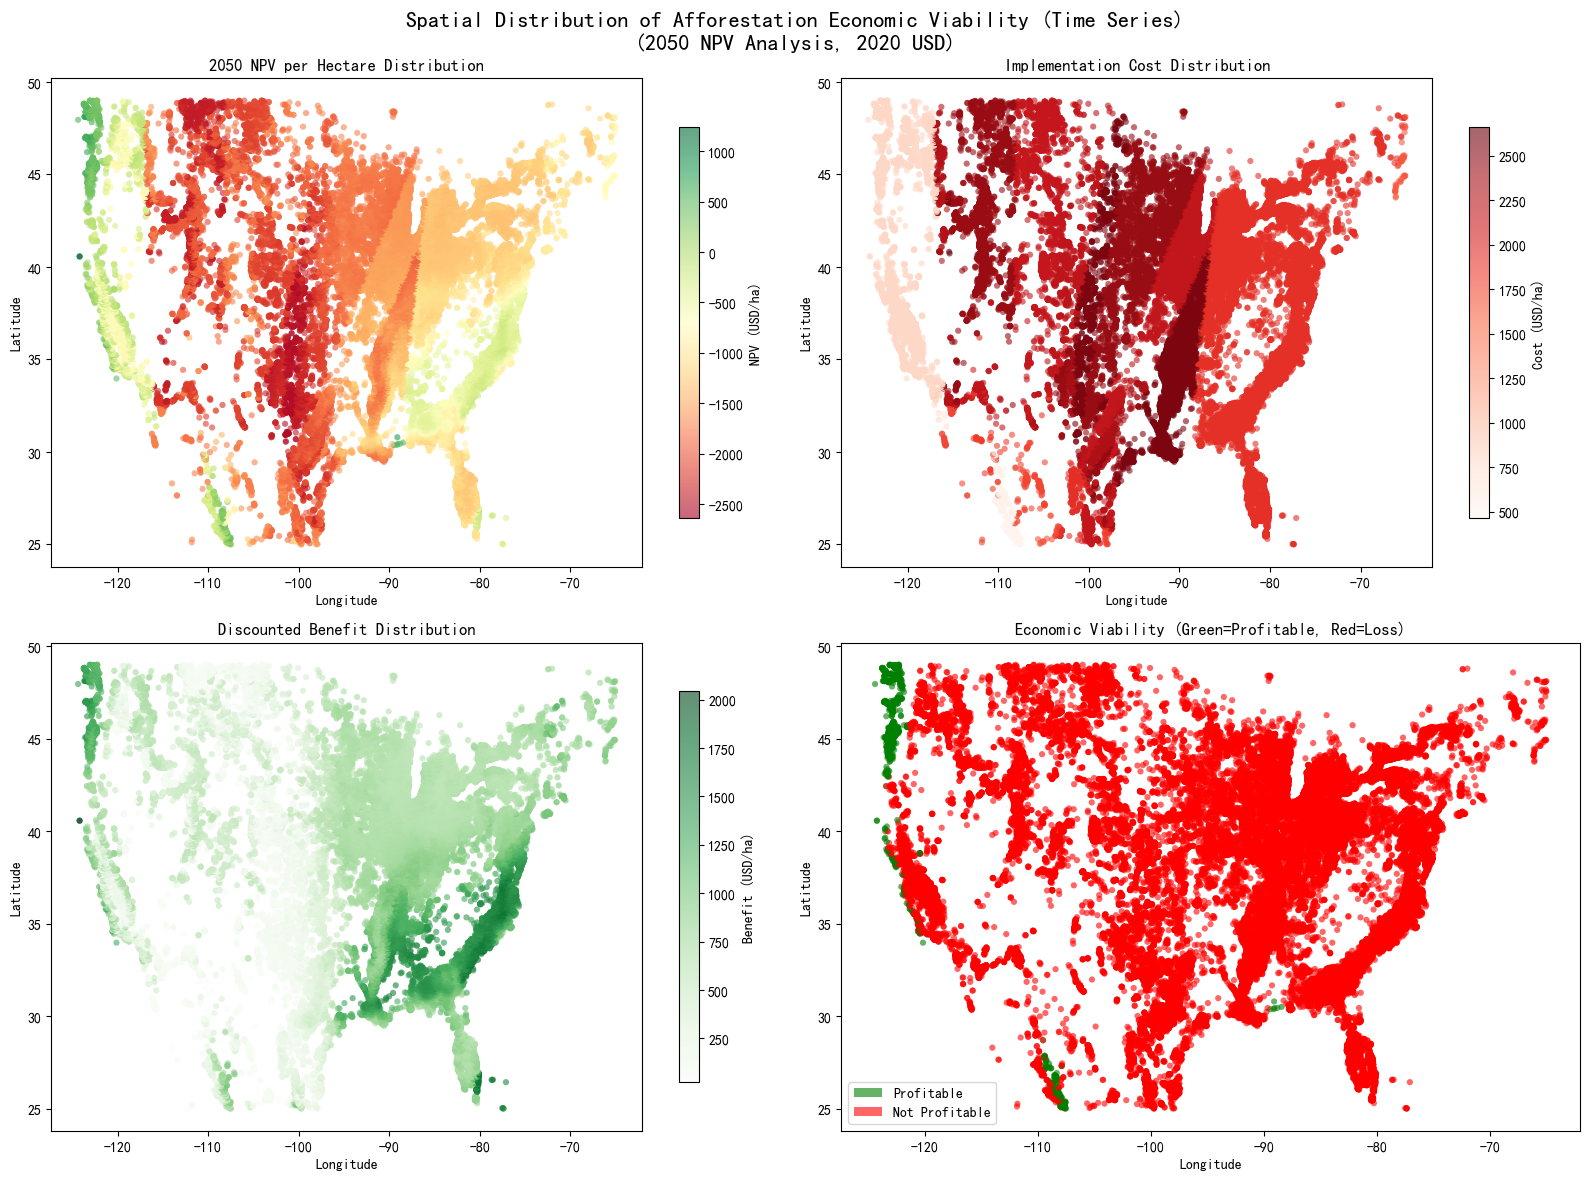


=== 创建时间序列分析图 ===
创建复林策略时间序列分析图...


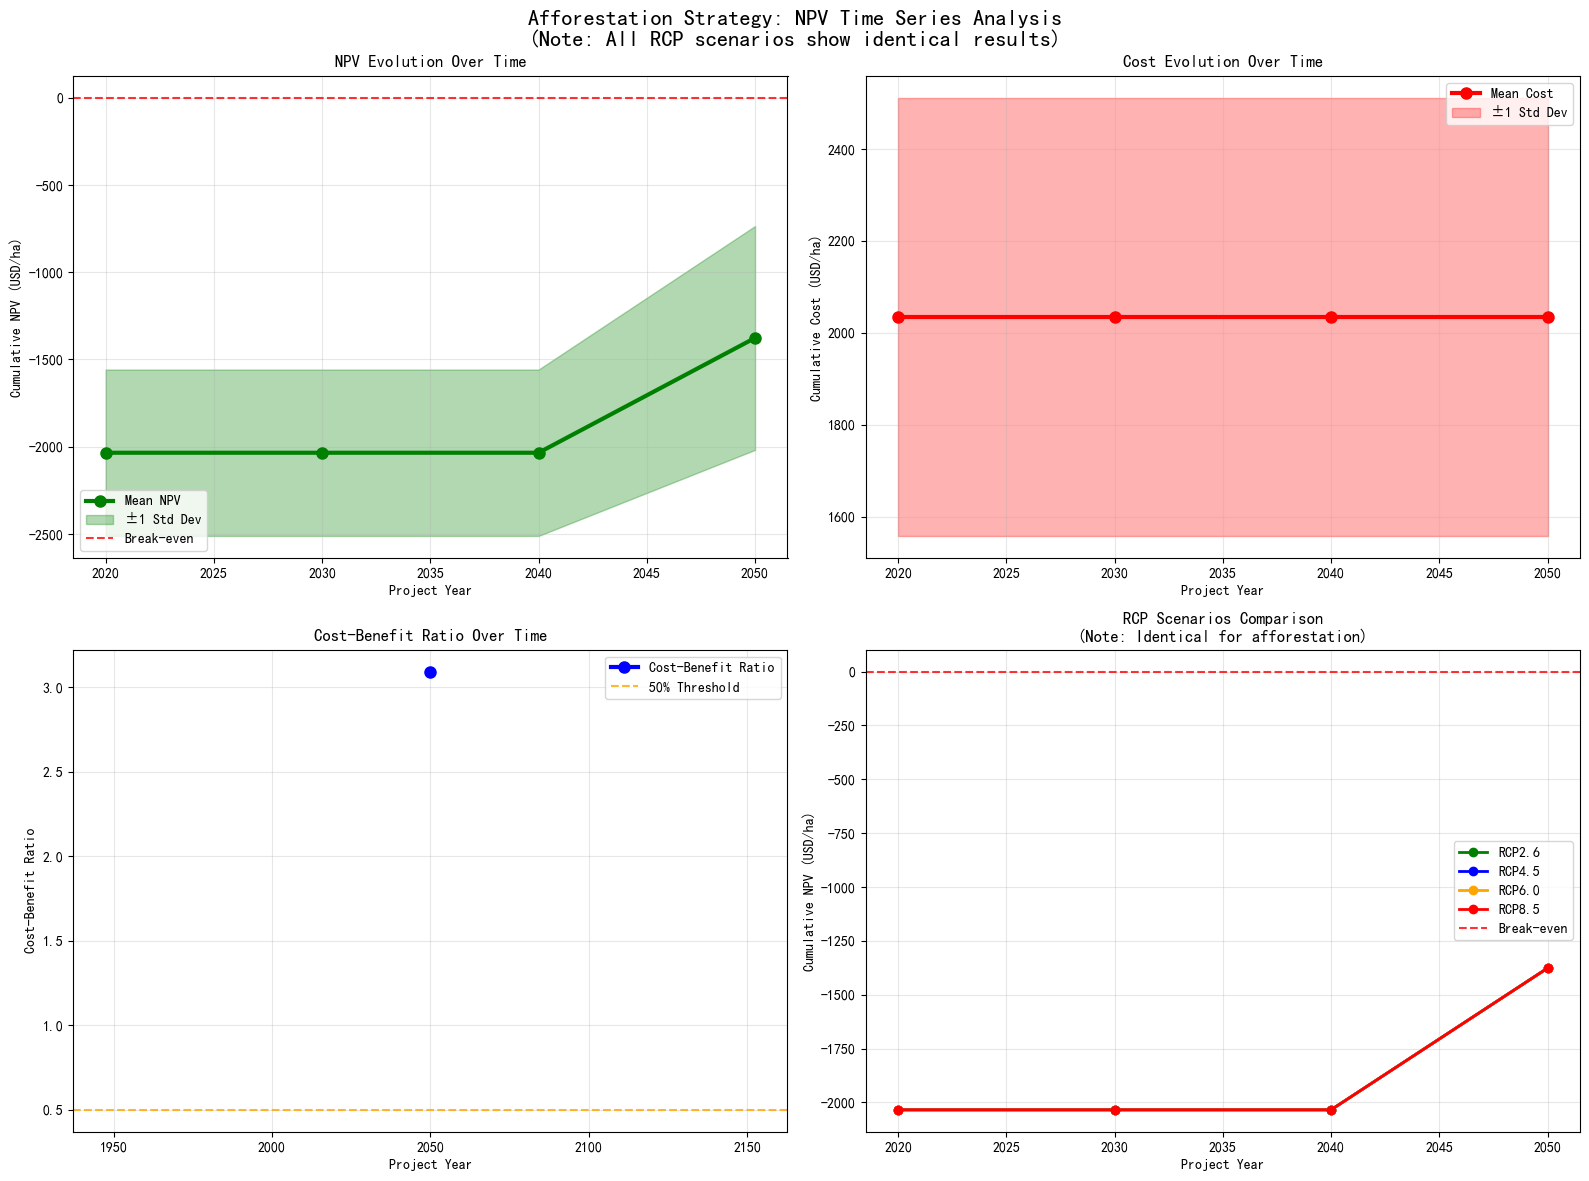


=== 创建RCP对比分析图 ===
创建复林策略RCP对比分析图...


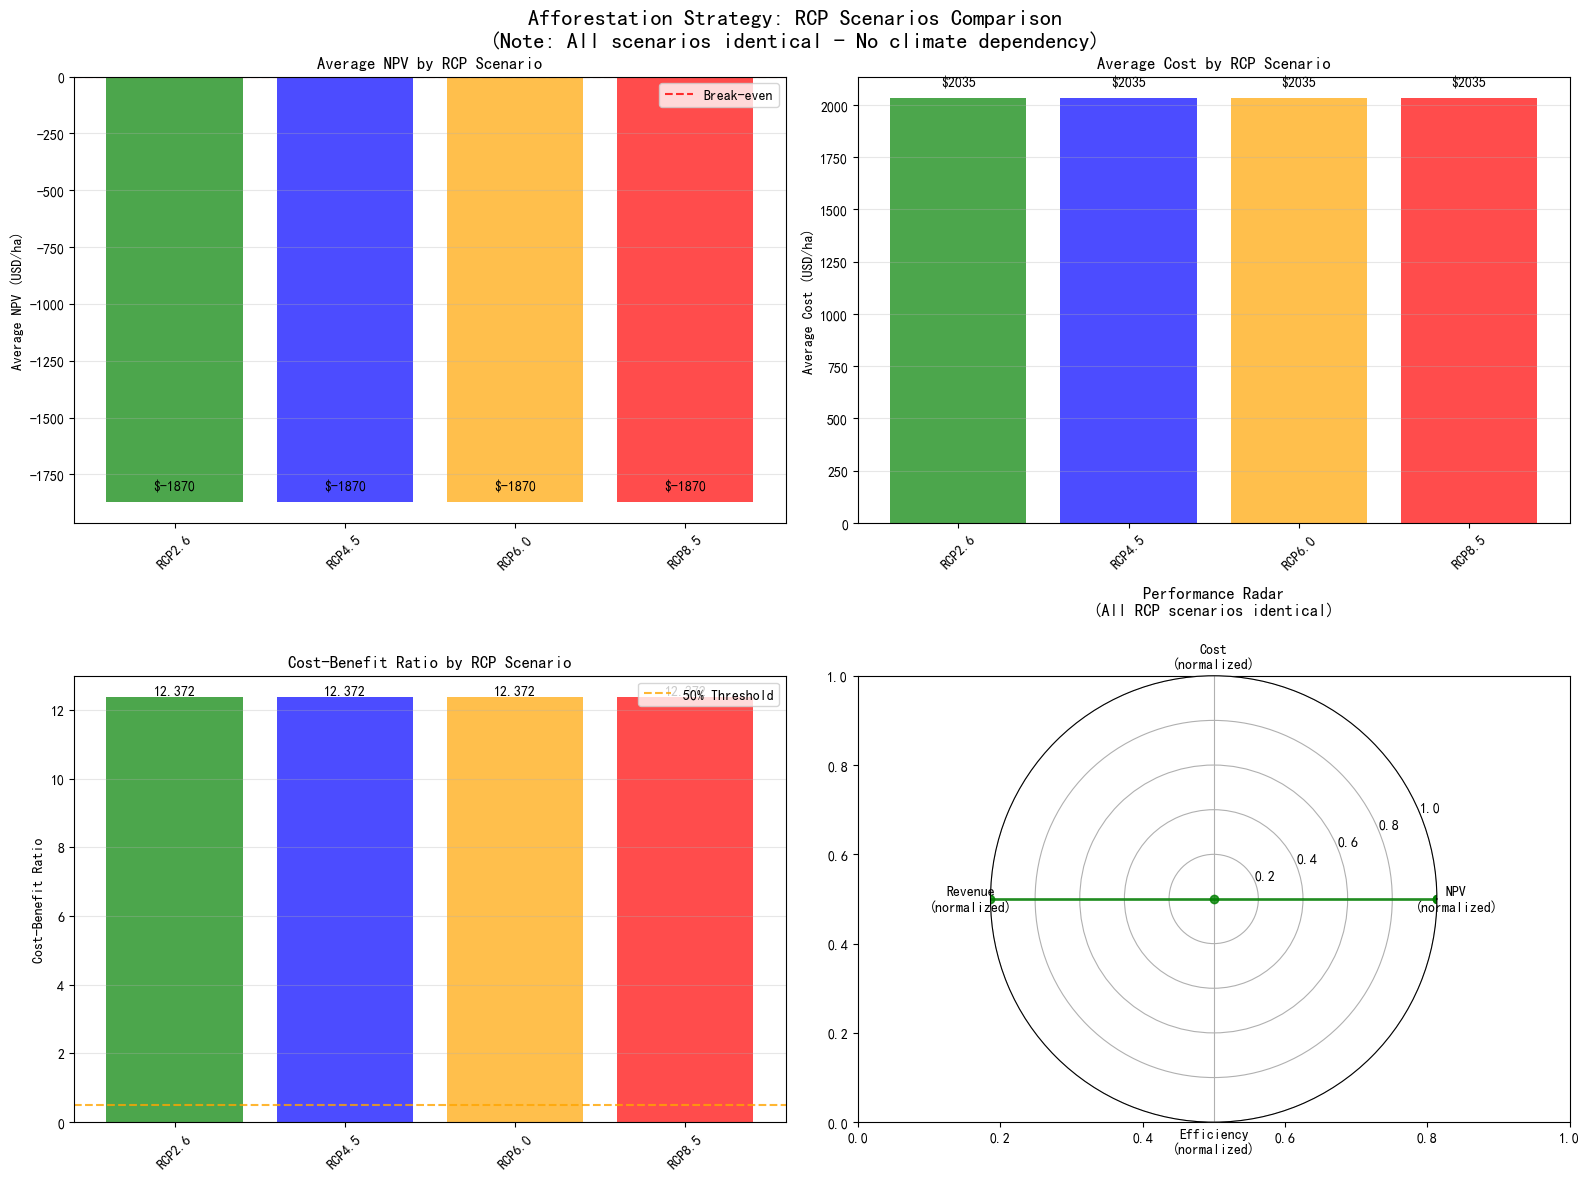


复林经济可行性可视化完成!
生成的图表:
1. 5.1_afforestation_economic_analysis.png - 综合经济分析
2. 5.1_spatial_npv_distribution.png - 空间分布分析
3. 5.1_afforestation_time_series_analysis.png - 时间序列分析
4. 5.1_afforestation_rcp_comparison.png - RCP对比分析


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import gaussian_kde
from matplotlib.patches import Rectangle, Patch
import pandas as pd

# ========================================================================================
# 复林经济可行性可视化函数（时间序列版本）
# ========================================================================================

# 设置配色方案
cost_colors = {
    'native': '#2E8B57',    # 海绿色
    'exotic': '#CD853F',    # 秘鲁色  
    'average': '#4169E1',   # 皇家蓝
    'natRegen': '#8B4513'   # 马鞍棕色
}

plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

def load_afforestation_data_for_visualization():
    """加载复林策略时间序列数据并转换为可视化格式"""
    
    print("加载复林策略时间序列数据...")
    
    # 加载时间序列数据
    df_time_series = pd.read_csv('data/5.1_afforestation_npv_time_series_corrected_2020usd.csv')
    
    # 由于复林策略不区分RCP，我们选择任意一个RCP的数据（所有RCP数据相同）
    df_2050 = df_time_series[
        (df_time_series['project_year'] == 2050) & 
        (df_time_series['rcp_category'] == 'RCP2.6')  # 选择第一个RCP作为代表
    ].copy()
    
    print(f"提取2050年数据用于可视化：{len(df_2050)} 个像素点")
    
    # 重新映射列名以兼容原有可视化函数
    df_viz = df_2050.rename(columns={
        'cumulative_npv_usd': 'NPV_per_ha',
        'initial_investment_usd': 'afforestation_cost_per_ha_average',
        'annual_total_revenue_usd': 'annual_wood_revenue'
    }).copy()
    
    # 尝试加载原始策略数据以获取生物量和其他技术参数
    try:
        df_strategies = pd.read_csv('data/4.1 Restoration_strategy_data.csv')
        print(f"成功加载原始策略数据，包含列: {list(df_strategies.columns)}")
        
        # 检查需要的列是否存在
        required_cols = ['final_AGB', 'omega', 'carbon_in_products', 'wood_profit_per_ha', 'wood_profit_discounted']
        available_cols = [col for col in required_cols if col in df_strategies.columns]
        
        if available_cols:
            print(f"找到可用的复林参数列: {available_cols}")
            # 通过pixel_id合并可用的列
            df_merged = df_viz.merge(
                df_strategies[available_cols], 
                left_on='pixel_id', 
                right_index=True, 
                how='left'
            )
        else:
            print("原始策略数据中没有找到复林计算参数，使用基础数据计算")
            df_merged = df_viz.copy()
            
            # 检查是否有基础数据可以用来计算
            base_cols = ['Base_Pot_AGB_MgCha_500m', 'sequestration']
            base_available = [col for col in base_cols if col in df_strategies.columns]
            
            if base_available:
                print(f"找到基础数据列: {base_available}")
                df_temp = df_viz.merge(
                    df_strategies[base_available], 
                    left_on='pixel_id', 
                    right_index=True, 
                    how='left'
                )
                
                # 从基础数据计算复林参数
                if 'Base_Pot_AGB_MgCha_500m' in df_temp.columns and 'sequestration' in df_temp.columns:
                    print("从基础数据计算复林参数...")
                    YEARS = 30
                    
                    # 计算复林收益系数（从原始代码复制）
                    half_lives = {'bioenergy': 0, 'paper_pulp': 2, 'solid_wood': 30}
                    δ = 0.05
                    y = 30
                    BEF = 1.3
                    CF = 0.26
                    alpha = np.array([0.2, 0.3, 0.5])
                    prices = np.array([3.46, 18.0, 38.0])
                    
                    years = np.arange(1, y+1)
                    disc_factors = (1 - δ) ** years
                    disc_sum = disc_factors.sum()
                    
                    omega_components = {}
                    for use, t_half in half_lives.items():
                        if t_half == 0:
                            decay = np.ones_like(years, dtype=float)
                        else:
                            decay = 2 ** (-years / t_half)
                        omega_components[use] = (decay * disc_factors).sum()
                    
                    omega = sum(omega_components.values()) / (BEF * disc_sum)
                    rho = (alpha * prices).sum() / (BEF * CF)
                    
                    # 计算派生参数
                    df_temp['final_AGB'] = np.minimum(
                        df_temp['Base_Pot_AGB_MgCha_500m'], 
                        df_temp['sequestration'] * YEARS
                    )
                    df_temp['omega'] = omega
                    df_temp['carbon_in_products'] = df_temp['final_AGB'] * omega
                    df_temp['wood_profit_per_ha'] = df_temp['carbon_in_products'] * rho
                    df_temp['wood_profit_discounted'] = df_temp['wood_profit_per_ha'] / ((1 + δ) ** y)
                    
                    df_merged = df_temp
                    print("成功从基础数据计算复林参数")
                else:
                    print("基础数据不完整，使用默认值")
                    df_merged = add_default_afforestation_params(df_viz)
            else:
                print("没有找到任何可用的基础数据，使用默认值")
                df_merged = add_default_afforestation_params(df_viz)
    
    except FileNotFoundError:
        print("警告：找不到策略数据文件，使用时间序列数据的默认值")
        df_merged = add_default_afforestation_params(df_viz)
    except Exception as e:
        print(f"加载策略数据时出错: {e}")
        print("使用默认值")
        df_merged = add_default_afforestation_params(df_viz)
    
    # 设置lat/lon为索引以兼容原有函数
    df_final = df_merged.set_index(['lat', 'lon'])
    
    print("数据预处理完成，准备可视化")
    return df_final

def add_default_afforestation_params(df_viz):
    """为可视化数据添加默认的复林参数"""
    
    print("添加默认复林参数...")
    df_merged = df_viz.copy()
    
    # 基于经济数据估算技术参数
    avg_cost = df_merged['afforestation_cost_per_ha_average'].mean()
    avg_revenue = df_merged['annual_wood_revenue'].mean()
    
    # 使用合理的默认值
    df_merged['omega'] = 0.3  # 典型的留存率
    df_merged['final_AGB'] = 50.0  # 默认最终生物量 (Mg C/ha)
    df_merged['carbon_in_products'] = df_merged['final_AGB'] * df_merged['omega']
    
    # 从年收益推算总收益
    df_merged['wood_profit_per_ha'] = df_merged['annual_wood_revenue'] * 30
    
    # 从NPV和成本推算贴现收益
    df_merged['wood_profit_discounted'] = df_merged['NPV_per_ha'] + df_merged['afforestation_cost_per_ha_average']
    
    print("默认参数添加完成")
    return df_merged

def create_afforestation_economic_analysis(df=None):
    """创建复林经济可行性综合分析图（适配时间序列数据）"""
    
    if df is None:
        df = load_afforestation_data_for_visualization()
    
    print("创建复林经济可行性综合分析图（时间序列数据）...")
    
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3, height_ratios=[1.2, 1, 1], width_ratios=[1.5, 1, 1])
    
    # 主标题 - 更新以反映时间序列分析
    fig.suptitle('Afforestation Economic Feasibility Analysis (Time Series)\n(30-Year Project, 2050 NPV, 5% Discount Rate, 2020 USD)', 
                 fontsize=18, fontweight='bold', y=0.98)
    
    # ========================================================================================
    # 图1: NPV分布密度图 (左上，跨2列)
    # ========================================================================================
    ax1 = fig.add_subplot(gs[0, :2])
    
    # 计算NPV分布
    npv_data = df['NPV_per_ha'].dropna()
    
    if len(npv_data) > 10:
        # 核密度估计
        kde = gaussian_kde(npv_data)
        x_range = np.linspace(npv_data.min() - 100, npv_data.max() + 100, 500)
        density = kde(x_range)
        
        # 绘制密度曲线
        ax1.plot(x_range, density, color='#2E8B57', linewidth=3, label='NPV Distribution')
        ax1.fill_between(x_range, 0, density, color='#2E8B57', alpha=0.3)
        
        # 盈亏平衡线
        ax1.axvline(0, color='red', linestyle='--', linewidth=3, alpha=0.8, label='Break-even Line')
        
        # 填充盈利区域和亏损区域
        profitable_mask = x_range > 0
        loss_mask = x_range < 0
        ax1.fill_between(x_range[profitable_mask], 0, density[profitable_mask], 
                        color='green', alpha=0.2, label='Profitable Zone')
        ax1.fill_between(x_range[loss_mask], 0, density[loss_mask], 
                        color='red', alpha=0.2, label='Loss Zone')
        
        # 添加统计线
        mean_npv = npv_data.mean()
        median_npv = npv_data.median()
        ax1.axvline(mean_npv, color='blue', linestyle=':', linewidth=2, alpha=0.8, label=f'Mean: ${mean_npv:.0f}/ha')
        ax1.axvline(median_npv, color='orange', linestyle=':', linewidth=2, alpha=0.8, label=f'Median: ${median_npv:.0f}/ha')
    
    ax1.set_xlabel('NPV per Hectare (2020 USD/ha)', fontsize=12)
    ax1.set_ylabel('Density', fontsize=12)
    ax1.set_title('2050 NPV Distribution: Economic Viability Assessment', fontweight='bold', fontsize=14)
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=10)
    
    # ========================================================================================
    # 图2: 经济可行性统计 (右上)
    # ========================================================================================
    ax2 = fig.add_subplot(gs[0, 2])
    
    # 计算可行性统计
    profitable_pct = (npv_data > 0).mean() * 100
    loss_pct = (npv_data < 0).mean() * 100
    breakeven_pct = (npv_data == 0).mean() * 100
    
    categories = ['Profitable\n(NPV > 0)', 'Loss\n(NPV < 0)', 'Break-even\n(NPV = 0)']
    percentages = [profitable_pct, loss_pct, breakeven_pct]
    colors = ['green', 'red', 'gray']
    
    # 创建饼图
    wedges, texts, autotexts = ax2.pie(percentages, labels=categories, colors=colors, 
                                      autopct='%1.1f%%', startangle=90, 
                                      textprops={'fontsize': 9})
    
    ax2.set_title('Economic Viability\nBreakdown (2050)', fontweight='bold', fontsize=12)
    
    # 添加统计信息文本框
    stats_text = f"""
Total Projects: {len(npv_data):,}
Profitable: {profitable_pct:.1f}%
Mean NPV: ${npv_data.mean():.0f}/ha
Std Dev: ${npv_data.std():.0f}/ha
"""
    ax2.text(1.3, 0.5, stats_text, transform=ax2.transAxes, fontsize=9,
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
             verticalalignment='center')
    
    # ========================================================================================
    # 图3: 成本vs收益散点图 (左中)
    # ========================================================================================
    ax3 = fig.add_subplot(gs[1, 0])
    
    cost_data = df['afforestation_cost_per_ha_average'].dropna()
    benefit_data = df['wood_profit_discounted'].dropna() if 'wood_profit_discounted' in df.columns else df['annual_wood_revenue'] * 30
    
    # 创建散点图
    scatter = ax3.scatter(cost_data, benefit_data, 
                         c=df['NPV_per_ha'], cmap='RdYlGn', 
                         alpha=0.6, s=30, edgecolors='none')
    
    # 添加1:1线（盈亏平衡线）
    max_val = max(cost_data.max(), benefit_data.max())
    min_val = min(cost_data.min(), benefit_data.min())
    ax3.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, alpha=0.8, label='Break-even Line')
    
    # 添加颜色条
    cbar = plt.colorbar(scatter, ax=ax3, shrink=0.8)
    cbar.set_label('NPV (USD/ha)', fontsize=10)
    
    ax3.set_xlabel('Implementation Cost (2020 USD/ha)', fontsize=11)
    ax3.set_ylabel('Discounted Benefit (2020 USD/ha)', fontsize=11)
    ax3.set_title('Cost vs Benefit Analysis', fontweight='bold', fontsize=12)
    ax3.grid(True, alpha=0.3)
    ax3.legend(fontsize=9)
    
    # ========================================================================================
    # 图4: 成本类型对比 (中中)
    # ========================================================================================
    ax4 = fig.add_subplot(gs[1, 1])
    
    # 使用单一成本类型（因为时间序列数据中只有average成本）
    cost_mean = df['afforestation_cost_per_ha_average'].mean()
    cost_std = df['afforestation_cost_per_ha_average'].std()
    
    bars = ax4.bar(['Average Cost'], [cost_mean], 
                   color=cost_colors['average'],
                   alpha=0.7, capsize=5)
    ax4.errorbar(['Average Cost'], [cost_mean], yerr=[cost_std], 
                fmt='none', color='black', capsize=5, capthick=2)
    
    # 添加数值标签
    ax4.text(0, cost_mean + cost_std + cost_mean * 0.05,
            f'${cost_mean:.0f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    ax4.set_ylabel('Cost (2020 USD/ha)', fontsize=11)
    ax4.set_title('Implementation Cost\n(2050 Analysis)', fontweight='bold', fontsize=12)
    ax4.grid(True, alpha=0.3, axis='y')
    
    # ========================================================================================
    # 图5: NPV分位数分析 (右中)
    # ========================================================================================
    ax5 = fig.add_subplot(gs[1, 2])
    
    # 计算NPV分位数
    percentiles = [5, 10, 25, 50, 75, 90, 95]
    npv_percentiles = [np.percentile(npv_data, p) for p in percentiles]
    
    colors_gradient = plt.cm.RdYlGn([p/100 for p in percentiles])
    bars = ax5.barh(range(len(percentiles)), npv_percentiles, 
                    color=colors_gradient, alpha=0.8)
    
    # 添加百分位标签
    ax5.set_yticks(range(len(percentiles)))
    ax5.set_yticklabels([f'{p}th' for p in percentiles])
    ax5.set_xlabel('NPV (2020 USD/ha)', fontsize=11)
    ax5.set_title('NPV Percentile\nAnalysis (2050)', fontweight='bold', fontsize=12)
    ax5.grid(True, alpha=0.3, axis='x')
    
    # 添加盈亏平衡线
    ax5.axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.8)
    
    # 添加数值标签
    for i, (bar, val) in enumerate(zip(bars, npv_percentiles)):
        ax5.text(val + (ax5.get_xlim()[1] - ax5.get_xlim()[0]) * 0.02, i,
                f'${val:.0f}', va='center', fontsize=9)
    
    # ========================================================================================
    # 图6: 收益组成分析 (左下)
    # ========================================================================================
    ax6 = fig.add_subplot(gs[2, 0])
    
    # 计算收益组成
    if 'carbon_in_products' in df.columns:
        avg_carbon = df['carbon_in_products'].mean()
        avg_omega = df['omega'].mean() if 'omega' in df.columns else 0.3
        avg_final_agb = df['final_AGB'].mean() if 'final_AGB' in df.columns else avg_carbon / avg_omega
    else:
        # 使用默认值
        avg_omega = 0.3
        avg_carbon = 15.0
        avg_final_agb = 50.0
    
    components = ['Final AGB\n(Mg C/ha)', 'Retention Rate\n(ω)', 'Carbon in Products\n(Mg C/ha)']
    values = [avg_final_agb, avg_omega, avg_carbon]
    
    bars = ax6.bar(components, values, color=['brown', 'orange', 'green'], alpha=0.7)
    
    for bar, val in zip(bars, values):
        ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values) * 0.02,
                f'{val:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    ax6.set_ylabel('Value', fontsize=11)
    ax6.set_title('Revenue Components\nAnalysis', fontweight='bold', fontsize=12)
    ax6.grid(True, alpha=0.3, axis='y')
    ax6.tick_params(axis='x', rotation=45)
    
    # ========================================================================================
    # 图7: 经济参数敏感性 (中下)
    # ========================================================================================
    ax7 = fig.add_subplot(gs[2, 1])
    
    # 敏感性分析：贴现率变化对NPV的影响
    discount_rates = np.array([0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08])
    
    # 重新计算不同贴现率下的NPV
    if 'wood_profit_per_ha' in df.columns:
        base_benefit = df['wood_profit_per_ha'].mean()
    else:
        base_benefit = df['annual_wood_revenue'].mean() * 30
    
    base_cost = df['afforestation_cost_per_ha_average'].mean()
    
    npv_sensitivity = []
    for dr in discount_rates:
        discounted_benefit = base_benefit / ((1 + dr) ** 30)
        npv_sens = discounted_benefit - base_cost
        npv_sensitivity.append(npv_sens)
    
    ax7.plot(discount_rates * 100, npv_sensitivity, 'o-', color='blue', linewidth=3, markersize=8)
    ax7.axhline(0, color='red', linestyle='--', linewidth=2, alpha=0.8)
    ax7.axvline(5, color='green', linestyle=':', linewidth=2, alpha=0.8, label='Current Rate (5%)')
    
    ax7.set_xlabel('Discount Rate (%)', fontsize=11)
    ax7.set_ylabel('Average NPV (USD/ha)', fontsize=11)
    ax7.set_title('Sensitivity to\nDiscount Rate', fontweight='bold', fontsize=12)
    ax7.grid(True, alpha=0.3)
    ax7.legend(fontsize=9)
    
    # ========================================================================================
    # 图8: 投资回收期分析 (右下)
    # ========================================================================================
    ax8 = fig.add_subplot(gs[2, 2])
    
    # 简化的投资回收期计算
    avg_cost = df['afforestation_cost_per_ha_average'].mean()
    if 'wood_profit_per_ha' in df.columns:
        avg_annual_benefit = df['wood_profit_per_ha'].mean() / 30
    else:
        avg_annual_benefit = df['annual_wood_revenue'].mean()
    
    if avg_annual_benefit > 0:
        payback_period = avg_cost / avg_annual_benefit
    else:
        payback_period = float('inf')
    
    # 创建投资回收期可视化
    years = np.arange(1, 31)
    cumulative_benefit = years * avg_annual_benefit
    
    ax8.plot(years, cumulative_benefit, color='green', linewidth=3, label='Cumulative Benefit')
    ax8.axhline(avg_cost, color='red', linestyle='--', linewidth=2, alpha=0.8, label=f'Investment Cost: ${avg_cost:.0f}')
    
    if payback_period <= 30:
        ax8.axvline(payback_period, color='blue', linestyle=':', linewidth=2, alpha=0.8, 
                   label=f'Payback: {payback_period:.1f} years')
        ax8.scatter([payback_period], [avg_cost], color='blue', s=100, zorder=5)
    
    ax8.set_xlabel('Year', fontsize=11)
    ax8.set_ylabel('Cumulative Value (USD/ha)', fontsize=11)
    ax8.set_title('Investment Payback\nAnalysis', fontweight='bold', fontsize=12)
    ax8.grid(True, alpha=0.3)
    ax8.legend(fontsize=9)
    ax8.set_xlim(0, 30)
    
    plt.tight_layout()
    plt.savefig('data/5.1_afforestation_economic_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

def create_spatial_npv_distribution(df=None):
    """创建NPV空间分布图（适配时间序列数据）"""
    
    if df is None:
        df = load_afforestation_data_for_visualization()
    
    print("创建NPV空间分布图（时间序列数据）...")
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Spatial Distribution of Afforestation Economic Viability (Time Series)\n(2050 NPV Analysis, 2020 USD)', 
                 fontsize=16, fontweight='bold')
    
    # 重置索引以获取lat/lon列
    df_spatial = df.reset_index()
    
    # 图1: NPV空间分布
    scatter1 = ax1.scatter(df_spatial['lon'], df_spatial['lat'], 
                          c=df_spatial['NPV_per_ha'], cmap='RdYlGn', 
                          s=20, alpha=0.6, edgecolors='none')
    ax1.set_title('2050 NPV per Hectare Distribution', fontweight='bold')
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')
    cbar1 = plt.colorbar(scatter1, ax=ax1, shrink=0.8)
    cbar1.set_label('NPV (USD/ha)')
    
    # 图2: 成本空间分布
    scatter2 = ax2.scatter(df_spatial['lon'], df_spatial['lat'], 
                          c=df_spatial['afforestation_cost_per_ha_average'], cmap='Reds', 
                          s=20, alpha=0.6, edgecolors='none')
    ax2.set_title('Implementation Cost Distribution', fontweight='bold')
    ax2.set_xlabel('Longitude')
    ax2.set_ylabel('Latitude')
    cbar2 = plt.colorbar(scatter2, ax=ax2, shrink=0.8)
    cbar2.set_label('Cost (USD/ha)')
    
    # 图3: 收益空间分布
    if 'wood_profit_discounted' in df_spatial.columns:
        benefit_col = 'wood_profit_discounted'
        title3 = 'Discounted Benefit Distribution'
    else:
        benefit_col = 'annual_wood_revenue'
        title3 = 'Annual Revenue Distribution'
    
    scatter3 = ax3.scatter(df_spatial['lon'], df_spatial['lat'], 
                          c=df_spatial[benefit_col], cmap='Greens', 
                          s=20, alpha=0.6, edgecolors='none')
    ax3.set_title(title3, fontweight='bold')
    ax3.set_xlabel('Longitude')
    ax3.set_ylabel('Latitude')
    cbar3 = plt.colorbar(scatter3, ax=ax3, shrink=0.8)
    cbar3.set_label('Benefit (USD/ha)')
    
    # 图4: 经济可行性二进制图
    viability = df_spatial['NPV_per_ha'] > 0
    colors = ['red' if not v else 'green' for v in viability]
    ax4.scatter(df_spatial['lon'], df_spatial['lat'], 
               c=colors, s=20, alpha=0.6, edgecolors='none')
    ax4.set_title('Economic Viability (Green=Profitable, Red=Loss)', fontweight='bold')
    ax4.set_xlabel('Longitude')
    ax4.set_ylabel('Latitude')
    
    # 添加图例
    legend_elements = [Patch(facecolor='green', alpha=0.6, label='Profitable'),
                      Patch(facecolor='red', alpha=0.6, label='Not Profitable')]
    ax4.legend(handles=legend_elements, loc='best')
    
    plt.tight_layout()
    plt.savefig('data/5.1_spatial_npv_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

def create_afforestation_time_series_analysis():
    """创建复林策略时间序列分析图"""
    
    print("创建复林策略时间序列分析图...")
    
    # 加载时间序列数据
    try:
        df_time_series = pd.read_csv('data/5.1_afforestation_npv_time_series_corrected_2020usd.csv')
        df_summary = pd.read_csv('data/5.1_afforestation_summary_corrected_by_rcp_year_2020usd.csv')
    except FileNotFoundError as e:
        print(f"错误：找不到时间序列数据文件 - {e}")
        return None
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Afforestation Strategy: NPV Time Series Analysis\n(Note: All RCP scenarios show identical results)', 
                 fontsize=16, fontweight='bold')
    
    # 修复列名（处理可能的命名差异）
    if 'rcp_category_' in df_summary.columns:
        rcp_col = 'rcp_category_'
        year_col = 'project_year_'
    else:
        rcp_col = 'rcp_category'
        year_col = 'project_year'
    
    # 图1: NPV随时间变化（选择一个RCP作为代表）
    df_rcp26 = df_summary[df_summary[rcp_col] == 'RCP2.6']
    
    if not df_rcp26.empty:
        ax1.plot(df_rcp26[year_col], df_rcp26['cumulative_npv_usd_mean'], 
                'o-', linewidth=3, markersize=8, color='green', label='Mean NPV')
        ax1.fill_between(df_rcp26[year_col], 
                        df_rcp26['cumulative_npv_usd_mean'] - df_rcp26['cumulative_npv_usd_std'],
                        df_rcp26['cumulative_npv_usd_mean'] + df_rcp26['cumulative_npv_usd_std'],
                        alpha=0.3, color='green', label='±1 Std Dev')
    
    ax1.axhline(0, color='red', linestyle='--', alpha=0.8, label='Break-even')
    ax1.set_xlabel('Project Year')
    ax1.set_ylabel('Cumulative NPV (USD/ha)')
    ax1.set_title('NPV Evolution Over Time')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # 图2: 累积成本随时间变化
    if not df_rcp26.empty:
        ax2.plot(df_rcp26[year_col], df_rcp26['cumulative_cost_usd_mean'], 
                'o-', linewidth=3, markersize=8, color='red', label='Mean Cost')
        ax2.fill_between(df_rcp26[year_col], 
                        df_rcp26['cumulative_cost_usd_mean'] - df_rcp26['cumulative_cost_usd_std'],
                        df_rcp26['cumulative_cost_usd_mean'] + df_rcp26['cumulative_cost_usd_std'],
                        alpha=0.3, color='red', label='±1 Std Dev')
    
    ax2.set_xlabel('Project Year')
    ax2.set_ylabel('Cumulative Cost (USD/ha)')
    ax2.set_title('Cost Evolution Over Time')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # 图3: 成本效益比随时间变化
    if not df_rcp26.empty:
        ax3.plot(df_rcp26[year_col], df_rcp26['cost_benefit_ratio'], 
                'o-', linewidth=3, markersize=8, color='blue', label='Cost-Benefit Ratio')
    
    ax3.axhline(0.5, color='orange', linestyle='--', alpha=0.8, label='50% Threshold')
    ax3.set_xlabel('Project Year')
    ax3.set_ylabel('Cost-Benefit Ratio')
    ax3.set_title('Cost-Benefit Ratio Over Time')
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    
    # 图4: RCP对比（虽然数据相同，但展示所有RCP）
    colors = ['green', 'blue', 'orange', 'red']
    rcps = ['RCP2.6', 'RCP4.5', 'RCP6.0', 'RCP8.5']
    
    for i, rcp in enumerate(rcps):
        df_rcp = df_summary[df_summary[rcp_col] == rcp]
        if not df_rcp.empty:
            ax4.plot(df_rcp[year_col], df_rcp['cumulative_npv_usd_mean'], 
                    'o-', linewidth=2, markersize=6, color=colors[i], label=rcp)
    
    ax4.axhline(0, color='red', linestyle='--', alpha=0.8, label='Break-even')
    ax4.set_xlabel('Project Year')
    ax4.set_ylabel('Cumulative NPV (USD/ha)')
    ax4.set_title('RCP Scenarios Comparison\n(Note: Identical for afforestation)')
    ax4.grid(True, alpha=0.3)
    ax4.legend()
    
    plt.tight_layout()
    plt.savefig('data/5.1_afforestation_time_series_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

def create_afforestation_rcp_comparison():
    """创建复林策略RCP对比分析图"""
    
    print("创建复林策略RCP对比分析图...")
    
    try:
        df_rcp_overall = pd.read_csv('data/5.1_afforestation_rcp_averages_corrected_2020usd.csv')
    except FileNotFoundError:
        print("错误：找不到RCP总体平均值文件")
        return None
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Afforestation Strategy: RCP Scenarios Comparison\n(Note: All scenarios identical - No climate dependency)', 
                 fontsize=16, fontweight='bold')
    
    rcps = df_rcp_overall['RCP_Category']
    colors = ['green', 'blue', 'orange', 'red']
    
    # 图1: 平均NPV对比
    bars1 = ax1.bar(rcps, df_rcp_overall['Average_NPV_USD_2020'], 
                    color=colors, alpha=0.7)
    ax1.axhline(0, color='red', linestyle='--', alpha=0.8, label='Break-even')
    ax1.set_ylabel('Average NPV (USD/ha)')
    ax1.set_title('Average NPV by RCP Scenario')
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.tick_params(axis='x', rotation=45)
    ax1.legend()
    
    # 添加数值标签
    for bar, val in zip(bars1, df_rcp_overall['Average_NPV_USD_2020']):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (ax1.get_ylim()[1] - ax1.get_ylim()[0]) * 0.02,
                f'${val:.0f}', ha='center', va='bottom', fontweight='bold')
    
    # 图2: 平均成本对比
    bars2 = ax2.bar(rcps, df_rcp_overall['Average_Cost_USD_2020'], 
                    color=colors, alpha=0.7)
    ax2.set_ylabel('Average Cost (USD/ha)')
    ax2.set_title('Average Cost by RCP Scenario')
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.tick_params(axis='x', rotation=45)
    
    # 添加数值标签
    for bar, val in zip(bars2, df_rcp_overall['Average_Cost_USD_2020']):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (ax2.get_ylim()[1] - ax2.get_ylim()[0]) * 0.02,
                f'${val:.0f}', ha='center', va='bottom', fontweight='bold')
    
    # 图3: 成本效益比对比
    bars3 = ax3.bar(rcps, df_rcp_overall['Overall_Cost_Benefit_Ratio'], 
                    color=colors, alpha=0.7)
    ax3.axhline(0.5, color='orange', linestyle='--', alpha=0.8, label='50% Threshold')
    ax3.set_ylabel('Cost-Benefit Ratio')
    ax3.set_title('Cost-Benefit Ratio by RCP Scenario')
    ax3.grid(True, alpha=0.3, axis='y')
    ax3.tick_params(axis='x', rotation=45)
    ax3.legend()
    
    # 添加数值标签
    for bar, val in zip(bars3, df_rcp_overall['Overall_Cost_Benefit_Ratio']):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{val:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 图4: 综合对比雷达图
    categories = ['NPV\n(normalized)', 'Cost\n(normalized)', 'Revenue\n(normalized)', 'Efficiency\n(normalized)']
    
    # 标准化数据
    npv_norm = df_rcp_overall['Average_NPV_USD_2020'] / df_rcp_overall['Average_NPV_USD_2020'].max()
    cost_norm = 1 - (df_rcp_overall['Average_Cost_USD_2020'] / df_rcp_overall['Average_Cost_USD_2020'].max())  # 成本越低越好
    revenue_norm = df_rcp_overall['Average_Total_Revenue_USD_2020'] / df_rcp_overall['Average_Total_Revenue_USD_2020'].max()
    efficiency_norm = 1 - df_rcp_overall['Overall_Cost_Benefit_Ratio']  # 比率越低越好
    
    # 由于所有RCP数据相同，只显示一条线
    values = [npv_norm.iloc[0], cost_norm.iloc[0], revenue_norm.iloc[0], efficiency_norm.iloc[0]]
    values += values[:1]  # 闭合雷达图
    
    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]
    
    ax4 = plt.subplot(2, 2, 4, projection='polar')
    ax4.plot(angles, values, 'o-', linewidth=2, color='green', alpha=0.8)
    ax4.fill(angles, values, alpha=0.25, color='green')
    ax4.set_xticks(angles[:-1])
    ax4.set_xticklabels(categories)
    ax4.set_ylim(0, 1)
    ax4.set_title('Performance Radar\n(All RCP scenarios identical)', pad=20, fontweight='bold')
    ax4.grid(True)
    
    plt.tight_layout()
    plt.savefig('data/5.1_afforestation_rcp_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

# ========================================================================================
# 主调用函数
# ========================================================================================

def run_afforestation_visualization():
    """运行所有复林策略可视化分析"""
    
    print("="*80)
    print("复林策略经济可行性可视化分析")
    print("="*80)
    
    try:
        # 加载适配的数据
        df_viz = load_afforestation_data_for_visualization()
        
        # 创建综合经济分析图
        print("\n=== 创建综合经济分析图 ===")
        fig1 = create_afforestation_economic_analysis(df_viz)
        
        # 创建空间分布图
        print("\n=== 创建空间分布图 ===")
        fig2 = create_spatial_npv_distribution(df_viz)
        
        # 创建时间序列分析图
        print("\n=== 创建时间序列分析图 ===")
        fig3 = create_afforestation_time_series_analysis()
        
        # 创建RCP对比分析图
        print("\n=== 创建RCP对比分析图 ===")
        fig4 = create_afforestation_rcp_comparison()
        
        print("\n复林经济可行性可视化完成!")
        print("生成的图表:")
        print("1. 5.1_afforestation_economic_analysis.png - 综合经济分析")
        print("2. 5.1_spatial_npv_distribution.png - 空间分布分析") 
        print("3. 5.1_afforestation_time_series_analysis.png - 时间序列分析")
        print("4. 5.1_afforestation_rcp_comparison.png - RCP对比分析")
        
        return fig1, fig2, fig3, fig4
        
    except Exception as e:
        print(f"可视化过程中出错: {e}")
        import traceback
        traceback.print_exc()
        return None

# ========================================================================================
# 直接调用（如果作为脚本运行）
# ========================================================================================

if __name__ == "__main__":
    run_afforestation_visualization()

# 5.4 自然恢复策略经济净收益

这里的逻辑是采用自然再生的成本来替代，忽略其地表生物量蕴含的经济价值


In [11]:
df_strategies = pd.read_csv(r'data\4.1 Restoration_strategy_data.csv')
df_strategies.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'time', 'lat', 'lon', 'abandonment_year',
       'abandonment_duration', 'current_abandonment', 'landcover', 'DEM',
       'GDPpc', 'GDPtot', 'GURdist', 'Population', 'Powerdist', 'PrimaryRoad',
       'SecondaryRoad', 'Slope', 'TertiaryRoad', 'gdmp', 'rsds', 'tas', 'wind',
       'env_scores', 'I', 'T_amb_C', 'T_cell', 'PR', 'PVPOT', 'area_m2',
       'E_yr_per_m2', 'E_yr_pixel', 'carbon_emission (t)/yr',
       'weighted_density_1', 'weighted_density_2', 'weighted_density_3',
       'weighted_density_4', 'weighted_density_5', 'weighted_density_6',
       'weighted_density_7', 'weighted_density_8', 'weighted_density_9',
       'grass_rmf_mosaic', 'Base_Pot_AGB_BGB_MgCha_500m',
       'Base_Unr_SOC_MgCha_500m', 'Base_Unr_AGB_BGB_MgCha_500m',
       'Base_Cur_AGB_BGB_SOC_MgCha_500m', 'shrub_rmf_mosaic',
       'Base_Pot_AGB_BGB_SOC_MgCha_500m',
       'Sugarcane_1981-2010_Historical_With CO2 Fertilization',
       'Rubber_1981-2010_Historical_With CO

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import xarray as xr
import numpy as np
from scipy.spatial import cKDTree

# ========================================================================================
# 自然植被恢复策略经济可行性分析（完整版本）
# ========================================================================================

# 项目参数设置（与农业策略一致）
PROJECT_START_YEAR = 2020
PROJECT_LIFETIME = 30
TARGET_YEARS = [2020, 2030, 2040, 2050]  # 与农业策略一致的时间点
DISCOUNT_RATE = 0.05  # 5% 贴现率
RCP_SCENARIOS = ['RCP2.6', 'RCP4.5', 'RCP6.0', 'RCP8.5']  # 保持格式一致

# ========================================================================================
# 优化的最近邻有效值填充方法
# ========================================================================================

def extract_with_fast_nearest_fill(ds, target_coords, variable_name='natRegen'):
    """
    快速提取数据，使用最近邻有效值填充缺失值
    
    优势：
    1. 速度最快（一次性构建KD树）
    2. 逻辑合理（使用最接近的真实观测值）
    3. 内存效率高
    4. 结果稳定可靠
    """
    
    print(f"使用快速最近邻填充提取 {variable_name}...")
    
    # 提取变量数据
    data_var = ds[variable_name]
    if len(data_var.dims) == 3:  # 处理时间维度
        data_values = data_var.isel(time=0).values
    else:
        data_values = data_var.values
    
    # 一次性找到所有有效数据点
    valid_mask = ~np.isnan(data_values)
    
    if not valid_mask.any():
        print(f"   警告: {variable_name} 中没有有效数据")
        return np.full(len(target_coords), np.nan)
    
    # 构建有效坐标数组（向量化操作）
    with tqdm(desc="构建坐标网格", total=2) as pbar:
        lat_grid, lon_grid = np.meshgrid(data_var.lat.values, data_var.lon.values, indexing='ij')
        pbar.update(1)
        valid_coords = np.column_stack([
            lat_grid[valid_mask], 
            lon_grid[valid_mask]
        ])
        valid_values = data_values[valid_mask]
        pbar.update(1)
    
    print(f"   找到 {len(valid_values)} 个有效数据点")
    
    # 一次性构建KD树（最耗时的操作只做一次）
    print("构建KD树...")
    tree = cKDTree(valid_coords)
    
    # 向量化查询所有目标坐标
    print("查询目标坐标...")
    target_coords_array = np.array(target_coords)
    distances, indices = tree.query(target_coords_array, k=1, workers=-1)
    
    # 直接索引获取结果
    result_values = valid_values[indices]
    
    print(f"   成功提取 {len(target_coords)} 个坐标点")
    print(f"   平均填充距离: {distances.mean():.6f}°")
    
    return result_values

# ========================================================================================
# NPV计算函数
# ========================================================================================

def calculate_natural_restoration_npv_for_year(row, project_year, rcp_scenario=None):
    """
    计算自然修复NPV（极简版本）
    
    逻辑：
    - 第0年（2020）：支付所有实施成本
    - 第1-30年：无额外成本，无收益
    - NPV = -初始成本（所有年份相同）
    """
    
    initial_cost_per_ha = row['natural_cost_per_ha']
    area_ha = row['area_ha']
    total_cost = row['natural_total_cost']
    
    # 自然修复的NPV很简单：就是负的初始成本
    # 因为所有成本在第0年支付，后续无成本无收益
    
    return {
        'annual_cost_usd': total_cost if project_year == PROJECT_START_YEAR else 0.0,
        'annual_revenue_usd': 0.0,
        'annual_net_revenue_usd': -total_cost if project_year == PROJECT_START_YEAR else 0.0,
        'initial_investment_usd': total_cost,
        'cumulative_cost_usd': total_cost,  # 所有年份都一样
        'cumulative_npv_usd': -total_cost,  # 所有年份都一样（负值）
        'npv_per_ha': -initial_cost_per_ha,
        'cost_per_ha': initial_cost_per_ha
    }

# ========================================================================================
# 主函数
# ========================================================================================

def run_natural_restoration_economic_analysis():
    """运行完整的自然修复策略经济可行性分析"""
    
    print("================================================================================")
    print("自然植被恢复策略经济可行性分析")
    print("================================================================================")
    
    # Read the data
    print("Reading data...")
    df = pd.read_csv(r'data\4.data_prediction_net_benefit.csv')
    df = df.set_index(['lat', 'lon'])
    
    # Open implementation cost data
    print("Opening implementation cost data...")
    implementation_cost = xr.open_dataset(r'D:\xarray\aligned2\economic_cost\afforestation_cost\03_implementation_cost.nc')
    
    # ========================================================================================
    # 主要数据提取过程
    # ========================================================================================
    
    # Extract coordinates from df index (向量化操作)
    print("Extracting coordinates...")
    target_coords = list(zip(
        df.index.get_level_values('lat'), 
        df.index.get_level_values('lon')
    ))
    
    # 使用快速最近邻填充
    implementation_costs = extract_with_fast_nearest_fill(
        implementation_cost, 
        target_coords, 
        'natRegen'
    )
    
    # Add implementation cost per hectare column
    print("Adding implementation costs to dataframe...")
    with tqdm(desc="添加实施成本") as pbar:
        df['natural_cost_per_ha'] = implementation_costs
        pbar.update()
    
    # 向量化计算面积
    print("Calculating areas using vectorized operations...")
    R = 6371000.0  # Earth radius in meters
    deg2rad = np.pi / 180.0
    pixel_size_deg = 1/12  # Assuming 1/12 degree resolution
    
    # 向量化计算所有坐标的面积
    with tqdm(desc="计算面积", total=4) as pbar:
        lat_values = df.index.get_level_values('lat').values
        pbar.update(1)
        lat_rad = lat_values * deg2rad
        pbar.update(1)
        dlat = pixel_size_deg * deg2rad
        dlon = pixel_size_deg * deg2rad
        pbar.update(1)
        area_m2 = (R * dlat) * (R * dlon * np.cos(lat_rad))
        area_ha = area_m2 / 10000
        pbar.update(1)
    
    # 向量化计算总实施成本
    print("Calculating total implementation costs...")
    with tqdm(desc="计算总成本", total=2) as pbar:
        df['area_ha'] = area_ha
        pbar.update(1)
        df['natural_total_cost'] = df['natural_cost_per_ha'] * area_ha
        pbar.update(1)
    
    # 保存基础经济成本数据
    print("Saving basic economic cost data...")
    df.to_csv(r'data\5.1_natural_economic_cost.csv')
    
    # ========================================================================================
    # 生成时间序列NPV数据
    # ========================================================================================
    
    print("生成自然修复策略时间序列数据...")
    
    time_series_data = []
    
    for _, row in tqdm(df.iterrows(), total=len(df), desc="生成时间序列数据"):
        lat, lon = row.name
        
        for year in TARGET_YEARS:
            for rcp in RCP_SCENARIOS:
                result = calculate_natural_restoration_npv_for_year(row, year, rcp)
                
                record = {
                    'lat': lat,
                    'lon': lon,
                    'project_year': year,
                    'rcp_category': rcp,
                    'area_ha': row['area_ha'],
                    **result
                }
                
                time_series_data.append(record)
    
    # 保存时间序列数据
    df_time_series = pd.DataFrame(time_series_data)
    output_file = 'data/5.1_natural_restoration_npv_time_series_2020usd.csv'
    df_time_series.to_csv(output_file, index=False)
    
    print(f"时间序列数据已保存到：{output_file}")
    print(f"数据维度：{df_time_series.shape}")
    
    # ========================================================================================
    # 输出统计摘要
    # ========================================================================================
    
    print("\n================================================================================")
    print("分析结果摘要")
    print("================================================================================")
    
    print(f"处理的像素点数量：{len(df):,}")
    print(f"总面积：{df['area_ha'].sum():,.0f} 公顷")
    print(f"平均实施成本：${df['natural_cost_per_ha'].mean():.2f}/公顷")
    print(f"总实施成本：${df['natural_total_cost'].sum():,.0f}")
    
    print("\n按年份和RCP情景的NPV统计：")
    summary = df_time_series.groupby(['project_year', 'rcp_category']).agg({
        'cumulative_npv_usd': ['count', 'mean', 'std', 'min', 'max'],
        'cumulative_cost_usd': ['mean', 'std']
    }).round(2)
    
    print(summary.head(8))  # 显示前8行
    
    print("\n分析完成！")
    
    return df, df_time_series

# ========================================================================================
# 运行分析
# ========================================================================================

if __name__ == "__main__":
    df_basic, df_time_series = run_natural_restoration_economic_analysis()

自然植被恢复策略经济可行性分析
Reading data...
Opening implementation cost data...
Extracting coordinates...
使用快速最近邻填充提取 natRegen...


构建坐标网格:   0%|          | 0/2 [00:00<?, ?it/s]

   找到 103698121 个有效数据点
构建KD树...
查询目标坐标...
   成功提取 70312 个坐标点
   平均填充距离: 11.670872°
Adding implementation costs to dataframe...


添加实施成本: 0it [00:00, ?it/s]

Calculating areas using vectorized operations...


计算面积:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating total implementation costs...


计算总成本:   0%|          | 0/2 [00:00<?, ?it/s]

Saving basic economic cost data...
生成自然修复策略时间序列数据...


生成时间序列数据:   0%|          | 0/70312 [00:00<?, ?it/s]

时间序列数据已保存到：data/5.1_natural_restoration_npv_time_series_2020usd.csv
数据维度：(1124992, 13)

分析结果摘要
处理的像素点数量：70,312
总面积：474,140,542 公顷
平均实施成本：$174.91/公顷
总实施成本：$83,022,839,190

按年份和RCP情景的NPV统计：
                          cumulative_npv_usd                         \
                                       count        mean        std   
project_year rcp_category                                             
2020         RCP2.6                    70312 -1180777.67  293985.62   
             RCP4.5                    70312 -1180777.67  293985.62   
             RCP6.0                    70312 -1180777.67  293985.62   
             RCP8.5                    70312 -1180777.67  293985.62   
2030         RCP2.6                    70312 -1180777.67  293985.62   
             RCP4.5                    70312 -1180777.67  293985.62   
             RCP6.0                    70312 -1180777.67  293985.62   
             RCP8.5                    70312 -1180777.67  293985.62   

                              

自然修复策略经济可行性可视化分析
加载自然修复策略时间序列数据...
提取2050年数据用于可视化：70312 个像素点
数据加载完成

创建时间序列分析图...
创建自然修复时间序列分析图...


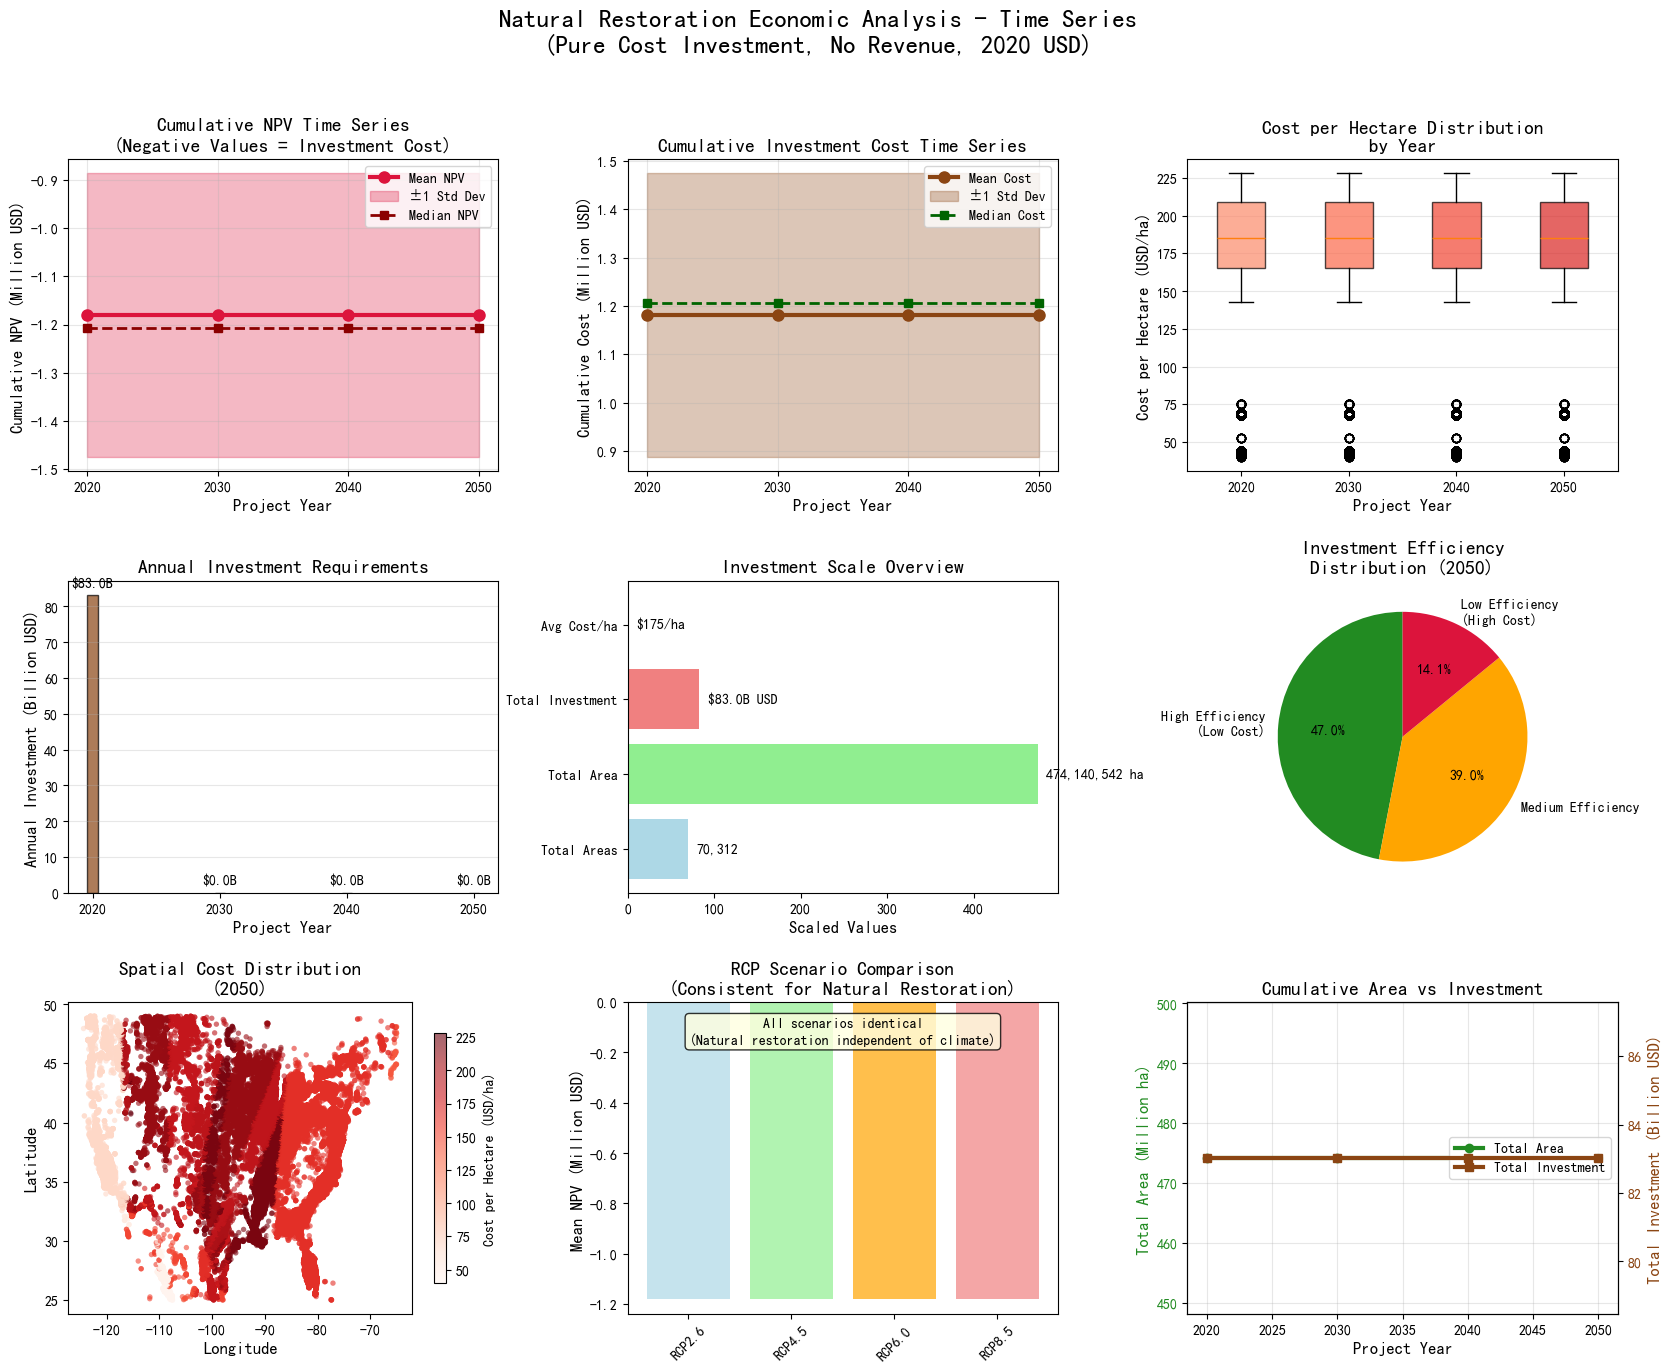


创建成本汇总分析图...
创建自然修复成本汇总分析图...


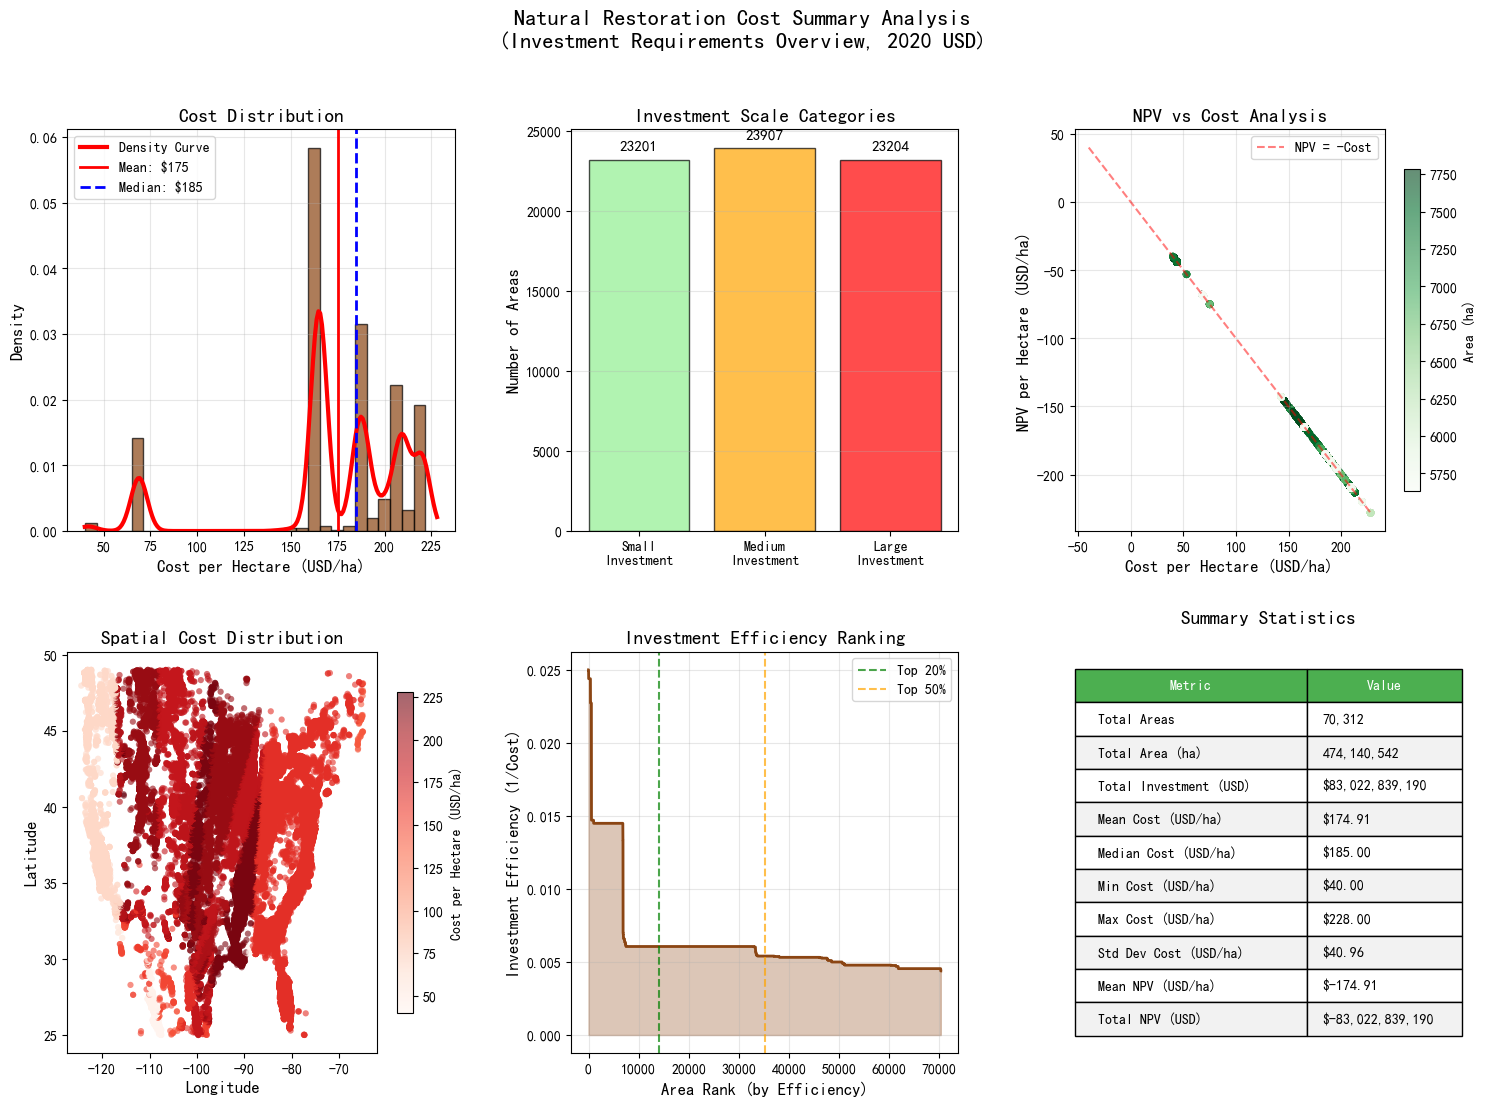


可视化分析完成！
生成的图表:
1. 5.1_natural_restoration_time_series_analysis.png - 时间序列分析
2. 5.1_natural_restoration_cost_summary.png - 成本汇总分析

=== 自然修复投资需求概览 ===
处理区域数量: 70,312
总覆盖面积: 474,140,542 公顷
总投资需求: $83,022,839,190 USD
平均成本: $174.91/公顷
平均NPV: $-174.91/公顷 (负值=纯投资)
成本范围: $40 - $228 USD/公顷


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
from matplotlib.patches import Rectangle, Patch
import warnings
warnings.filterwarnings('ignore')

# ========================================================================================
# 自然修复策略经济可行性可视化函数（时间序列版本）
# ========================================================================================

# 设置配色方案
natural_colors = {
    'cost': '#8B4513',      # 棕色 - 成本
    'npv': '#DC143C',       # 深红色 - NPV（负值）
    'area': '#228B22',      # 森林绿 - 面积
    'time': '#4169E1',      # 皇家蓝 - 时间序列
    'priority': ['#228B22', '#FFA500', '#DC143C']  # 绿、橙、红
}

plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

def load_natural_restoration_data_for_visualization():
    """加载自然修复策略时间序列数据并转换为可视化格式"""
    
    print("加载自然修复策略时间序列数据...")
    
    # 加载时间序列数据
    df_time_series = pd.read_csv('data/5.1_natural_restoration_npv_time_series_2020usd.csv')
    
    # 提取2050年数据用于空间可视化
    df_2050 = df_time_series[
        (df_time_series['project_year'] == 2050) & 
        (df_time_series['rcp_category'] == 'RCP2.6')  # 选择第一个RCP作为代表
    ].copy()
    
    print(f"提取2050年数据用于可视化：{len(df_2050)} 个像素点")
    
    # 重新映射列名以兼容可视化函数
    df_viz = df_2050.rename(columns={
        'cumulative_npv_usd': 'NPV_total',
        'cumulative_cost_usd': 'total_cost',
        'npv_per_ha': 'NPV_per_ha',
        'cost_per_ha': 'cost_per_ha'
    }).copy()
    
    print("数据加载完成")
    return df_time_series, df_viz

def create_natural_restoration_time_series_analysis(df_time_series):
    """创建自然修复时间序列分析图"""
    
    print("创建自然修复时间序列分析图...")
    
    fig = plt.figure(figsize=(20, 15))
    gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3, height_ratios=[1, 1, 1])
    
    # 主标题
    fig.suptitle('Natural Restoration Economic Analysis - Time Series\n(Pure Cost Investment, No Revenue, 2020 USD)', 
                 fontsize=18, fontweight='bold', y=0.98)
    
    # 选择一个RCP作为代表（所有RCP数据相同）
    df_plot = df_time_series[df_time_series['rcp_category'] == 'RCP2.6'].copy()
    
    # ========================================================================================
    # 图1: 累积NPV时间序列 (左上)
    # ========================================================================================
    ax1 = fig.add_subplot(gs[0, 0])
    
    # 按年份分组计算统计数据
    yearly_stats = df_plot.groupby('project_year')['cumulative_npv_usd'].agg(['mean', 'std', 'median']).reset_index()
    
    ax1.plot(yearly_stats['project_year'], yearly_stats['mean'] / 1e6, 
             color=natural_colors['npv'], linewidth=3, marker='o', markersize=8, label='Mean NPV')
    ax1.fill_between(yearly_stats['project_year'], 
                     (yearly_stats['mean'] - yearly_stats['std']) / 1e6,
                     (yearly_stats['mean'] + yearly_stats['std']) / 1e6,
                     color=natural_colors['npv'], alpha=0.3, label='±1 Std Dev')
    ax1.plot(yearly_stats['project_year'], yearly_stats['median'] / 1e6, 
             color='darkred', linewidth=2, linestyle='--', marker='s', markersize=6, label='Median NPV')
    
    ax1.set_xlabel('Project Year', fontsize=12)
    ax1.set_ylabel('Cumulative NPV (Million USD)', fontsize=12)
    ax1.set_title('Cumulative NPV Time Series\n(Negative Values = Investment Cost)', fontweight='bold', fontsize=14)
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    ax1.set_xticks(yearly_stats['project_year'])
    
    # ========================================================================================
    # 图2: 累积成本时间序列 (中上)
    # ========================================================================================
    ax2 = fig.add_subplot(gs[0, 1])
    
    cost_stats = df_plot.groupby('project_year')['cumulative_cost_usd'].agg(['mean', 'std', 'median']).reset_index()
    
    ax2.plot(cost_stats['project_year'], cost_stats['mean'] / 1e6, 
             color=natural_colors['cost'], linewidth=3, marker='o', markersize=8, label='Mean Cost')
    ax2.fill_between(cost_stats['project_year'], 
                     (cost_stats['mean'] - cost_stats['std']) / 1e6,
                     (cost_stats['mean'] + cost_stats['std']) / 1e6,
                     color=natural_colors['cost'], alpha=0.3, label='±1 Std Dev')
    ax2.plot(cost_stats['project_year'], cost_stats['median'] / 1e6, 
             color='darkgreen', linewidth=2, linestyle='--', marker='s', markersize=6, label='Median Cost')
    
    ax2.set_xlabel('Project Year', fontsize=12)
    ax2.set_ylabel('Cumulative Cost (Million USD)', fontsize=12)
    ax2.set_title('Cumulative Investment Cost Time Series', fontweight='bold', fontsize=14)
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    ax2.set_xticks(cost_stats['project_year'])
    
    # ========================================================================================
    # 图3: 每公顷成本分布对比 (右上)
    # ========================================================================================
    ax3 = fig.add_subplot(gs[0, 2])
    
    # 按年份创建箱线图
    years = sorted(df_plot['project_year'].unique())
    cost_per_ha_data = [df_plot[df_plot['project_year'] == year]['cost_per_ha'] for year in years]
    
    bp = ax3.boxplot(cost_per_ha_data, labels=years, patch_artist=True)
    
    # 设置箱线图颜色
    colors = plt.cm.Reds([0.4, 0.5, 0.6, 0.7])
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax3.set_xlabel('Project Year', fontsize=12)
    ax3.set_ylabel('Cost per Hectare (USD/ha)', fontsize=12)
    ax3.set_title('Cost per Hectare Distribution\nby Year', fontweight='bold', fontsize=14)
    ax3.grid(True, alpha=0.3, axis='y')
    
    # ========================================================================================
    # 图4: 年度投资分析 (左中)
    # ========================================================================================
    ax4 = fig.add_subplot(gs[1, 0])
    
    # 计算年度投资
    annual_investment = df_plot.groupby('project_year')['annual_cost_usd'].sum() / 1e9  # 转换为十亿美元
    
    bars = ax4.bar(annual_investment.index, annual_investment.values, 
                   color=natural_colors['cost'], alpha=0.7, edgecolor='black')
    
    # 添加数值标签
    for bar, val in zip(bars, annual_investment.values):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(annual_investment) * 0.02,
                f'${val:.1f}B', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    ax4.set_xlabel('Project Year', fontsize=12)
    ax4.set_ylabel('Annual Investment (Billion USD)', fontsize=12)
    ax4.set_title('Annual Investment Requirements', fontweight='bold', fontsize=14)
    ax4.grid(True, alpha=0.3, axis='y')
    ax4.set_xticks(annual_investment.index)
    
    # ========================================================================================
    # 图5: 总投资规模分析 (中中)
    # ========================================================================================
    ax5 = fig.add_subplot(gs[1, 1])
    
    # 计算总投资规模
    total_areas = len(df_plot[df_plot['project_year'] == 2050])
    total_area_ha = df_plot[df_plot['project_year'] == 2050]['area_ha'].sum()
    total_investment = df_plot[df_plot['project_year'] == 2050]['cumulative_cost_usd'].sum()
    avg_cost_per_ha = total_investment / total_area_ha
    
    # 创建总投资概览
    investment_data = {
        'Total Areas': f'{total_areas:,}',
        'Total Area': f'{total_area_ha:,.0f} ha',
        'Total Investment': f'${total_investment/1e9:.1f}B USD',
        'Avg Cost/ha': f'${avg_cost_per_ha:.0f}/ha'
    }
    
    y_pos = np.arange(len(investment_data))
    values = [total_areas/1000, total_area_ha/1e6, total_investment/1e9, avg_cost_per_ha/1000]
    
    bars = ax5.barh(y_pos, values, color=['lightblue', 'lightgreen', 'lightcoral', 'lightyellow'])
    
    ax5.set_yticks(y_pos)
    ax5.set_yticklabels(list(investment_data.keys()))
    ax5.set_xlabel('Scaled Values', fontsize=12)
    ax5.set_title('Investment Scale Overview', fontweight='bold', fontsize=14)
    
    # 添加实际数值标签
    for i, (bar, key) in enumerate(zip(bars, investment_data.keys())):
        ax5.text(bar.get_width() + max(values) * 0.02, bar.get_y() + bar.get_height()/2,
                investment_data[key], va='center', fontsize=10, fontweight='bold')
    
    # ========================================================================================
    # 图6: 投资效率分析 (右中)
    # ========================================================================================
    ax6 = fig.add_subplot(gs[1, 2])
    
    # 基于成本分位数的效率分析
    cost_2050 = df_plot[df_plot['project_year'] == 2050]['cost_per_ha']
    p25, p75 = np.percentile(cost_2050, [25, 75])
    
    efficiency_categories = ['High Efficiency\n(Low Cost)', 'Medium Efficiency', 'Low Efficiency\n(High Cost)']
    efficiency_counts = [
        (cost_2050 <= p25).sum(),
        ((cost_2050 > p25) & (cost_2050 <= p75)).sum(),
        (cost_2050 > p75).sum()
    ]
    
    # 创建饼图
    colors_eff = natural_colors['priority']
    wedges, texts, autotexts = ax6.pie(efficiency_counts, labels=efficiency_categories, 
                                      colors=colors_eff, autopct='%1.1f%%', startangle=90)
    
    ax6.set_title('Investment Efficiency\nDistribution (2050)', fontweight='bold', fontsize=14)
    
    # ========================================================================================
    # 图7: 空间分布概览 (左下)
    # ========================================================================================
    ax7 = fig.add_subplot(gs[2, 0])
    
    # 获取2050年数据进行空间分析
    df_spatial = df_plot[df_plot['project_year'] == 2050].copy()
    
    scatter = ax7.scatter(df_spatial['lon'], df_spatial['lat'], 
                         c=df_spatial['cost_per_ha'], cmap='Reds', 
                         s=15, alpha=0.6, edgecolors='none')
    
    ax7.set_xlabel('Longitude', fontsize=12)
    ax7.set_ylabel('Latitude', fontsize=12)
    ax7.set_title('Spatial Cost Distribution\n(2050)', fontweight='bold', fontsize=14)
    
    cbar = plt.colorbar(scatter, ax=ax7, shrink=0.8)
    cbar.set_label('Cost per Hectare (USD/ha)', fontsize=10)
    
    # ========================================================================================
    # 图8: RCP情景对比 (中下)
    # ========================================================================================
    ax8 = fig.add_subplot(gs[2, 1])
    
    # 虽然自然修复不区分RCP，但展示数据一致性
    rcp_comparison = df_time_series[df_time_series['project_year'] == 2050].groupby('rcp_category')['cumulative_npv_usd'].mean() / 1e6
    
    bars = ax8.bar(range(len(rcp_comparison)), rcp_comparison.values, 
                   color=['lightblue', 'lightgreen', 'orange', 'lightcoral'], alpha=0.7)
    
    ax8.set_xticks(range(len(rcp_comparison)))
    ax8.set_xticklabels(rcp_comparison.index, rotation=45)
    ax8.set_ylabel('Mean NPV (Million USD)', fontsize=12)
    ax8.set_title('RCP Scenario Comparison\n(Consistent for Natural Restoration)', fontweight='bold', fontsize=14)
    
    # 添加一致性标注
    ax8.text(0.5, 0.95, 'All scenarios identical\n(Natural restoration independent of climate)', 
            transform=ax8.transAxes, ha='center', va='top', fontsize=10,
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    
    # ========================================================================================
    # 图9: 累积统计趋势 (右下)
    # ========================================================================================
    ax9 = fig.add_subplot(gs[2, 2])
    
    # 计算累积面积和投资趋势
    area_trend = df_plot.groupby('project_year')['area_ha'].sum() / 1e6  # 转换为百万公顷
    investment_trend = df_plot.groupby('project_year')['cumulative_cost_usd'].sum() / 1e9  # 转换为十亿美元
    
    ax9_twin = ax9.twinx()
    
    line1 = ax9.plot(area_trend.index, area_trend.values, 
                     color=natural_colors['area'], linewidth=3, marker='o', label='Total Area')
    line2 = ax9_twin.plot(investment_trend.index, investment_trend.values, 
                          color=natural_colors['cost'], linewidth=3, marker='s', label='Total Investment')
    
    ax9.set_xlabel('Project Year', fontsize=12)
    ax9.set_ylabel('Total Area (Million ha)', fontsize=12, color=natural_colors['area'])
    ax9_twin.set_ylabel('Total Investment (Billion USD)', fontsize=12, color=natural_colors['cost'])
    ax9.set_title('Cumulative Area vs Investment', fontweight='bold', fontsize=14)
    
    # 合并图例
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax9.legend(lines, labels, loc='center right')
    
    ax9.tick_params(axis='y', labelcolor=natural_colors['area'])
    ax9_twin.tick_params(axis='y', labelcolor=natural_colors['cost'])
    ax9.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('data/5.1_natural_restoration_time_series_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

def create_natural_restoration_cost_summary(df_viz):
    """创建自然修复成本汇总分析图"""
    
    print("创建自然修复成本汇总分析图...")
    
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)
    
    fig.suptitle('Natural Restoration Cost Summary Analysis\n(Investment Requirements Overview, 2020 USD)', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    # ========================================================================================
    # 图1: 成本分布直方图 (左上)
    # ========================================================================================
    ax1 = fig.add_subplot(gs[0, 0])
    
    cost_data = df_viz['cost_per_ha'].dropna()
    
    # 创建直方图
    n, bins, patches = ax1.hist(cost_data, bins=30, color=natural_colors['cost'], 
                               alpha=0.7, edgecolor='black', density=True)
    
    # 添加核密度估计
    if len(cost_data) > 10:
        kde = gaussian_kde(cost_data)
        x_range = np.linspace(cost_data.min(), cost_data.max(), 200)
        ax1.plot(x_range, kde(x_range), color='red', linewidth=3, label='Density Curve')
    
    # 添加统计线
    mean_cost = cost_data.mean()
    median_cost = cost_data.median()
    ax1.axvline(mean_cost, color='red', linestyle='-', linewidth=2, label=f'Mean: ${mean_cost:.0f}')
    ax1.axvline(median_cost, color='blue', linestyle='--', linewidth=2, label=f'Median: ${median_cost:.0f}')
    
    ax1.set_xlabel('Cost per Hectare (USD/ha)', fontsize=12)
    ax1.set_ylabel('Density', fontsize=12)
    ax1.set_title('Cost Distribution', fontweight='bold', fontsize=14)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # ========================================================================================
    # 图2: 总投资需求分析 (中上)
    # ========================================================================================
    ax2 = fig.add_subplot(gs[0, 1])
    
    total_cost_data = df_viz['total_cost'].dropna()
    
    # 按投资规模分组
    small_investment = (total_cost_data < np.percentile(total_cost_data, 33)).sum()
    medium_investment = ((total_cost_data >= np.percentile(total_cost_data, 33)) & 
                        (total_cost_data < np.percentile(total_cost_data, 67))).sum()
    large_investment = (total_cost_data >= np.percentile(total_cost_data, 67)).sum()
    
    investment_categories = ['Small\nInvestment', 'Medium\nInvestment', 'Large\nInvestment']
    investment_counts = [small_investment, medium_investment, large_investment]
    
    bars = ax2.bar(investment_categories, investment_counts, 
                   color=['lightgreen', 'orange', 'red'], alpha=0.7, edgecolor='black')
    
    # 添加数值标签
    for bar, count in zip(bars, investment_counts):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(investment_counts) * 0.02,
                f'{count}', ha='center', va='bottom', fontweight='bold', fontsize=11)
    
    ax2.set_ylabel('Number of Areas', fontsize=12)
    ax2.set_title('Investment Scale Categories', fontweight='bold', fontsize=14)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # ========================================================================================
    # 图3: NPV vs 成本散点图 (右上)
    # ========================================================================================
    ax3 = fig.add_subplot(gs[0, 2])
    
    scatter = ax3.scatter(df_viz['cost_per_ha'], df_viz['NPV_per_ha'], 
                         c=df_viz['area_ha'], cmap='Greens', 
                         alpha=0.6, s=30, edgecolors='none')
    
    ax3.set_xlabel('Cost per Hectare (USD/ha)', fontsize=12)
    ax3.set_ylabel('NPV per Hectare (USD/ha)', fontsize=12)
    ax3.set_title('NPV vs Cost Analysis', fontweight='bold', fontsize=14)
    ax3.grid(True, alpha=0.3)
    
    # 添加颜色条
    cbar = plt.colorbar(scatter, ax=ax3, shrink=0.8)
    cbar.set_label('Area (ha)', fontsize=10)
    
    # 添加对角线参考
    min_val = min(df_viz['cost_per_ha'].min(), df_viz['NPV_per_ha'].max())
    max_val = max(df_viz['cost_per_ha'].max(), df_viz['NPV_per_ha'].min())
    ax3.plot([min_val, max_val], [-min_val, -max_val], 'r--', alpha=0.5, label='NPV = -Cost')
    ax3.legend()
    
    # ========================================================================================
    # 图4: 空间成本分布 (左下)
    # ========================================================================================
    ax4 = fig.add_subplot(gs[1, 0])
    
    scatter4 = ax4.scatter(df_viz['lon'], df_viz['lat'], 
                          c=df_viz['cost_per_ha'], cmap='Reds', 
                          s=20, alpha=0.6, edgecolors='none')
    
    ax4.set_xlabel('Longitude', fontsize=12)
    ax4.set_ylabel('Latitude', fontsize=12)
    ax4.set_title('Spatial Cost Distribution', fontweight='bold', fontsize=14)
    
    cbar4 = plt.colorbar(scatter4, ax=ax4, shrink=0.8)
    cbar4.set_label('Cost per Hectare (USD/ha)', fontsize=10)
    
    # ========================================================================================
    # 图5: 投资效率排序 (中下)
    # ========================================================================================
    ax5 = fig.add_subplot(gs[1, 1])
    
    # 计算投资效率（成本倒数）
    efficiency = 1 / df_viz['cost_per_ha']
    sorted_efficiency = np.sort(efficiency)[::-1]  # 降序排列
    
    ax5.plot(range(len(sorted_efficiency)), sorted_efficiency, 
             color=natural_colors['cost'], linewidth=2)
    ax5.fill_between(range(len(sorted_efficiency)), 0, sorted_efficiency, 
                     color=natural_colors['cost'], alpha=0.3)
    
    ax5.set_xlabel('Area Rank (by Efficiency)', fontsize=12)
    ax5.set_ylabel('Investment Efficiency (1/Cost)', fontsize=12)
    ax5.set_title('Investment Efficiency Ranking', fontweight='bold', fontsize=14)
    ax5.grid(True, alpha=0.3)
    
    # 标注效率分位数
    p80_idx = int(len(sorted_efficiency) * 0.2)
    p50_idx = int(len(sorted_efficiency) * 0.5)
    
    ax5.axvline(p80_idx, color='green', linestyle='--', alpha=0.7, label='Top 20%')
    ax5.axvline(p50_idx, color='orange', linestyle='--', alpha=0.7, label='Top 50%')
    ax5.legend()
    
    # ========================================================================================
    # 图6: 统计摘要表 (右下)
    # ========================================================================================
    ax6 = fig.add_subplot(gs[1, 2])
    ax6.axis('off')
    
    # 计算关键统计数据
    stats_data = {
        'Metric': [
            'Total Areas',
            'Total Area (ha)',
            'Total Investment (USD)',
            'Mean Cost (USD/ha)',
            'Median Cost (USD/ha)',
            'Min Cost (USD/ha)',
            'Max Cost (USD/ha)',
            'Std Dev Cost (USD/ha)',
            'Mean NPV (USD/ha)',
            'Total NPV (USD)'
        ],
        'Value': [
            f'{len(df_viz):,}',
            f'{df_viz["area_ha"].sum():,.0f}',
            f'${df_viz["total_cost"].sum():,.0f}',
            f'${df_viz["cost_per_ha"].mean():.2f}',
            f'${df_viz["cost_per_ha"].median():.2f}',
            f'${df_viz["cost_per_ha"].min():.2f}',
            f'${df_viz["cost_per_ha"].max():.2f}',
            f'${df_viz["cost_per_ha"].std():.2f}',
            f'${df_viz["NPV_per_ha"].mean():.2f}',
            f'${df_viz["NPV_total"].sum():,.0f}'
        ]
    }
    
    # 创建表格
    table_data = list(zip(stats_data['Metric'], stats_data['Value']))
    table = ax6.table(cellText=table_data, 
                     colLabels=['Metric', 'Value'],
                     cellLoc='left', loc='center',
                     colWidths=[0.6, 0.4])
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    
    # 设置表格样式
    for i in range(len(table_data) + 1):
        for j in range(2):
            cell = table[(i, j)]
            if i == 0:  # 表头
                cell.set_facecolor('#4CAF50')
                cell.set_text_props(weight='bold', color='white')
            elif i % 2 == 0:  # 偶数行
                cell.set_facecolor('#f2f2f2')
            else:  # 奇数行
                cell.set_facecolor('white')
            cell.set_edgecolor('black')
    
    ax6.set_title('Summary Statistics', fontweight='bold', fontsize=14, pad=20)
    
    plt.tight_layout()
    plt.savefig('data/5.1_natural_restoration_cost_summary.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

def run_natural_restoration_visualization():
    """运行完整的自然修复策略可视化分析"""
    
    print("================================================================================")
    print("自然修复策略经济可行性可视化分析")
    print("================================================================================")
    
    try:
        # 加载数据
        df_time_series, df_viz = load_natural_restoration_data_for_visualization()
        
        # 创建时间序列分析图
        print("\n创建时间序列分析图...")
        fig1 = create_natural_restoration_time_series_analysis(df_time_series)
        
        # 创建成本汇总分析图
        print("\n创建成本汇总分析图...")
        fig2 = create_natural_restoration_cost_summary(df_viz)
        
        print("\n================================================================================")
        print("可视化分析完成！")
        print("================================================================================")
        print("生成的图表:")
        print("1. 5.1_natural_restoration_time_series_analysis.png - 时间序列分析")
        print("2. 5.1_natural_restoration_cost_summary.png - 成本汇总分析")
        
        # 输出关键统计信息
        print(f"\n=== 自然修复投资需求概览 ===")
        total_areas = len(df_viz)
        total_area_ha = df_viz['area_ha'].sum()
        total_investment = df_viz['total_cost'].sum()
        avg_cost_per_ha = df_viz['cost_per_ha'].mean()
        avg_npv_per_ha = df_viz['NPV_per_ha'].mean()
        
        print(f"处理区域数量: {total_areas:,}")
        print(f"总覆盖面积: {total_area_ha:,.0f} 公顷")
        print(f"总投资需求: ${total_investment:,.0f} USD")
        print(f"平均成本: ${avg_cost_per_ha:.2f}/公顷")
        print(f"平均NPV: ${avg_npv_per_ha:.2f}/公顷 (负值=纯投资)")
        print(f"成本范围: ${df_viz['cost_per_ha'].min():.0f} - ${df_viz['cost_per_ha'].max():.0f} USD/公顷")
        
        return df_time_series, df_viz
        
    except Exception as e:
        print(f"可视化过程中出错: {e}")
        import traceback
        traceback.print_exc()
        return None, None

# ========================================================================================
# 运行可视化分析
# ========================================================================================

if __name__ == "__main__":
    df_time_series, df_viz = run_natural_restoration_visualization()

# 5.5 策略期望成本

结合各个输出文件的变量，结合'df_strategies'中的三类权重构造净期望收益-成本

大致需要输出以下变量：


accumulative npv from 2020-2050 by pixel : npv of pv-  ('weighted_density_Forest' * npv of afforestation + 'weighted_density_Agricultural' * npv of agricultural + 'weighted_density_Vegetation' * npv of natural) 
accumulative cost from 2020-2050 by pixel : 重复以上逻辑，把npv 置换成 cost 变量

total npv by pixel
total cost by pixel 

以上计算需要区分不同情境(RCP2.6\RCP4.5\RCP6.0\RCP8.5)、整体平均水平进行汇总,例如:

假设每个pixel中，npv of pv 存在n种不同值, npv of afforestation 存在m种，npv of agricultural 存在p种，npv of natural存在q种，那么一共存在
n*m*p*q的可能路径




'df_pv_npv': r'data/5.1_photovoltaic_npv_time_series_corrected_2020usd.csv',
'df_pv_rcp_year':r'data/5.1_photovoltaic_summary_corrected_by_rcp_year_2020usd.csv',
'df_pv_rcp_overall':r'data/5.1_photovoltaic_rcp_averages_corrected_2020usd.csv',
'df_pv_2050':r'data/5.1_photovoltaic_with_economic_feasibility_corrected.csv',

'df_agricultural_npv':r'data/5.1_agricultural_npv_time_series_corrected_2020usd.csv',
'df_agricultural_rcp_year':r'data/5.1_agricultural_summary_corrected_by_rcp_year_2020usd.csv',
'df_agricultural_rcp_overall':r'data/5.1_agricultural_rcp_averages_corrected_2020usd.csv',
'df_agricultural_2050':r'data/5.1_agricultural_production_with_economic_feasibility_corrected.csv',

'df_afforestation_npv': r'data/5.1_afforestation_npv_time_series_corrected_2020usd.csv',
'df_afforestation_rcp_year': r'data/5.1_afforestation_summary_corrected_by_rcp_year_2020usd.csv',
'df_afforestation_rcp_overall': r'data/5.1_afforestation_rcp_averages_corrected_2020usd.csv',
'df_afforestation_2050': r'data/5.1_afforestation_with_economic_feasibility_corrected.csv',

'df_natural_npv': r'data/5.1_natural_restoration_npv_time_series_2020usd.csv',

In [56]:
df_pv_npv=pd.read_csv(PATHS['df_pv_npv'])
df_pv_npv.columns










### 1、 check data

In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# 导入全局变量
from function.global_varibles import PATHS

# ========================================================================================
# 1. 项目参数和配置
# ========================================================================================

PROJECT_START_YEAR = 2020
TARGET_YEARS = [2020, 2030, 2040, 2050]
RCP_SCENARIOS = ['RCP2.6', 'RCP4.5', 'RCP6.0', 'RCP8.5']

# ========================================================================================
# 2. 数据加载和标准化函数
# ========================================================================================

def standardize_column_names(df):
    """标准化列名，处理不同文件中的列名差异"""
    column_mapping = {
        'RCP_Category': 'rcp_category',
        'RCP_category': 'rcp_category',
        'rcp': 'rcp_category',
        'years_from_start': 'project_year'
    }
    df_renamed = df.rename(columns=column_mapping)
    
    # 如果还没有project_year列，尝试创建
    if 'project_year' not in df_renamed.columns:
        if 'years_from_start' in df.columns:
            df_renamed['project_year'] = PROJECT_START_YEAR + df['years_from_start']
        elif 'analysis_year' in df.columns:
            df_renamed['project_year'] = df['analysis_year']
    
    return df_renamed

def load_all_strategy_data():
    """加载所有策略的NPV时间序列数据"""
    data = {}
    npv_files = {
        'pv_npv': PATHS['df_pv_npv'],
        'agricultural_npv': PATHS['df_agricultural_npv'],
        'afforestation_npv': PATHS['df_afforestation_npv'],
        'natural_npv': PATHS.get('df_natural_npv', 'data/5.1_natural_npv_time_series_corrected_2020usd.csv')
    }
    
    # 加载NPV时间序列数据
    for key, file_path in npv_files.items():
        df = pd.read_csv(file_path)
        if 'coord_key' not in df.columns:
            df['coord_key'] = df['lat'].astype(str) + '_' + df['lon'].astype(str)
        df = standardize_column_names(df)
        data[key] = df
    
    # 加载权重数据
    weights_df = pd.read_csv(PATHS.get('data_strategies', 'data/4.df_strategies.csv'))
    if 'coord_key' not in weights_df.columns:
        weights_df['coord_key'] = weights_df['lat'].astype(str) + '_' + weights_df['lon'].astype(str)
    data['weights'] = weights_df
    
    return data

# ========================================================================================
# 3. 光伏路径追踪函数
# ========================================================================================

def create_photovoltaic_pathway_tracker(df_pv_npv):
    """创建光伏路径追踪器，标记所有路径组合"""
    
    # 创建路径组合标识符
    pathway_cols = []
    if 'rcp_category' in df_pv_npv.columns:
        pathway_cols.append('rcp_category')
    if 'Model' in df_pv_npv.columns:
        pathway_cols.append('Model')
    if 'analysis_year' in df_pv_npv.columns:
        pathway_cols.append('analysis_year')
    if 'project_year' in df_pv_npv.columns:
        pathway_cols.append('project_year')
    
    # 创建增强的数据
    df_pv_enhanced = df_pv_npv.copy()
    if pathway_cols:
        df_pv_enhanced['pathway_signature'] = df_pv_enhanced[pathway_cols].apply(
            lambda x: '_'.join([f"{col}:{val}" for col, val in zip(pathway_cols, x)]), 
            axis=1
        )
    
    # 为每个像素点的路径编号
    df_pv_enhanced['pixel_pathway_id'] = df_pv_enhanced.groupby('coord_key').cumcount() + 1
    
    return df_pv_enhanced, {}

def run_pathway_analysis(data):
    """运行光伏路径分析"""
    df_pv_enhanced, _ = create_photovoltaic_pathway_tracker(data['pv_npv'])
    data['pv_npv_enhanced'] = df_pv_enhanced
    return df_pv_enhanced

gogogo


### 2、 calculation

In [3]:
# ========================================================================================
# 4. 净期望收益-成本计算函数
# ========================================================================================

def calculate_net_expected_revenue_cost_with_pathways(data, target_year=2050, rcp_scenario='RCP2.6'):
    """计算净期望收益-成本（保留光伏多路径版本）"""
    
    weights = data['weights'].copy()
    pv_data = data.get('pv_npv_enhanced', data['pv_npv'])
    
    # 光伏数据过滤
    pv_filtered = pv_data[
        (pv_data['project_year'] == target_year) & 
        (pv_data['rcp_category'] == rcp_scenario)
    ].copy()
    
    if 'pv_pathway_id' not in pv_filtered.columns:
        pv_filtered['pv_pathway_id'] = range(len(pv_filtered))
    
    # 其他策略数据过滤
    strategy_data = {'pv': pv_filtered}
    for name, data_key in [('agricultural', 'agricultural_npv'), 
                           ('afforestation', 'afforestation_npv'), 
                           ('natural', 'natural_npv')]:
        if data_key in data:
            filtered = data[data_key][
                (data[data_key]['project_year'] == target_year) & 
                (data[data_key]['rcp_category'] == rcp_scenario)
            ].drop_duplicates(subset=['coord_key'], keep='first')
            strategy_data[name] = filtered
        else:
            strategy_data[name] = pd.DataFrame()
    
    # 生成组合
    results = []
    for _, weight_row in tqdm(weights.iterrows(), total=len(weights), desc="计算组合"):
        coord_key = weight_row['coord_key']
        pv_paths = strategy_data['pv'][strategy_data['pv']['coord_key'] == coord_key]
        
        # 获取其他策略数据
        other_strategies = {}
        for name in ['agricultural', 'afforestation', 'natural']:
            strategy_row = strategy_data[name][strategy_data[name]['coord_key'] == coord_key]
            other_strategies[name] = strategy_row.iloc[0] if not strategy_row.empty else None
        
        # 为每个光伏路径生成组合记录
        if not pv_paths.empty:
            for _, pv_row in pv_paths.iterrows():
                result_row = {
                    'coord_key': coord_key,
                    'lat': weight_row['lat'],
                    'lon': weight_row['lon'],
                    'project_year': target_year,
                    'rcp_scenario': rcp_scenario,
                    'pv_pathway_id': pv_row.get('pv_pathway_id', 0),
                    'pv_npv_usd': pv_row['cumulative_npv_usd'],
                    'pv_cost_usd': pv_row['cumulative_cost_usd'],
                    'weighted_density_Forest': weight_row['weighted_density_Forest'],
                    'weighted_density_Agricultural': weight_row['weighted_density_Agricultural'], 
                    'weighted_density_Vegetation': weight_row['weighted_density_Vegetation']
                }
                
                # 添加其他策略的NPV和成本
                for name in ['agricultural', 'afforestation', 'natural']:
                    if other_strategies[name] is not None:
                        result_row[f'{name}_npv_usd'] = other_strategies[name]['cumulative_npv_usd']
                        result_row[f'{name}_cost_usd'] = other_strategies[name]['cumulative_cost_usd']
                    else:
                        result_row[f'{name}_npv_usd'] = 0
                        result_row[f'{name}_cost_usd'] = 0
                
                # 计算加权成本和净期望收益
                weighted_cost = (
                    weight_row['weighted_density_Forest'] * result_row['afforestation_npv_usd'] +
                    weight_row['weighted_density_Agricultural'] * result_row['agricultural_npv_usd'] + 
                    weight_row['weighted_density_Vegetation'] * result_row['natural_npv_usd']
                )
                
                result_row['weighted_opportunity_cost_usd'] = weighted_cost
                result_row['net_expected_revenue_usd'] = result_row['pv_npv_usd'] - weighted_cost
                results.append(result_row)
        else:
            # 无光伏路径的记录
            result_row = {
                'coord_key': coord_key,
                'lat': weight_row['lat'],
                'lon': weight_row['lon'], 
                'project_year': target_year,
                'rcp_scenario': rcp_scenario,
                'pv_pathway_id': -1,
                'pv_npv_usd': 0,
                'pv_cost_usd': 0,
                'weighted_density_Forest': weight_row['weighted_density_Forest'],
                'weighted_density_Agricultural': weight_row['weighted_density_Agricultural'],
                'weighted_density_Vegetation': weight_row['weighted_density_Vegetation']
            }
            
            for name in ['agricultural', 'afforestation', 'natural']:
                if other_strategies[name] is not None:
                    result_row[f'{name}_npv_usd'] = other_strategies[name]['cumulative_npv_usd']
                    result_row[f'{name}_cost_usd'] = other_strategies[name]['cumulative_cost_usd']
                else:
                    result_row[f'{name}_npv_usd'] = 0
                    result_row[f'{name}_cost_usd'] = 0
            
            weighted_cost = (
                weight_row['weighted_density_Forest'] * result_row['afforestation_npv_usd'] +
                weight_row['weighted_density_Agricultural'] * result_row['agricultural_npv_usd'] + 
                weight_row['weighted_density_Vegetation'] * result_row['natural_npv_usd']
            )
            
            result_row['weighted_opportunity_cost_usd'] = weighted_cost
            result_row['net_expected_revenue_usd'] = -weighted_cost
            results.append(result_row)
    
    return pd.DataFrame(results)

def calculate_all_scenario_combinations_with_pathways(data):
    """计算所有情景组合"""
    all_results = []
    for year in TARGET_YEARS:
        for rcp in RCP_SCENARIOS:
            result_df = calculate_net_expected_revenue_cost_with_pathways(data, year, rcp)
            if not result_df.empty:
                all_results.append(result_df)
    
    return pd.concat(all_results, ignore_index=True) if all_results else pd.DataFrame()

def calculate_scenario_averages(df_combined):
    """计算RCP情景平均值"""
    if df_combined.empty:
        return pd.DataFrame()
    
    groupby_cols = ['coord_key', 'lat', 'lon', 'project_year', 'pv_pathway_id']
    existing_cols = [col for col in groupby_cols if col in df_combined.columns]
    
    agg_dict = {
        'pv_npv_usd': 'mean',
        'pv_cost_usd': 'mean',
        'agricultural_npv_usd': 'mean',
        'agricultural_cost_usd': 'mean',
        'afforestation_npv_usd': 'mean',
        'afforestation_cost_usd': 'mean',
        'natural_npv_usd': 'mean',
        'natural_cost_usd': 'mean',
        'weighted_opportunity_cost_usd': 'mean',
        'net_expected_revenue_usd': 'mean',
        'weighted_density_Forest': 'first',
        'weighted_density_Agricultural': 'first',
        'weighted_density_Vegetation': 'first'
    }
    
    agg_dict = {k: v for k, v in agg_dict.items() if k in df_combined.columns}
    df_avg = df_combined.groupby(existing_cols).agg(agg_dict).reset_index()
    df_avg['rcp_scenario'] = 'Average'
    
    return df_avg

# ========================================================================================
# 5. 主执行函数
# ========================================================================================

def run_comprehensive_pathway_analysis():
    """运行完整的路径分析流程"""
    
    # 1. 加载数据
    data = load_all_strategy_data()
    
    # 2. 运行路径分析
    df_pv_enhanced = run_pathway_analysis(data)
    
    # 3. 计算所有组合
    df_combined = calculate_all_scenario_combinations_with_pathways(data)
    
    # 4. 计算平均值
    df_avg = calculate_scenario_averages(df_combined)
    
    # 5. 保存结果
    if not df_combined.empty:
        df_combined.to_csv('data/comprehensive_pathway_analysis.csv', index=False)
    if not df_avg.empty:
        df_avg.to_csv('data/pathway_rcp_averages.csv', index=False)
    
    return data, df_combined, df_avg

# ========================================================================================
# 6. 辅助函数
# ========================================================================================

def export_pathway_results_for_visualization(df_combined, target_year=2050):
    """导出特定年份的路径结果用于可视化"""
    if df_combined.empty:
        return pd.DataFrame()
    
    df_viz = df_combined[df_combined['project_year'] == target_year].copy()
    df_viz_renamed = df_viz.rename(columns={
        'net_expected_revenue_usd': 'NPV_per_ha',
        'pv_cost_usd': 'afforestation_cost_per_ha',
        'pv_npv_usd': 'pv_npv_per_ha',
        'agricultural_npv_usd': 'agricultural_npv_per_ha',
        'afforestation_npv_usd': 'afforestation_npv_per_ha',
        'natural_npv_usd': 'natural_npv_per_ha'
    })
    
    return df_viz_renamed


run_comprehensive_pathway_analysis()

ValueError: cannot reindex on an axis with duplicate labels